Загружаем данные

In [1]:
import requests

with open('Lab1.zip', 'wb') as fh:
  resp = requests.get('https://github.com/DimaKurd/cv_lab1/raw/master/lab1/Lab1.zip')
  fh.write(resp.content)

In [2]:
! unzip Lab1.zip -d .

Archive:  Lab1.zip
   creating: ./images/
  inflating: ./images/Abyssinian_122.jpg  
  inflating: ./images/Abyssinian_19.jpg  
  inflating: ./images/Abyssinian_210.jpg  
  inflating: ./images/Abyssinian_24.jpg  
  inflating: ./images/Abyssinian_31.jpg  
  inflating: ./images/Abyssinian_44.jpg  
  inflating: ./images/Abyssinian_66.jpg  
  inflating: ./images/Abyssinian_9.jpg  
  inflating: ./images/american_bulldog_140.jpg  
  inflating: ./images/american_bulldog_199.jpg  
  inflating: ./images/american_bulldog_95.jpg  
  inflating: ./images/basset_hound_118.jpg  
  inflating: ./images/basset_hound_14.jpg  
  inflating: ./images/basset_hound_181.jpg  
  inflating: ./images/beagle_1.jpg   
  inflating: ./images/beagle_180.jpg  
  inflating: ./images/Bengal_103.jpg  
  inflating: ./images/Bengal_147.jpg  
  inflating: ./images/Bengal_50.jpg  
  inflating: ./images/Birman_31.jpg  
  inflating: ./images/Birman_7.jpg   
  inflating: ./images/Bombay_16.jpg  
  inflating: ./images/Bombay_48.jp

In [3]:
import os, cv2
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

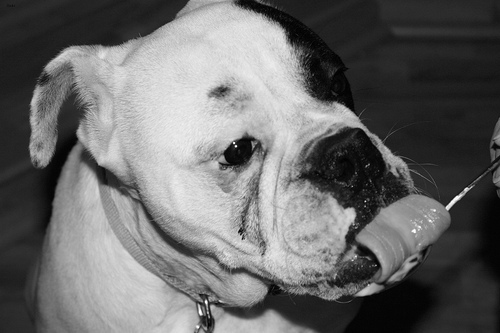

In [4]:
image_path = "/content/images/american_bulldog_140.jpg"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(img)


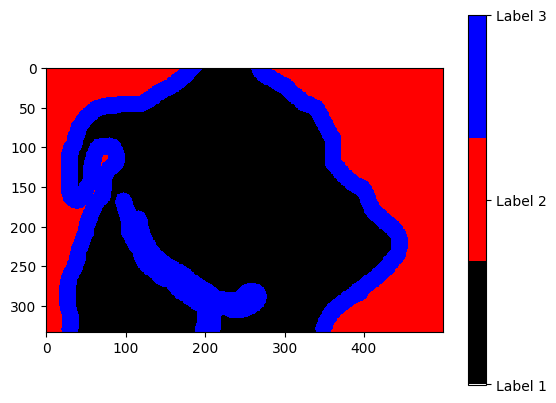

In [5]:
image_path = "/content/annotations/american_bulldog_140.png"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

cmap = plt.cm.colors.ListedColormap(['black', 'red', 'blue'])

plt.imshow(img, cmap=cmap, interpolation='nearest')
plt.colorbar(ticks=[1, 2, 3], format='Label %d')
plt.show()

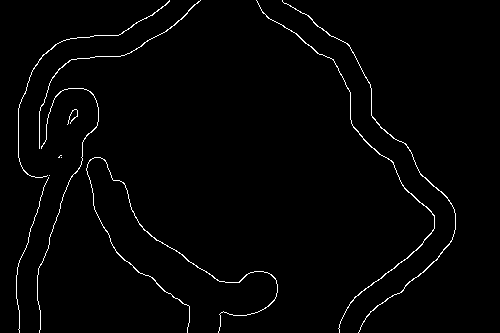

In [15]:
edges = cv2.Canny(img, 0, 2)
cv2_imshow(edges)

Метод для обработки изображения

In [55]:
import os, cv2
import pandas as pd, numpy as np
from typing import List

def get_foreground_mask(image_path: str) -> List[tuple]:
    """
    Метод для вычисления маски переднего плана на фото
    :param image_path - путь до фото
    :return массив в формате [(x_1, y_1), (x_2, y_2), (x_3, y_3)], в котором перечислены все точки, относящиеся к маске
    """
    # Считываем изображение и преобразуем его в оттенки серого
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Применяем гауссовское размытие для уменьшения шума
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Вычисляем градиенты с использованием операторов Собеля
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    # laplacian = cv2.Laplacian(img,cv2.CV_64F)
    # canny = cv2.Canny(img, 0, 2)
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    gradient_direction = np.arctan2(sobely, sobelx)

    # Определяем порог для величины градиента
    threshold = np.percentile(gradient_magnitude, 68)

    # Создаем двоичную маску на основе порога величины градиента
    mask = np.zeros_like(gradient_magnitude)
    mask = np.where(gradient_magnitude > threshold, 255, 0).astype('uint8')

    cv2_imshow(mask)

    # Находим контуры
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    foreground = np.zeros_like(mask)

    # Заполняем область на изображении переднего плана белым цветом
    # cv2.drawContours(foreground, contours, -1, 255, thickness=cv2.FILLED)
    # cv2.fillPoly(foreground, contours, 255)
    for contour in contours:
      hull = cv2.convexHull(contour)
      cv2.fillPoly(foreground, [hull], 255)

    # Находим координаты точек переднего плана
    foreground = foreground / 255
    pred_points = np.argwhere(foreground)

    cv2_imshow(foreground*255)

    return pred_points


Расчёт метрики

In [56]:
def evaluate_iou(image_dir: str, anno_dir: str) -> float:
    """
    Метод для расчёта mean IoU на датасете
    :param image_dir - каталог с фото для анализа
    :param anno_dir - каталог с аннотациями для расчета метрики
    :return значение mean IoU с сохранением оценки по каждому фото в csv-файл
    """

    iou_data = dict()
    for _, _, files in os.walk(image_dir):
        assert files is not None, 'no files read'
        for image_name in files:
            print(f'Processing file {image_name}')
            sample_name = image_name[:image_name.find('.jpg')]

            # acquiring ground truth mask data
            mask_true = cv2.imread(os.path.join(anno_dir, f'{sample_name}.png'))
            assert mask_true is not None, 'mask is None'
            true_points = cv2.cvtColor(mask_true, cv2.COLOR_BGR2GRAY)
            true_points[true_points != 2] = 1
            true_points[true_points == 2] = 0
            true_points = np.argwhere(true_points)
            true_points_set = set([tuple(x) for x in true_points])

            # acquiring predicted mask
            pred_points = get_foreground_mask(image_path=os.path.join(image_dir, image_name))
            assert pred_points is not None, 'pred_points is None'
            pred_points_set = set([tuple(x) for x in pred_points])

            # calculating IoU
            iou = len(true_points_set.intersection(pred_points_set)) / len(true_points_set.union(pred_points_set))

            image_names = iou_data.get('image_names', [])
            image_names.append(sample_name)
            iou_data['image_names'] = image_names

            iou_values = iou_data.get('iou_values', [])
            iou_values.append(iou)
            iou_data['iou_values'] = iou_values

        pd.DataFrame(data=iou_data).to_csv('detailed_results.csv')
        return np.mean(iou_data['iou_values'])

Вызов расчёта метрики

Processing file boxer_11.jpg


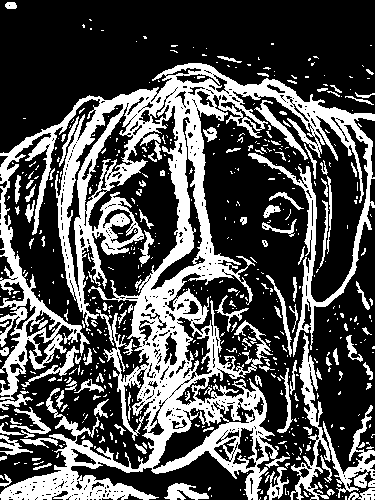

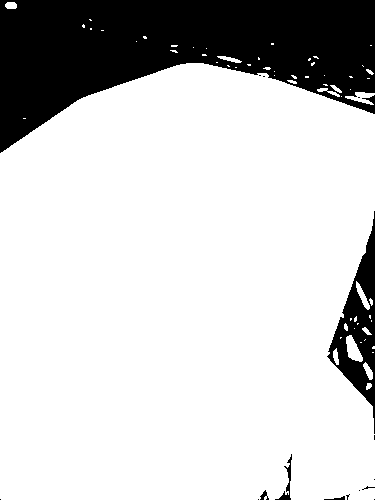

Processing file Abyssinian_24.jpg


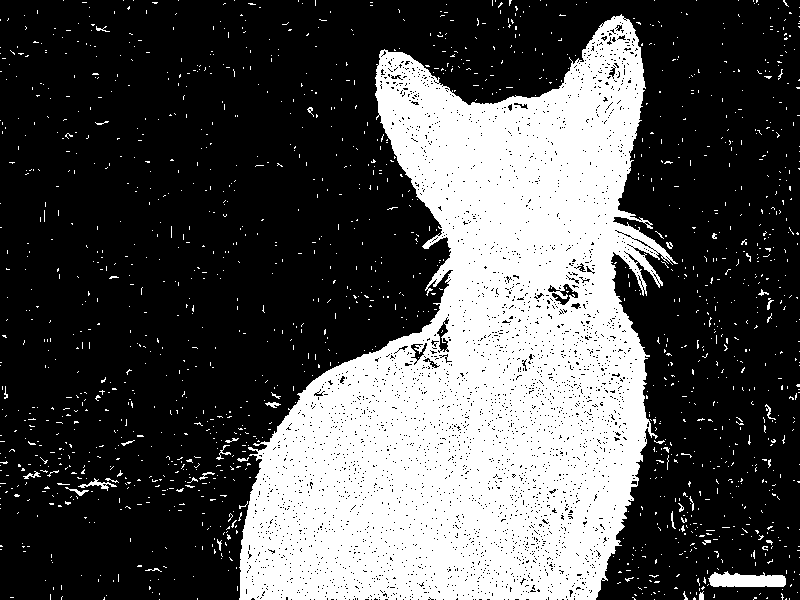

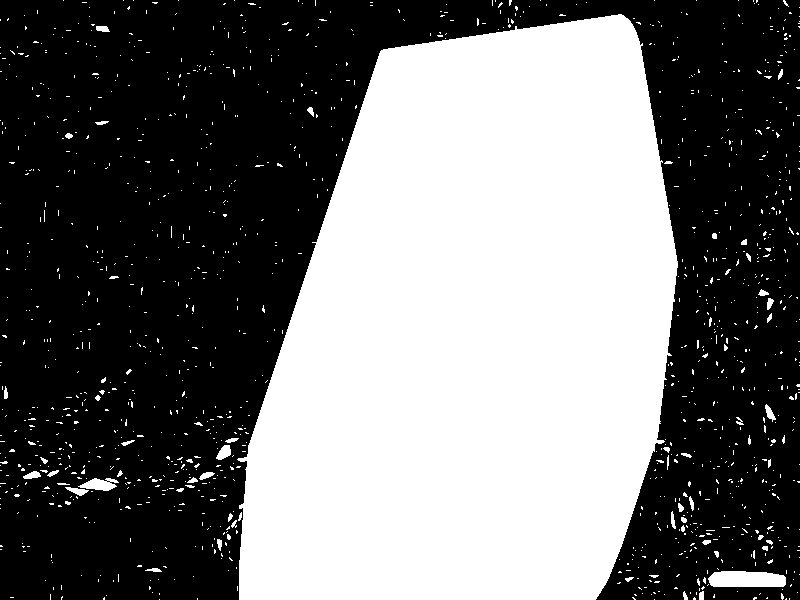

Processing file Russian_Blue_171.jpg


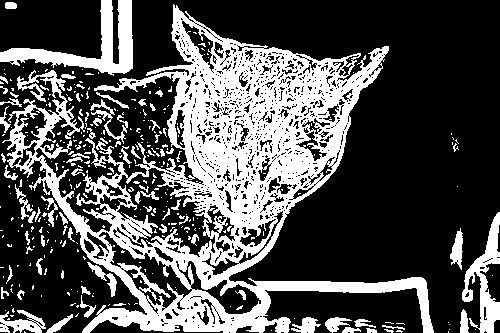

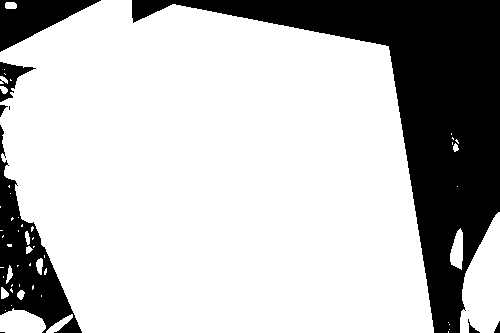

Processing file Abyssinian_210.jpg


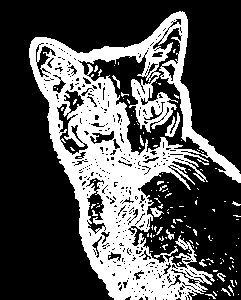

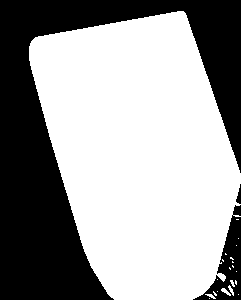

Processing file beagle_180.jpg


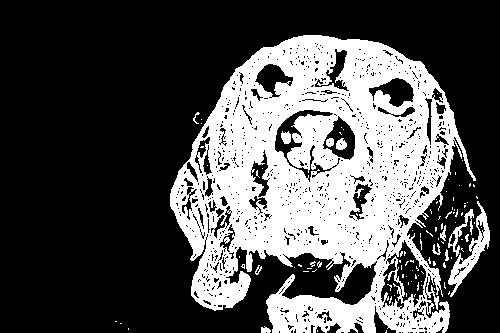

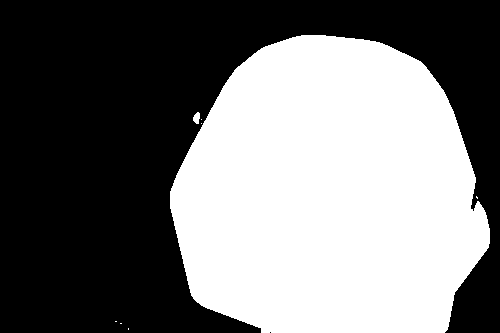

Processing file basset_hound_181.jpg


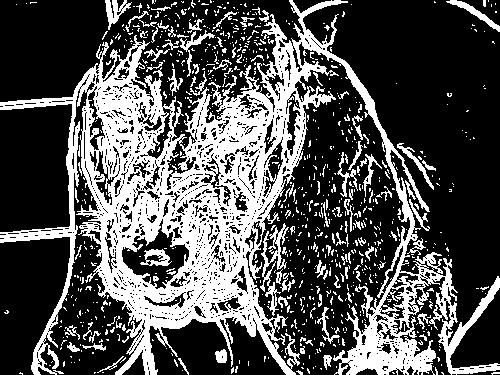

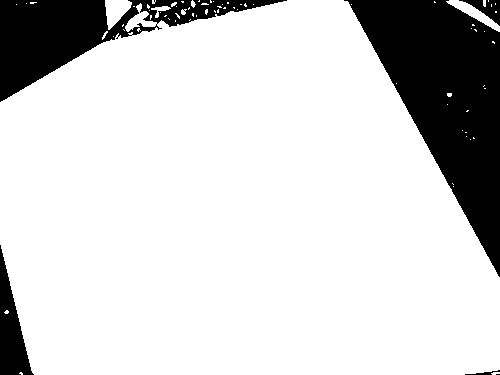

Processing file Egyptian_Mau_95.jpg


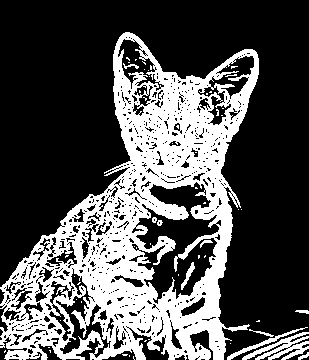

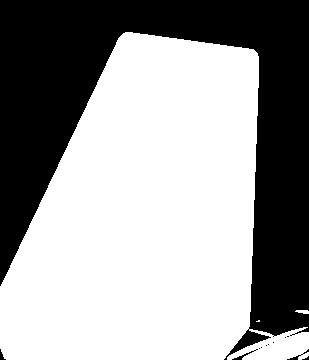

Processing file Siamese_128.jpg


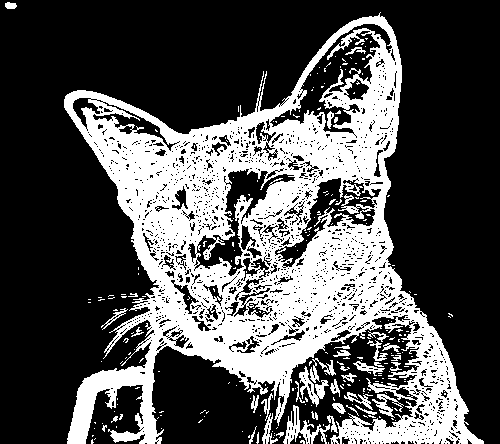

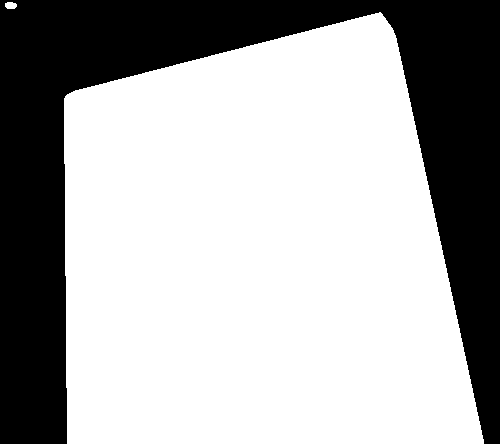

Processing file pug_13.jpg


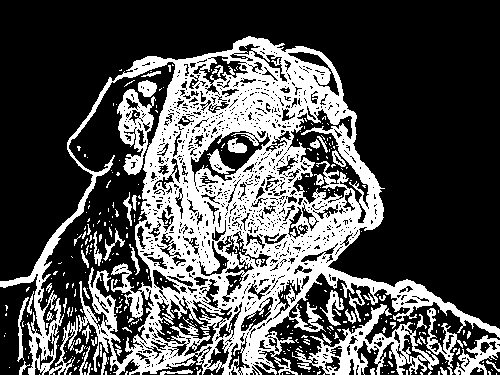

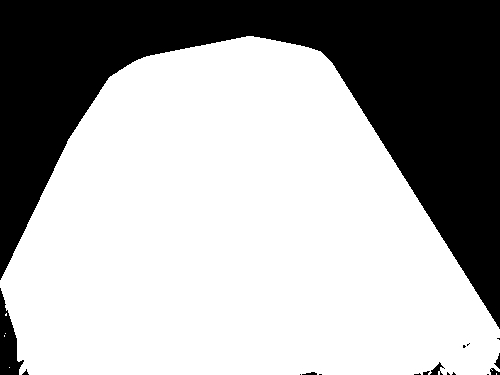

Processing file Bengal_147.jpg


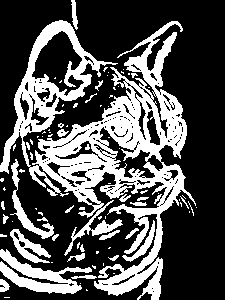

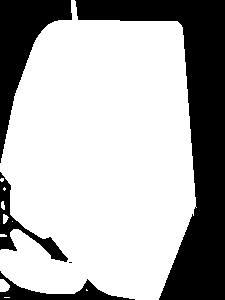

Processing file Sphynx_139.jpg


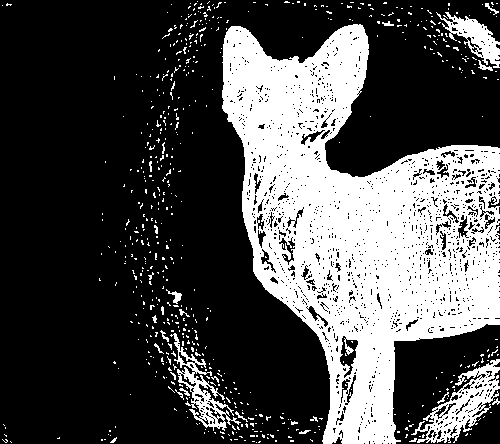

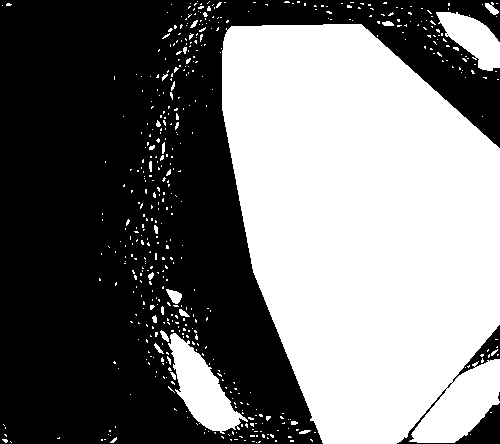

Processing file basset_hound_14.jpg


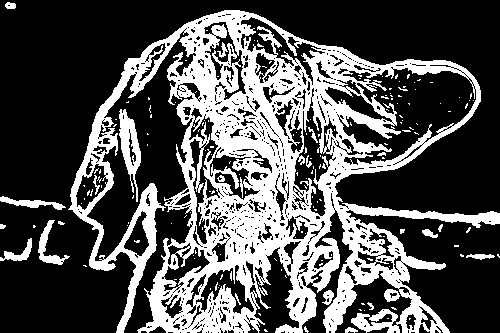

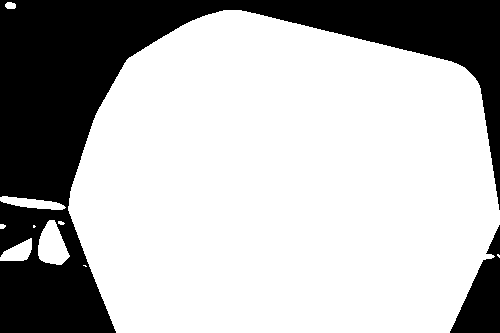

Processing file Maine_Coon_79.jpg


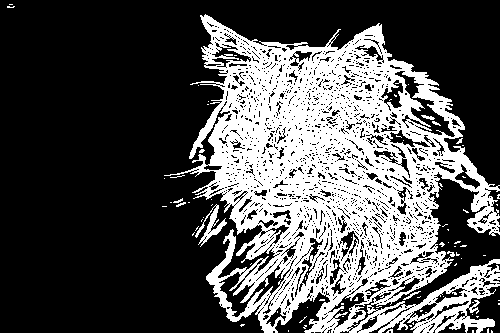

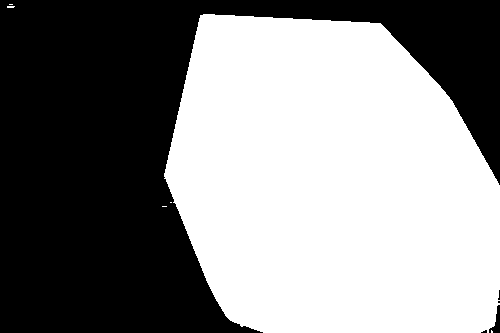

Processing file keeshond_92.jpg


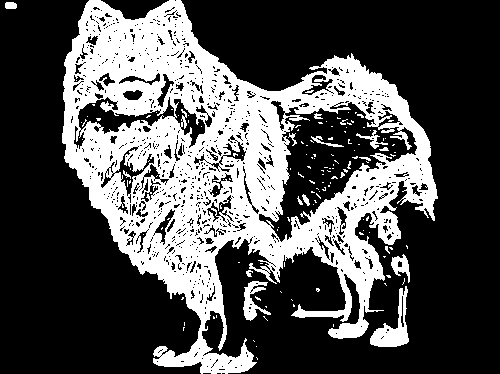

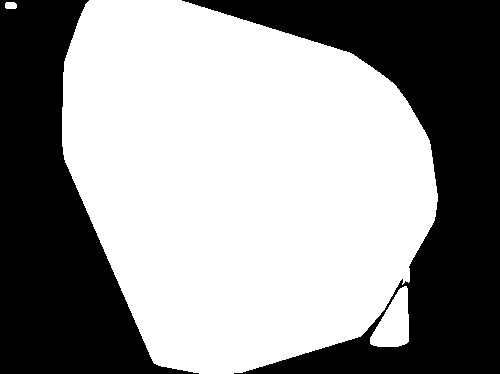

Processing file Abyssinian_66.jpg


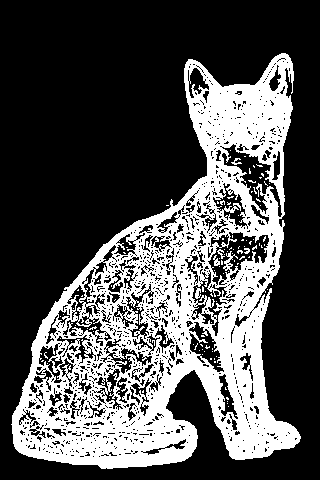

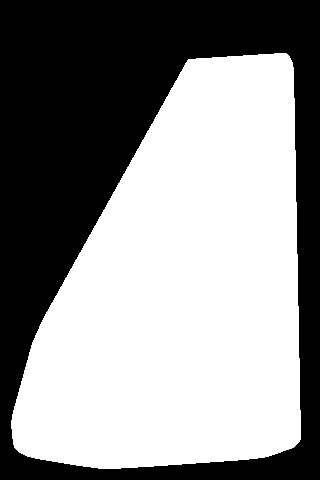

Processing file leonberger_100.jpg


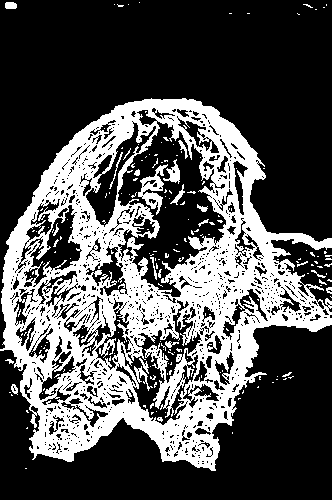

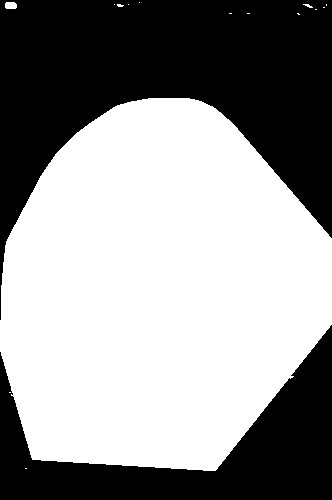

Processing file yorkshire_terrier_90.jpg


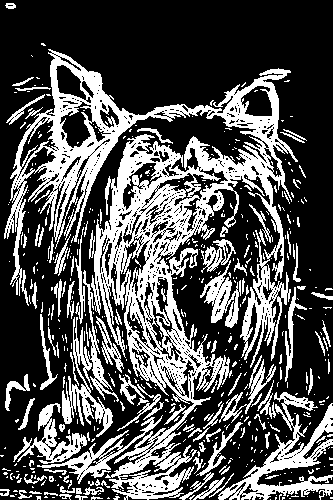

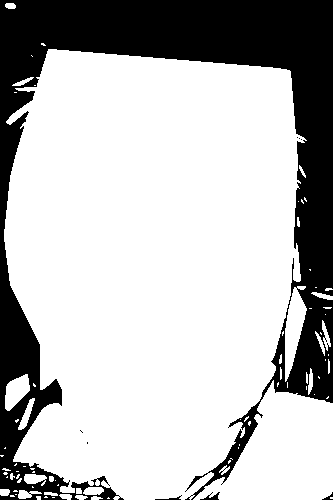

Processing file Birman_7.jpg


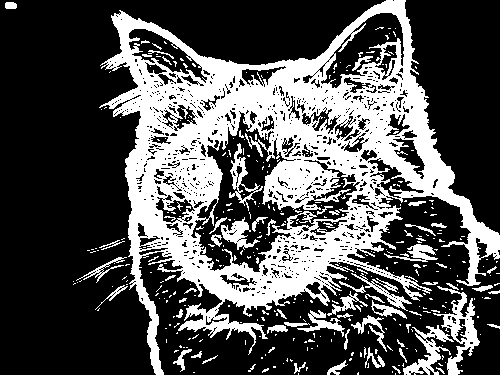

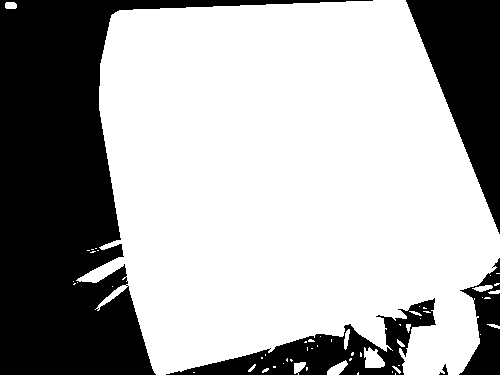

Processing file shiba_inu_132.jpg


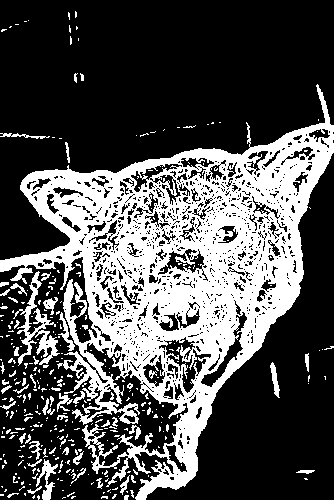

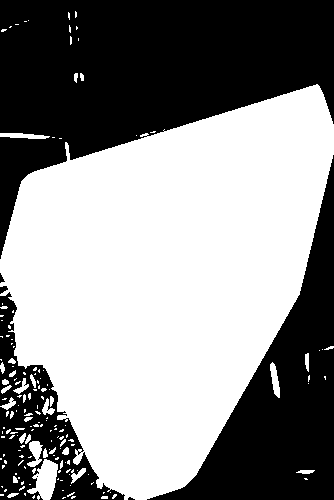

Processing file Persian_16.jpg


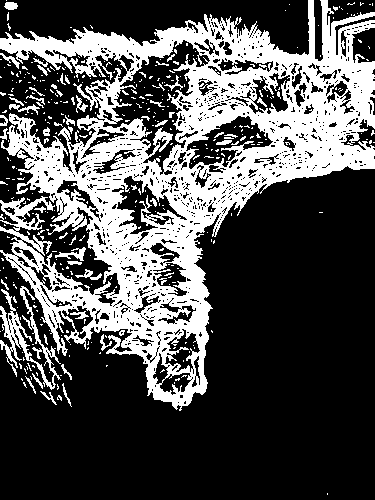

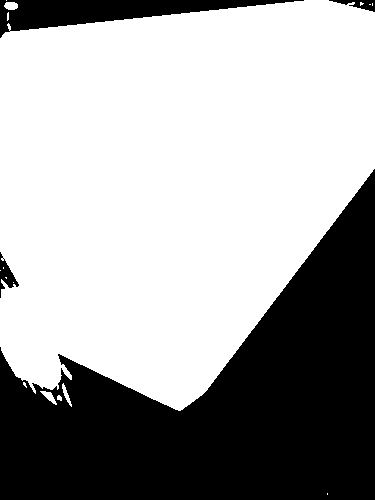

Processing file Ragdoll_188.jpg


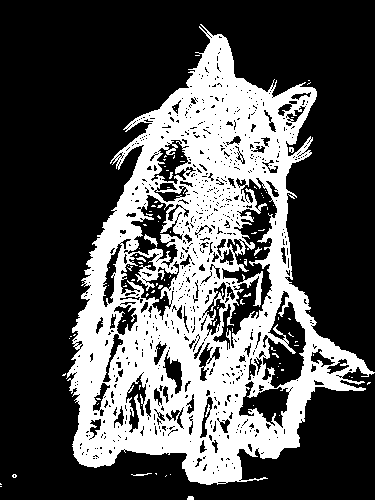

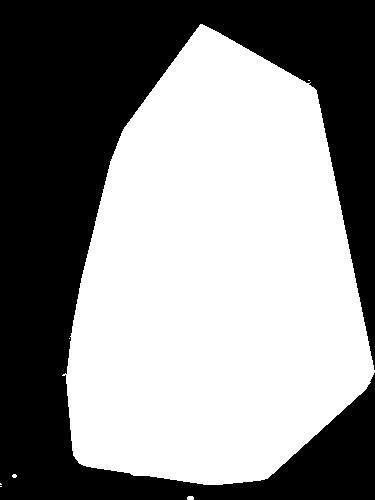

Processing file chihuahua_38.jpg


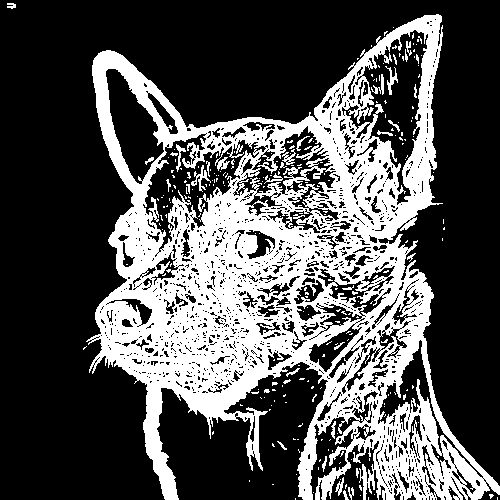

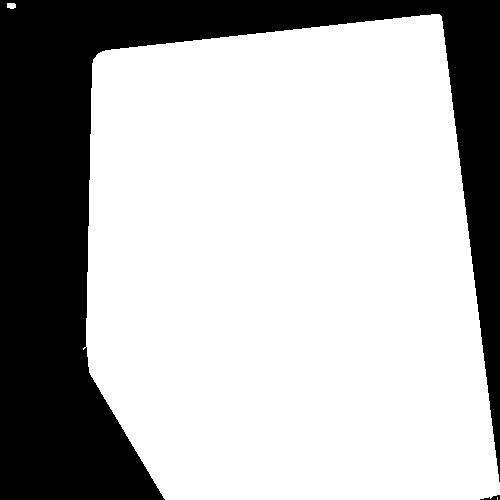

Processing file english_setter_96.jpg


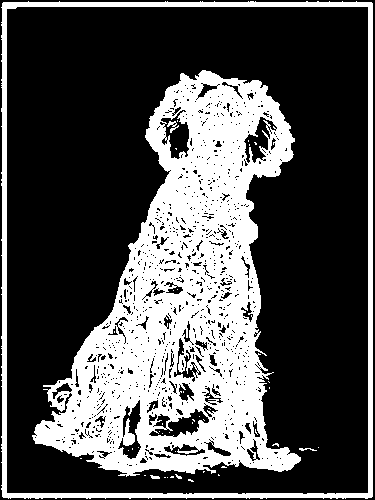

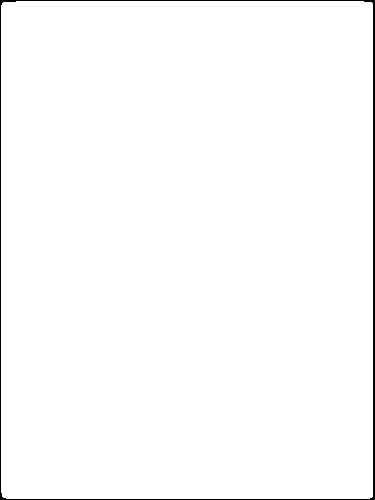

Processing file Maine_Coon_3.jpg


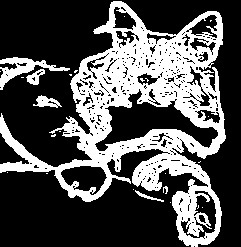

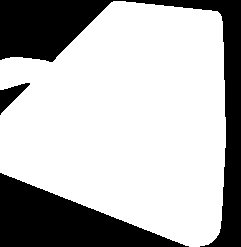

Processing file Russian_Blue_24.jpg


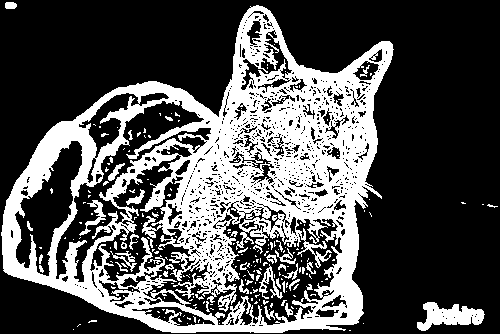

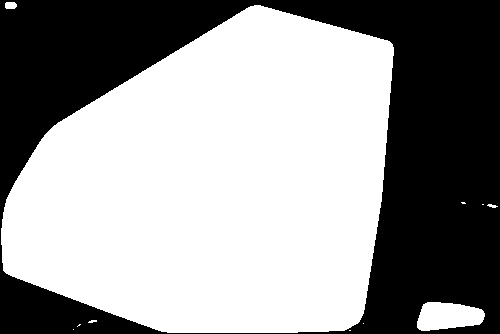

Processing file Abyssinian_19.jpg


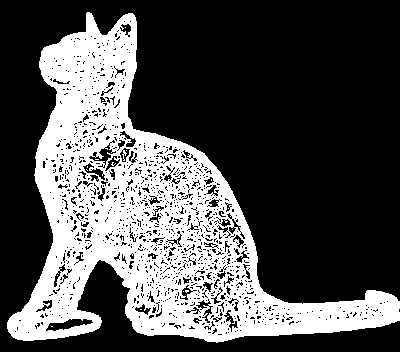

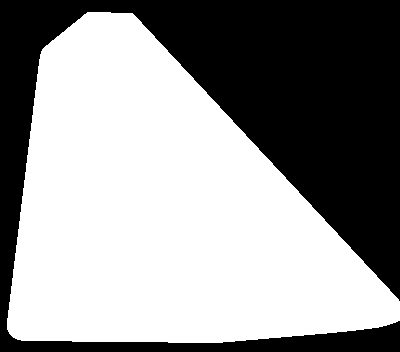

Processing file shiba_inu_72.jpg


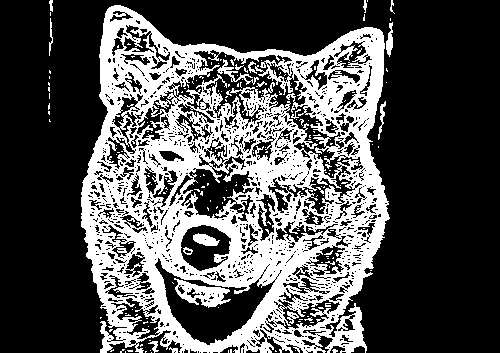

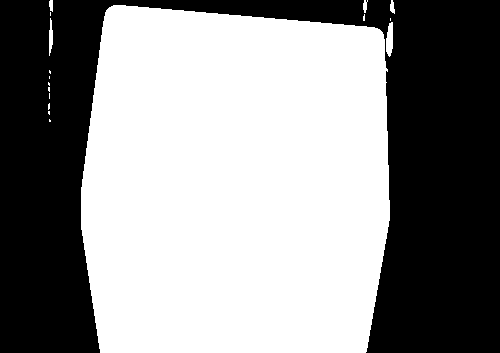

Processing file British_Shorthair_186.jpg


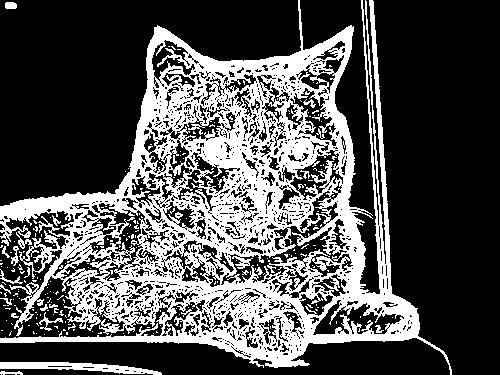

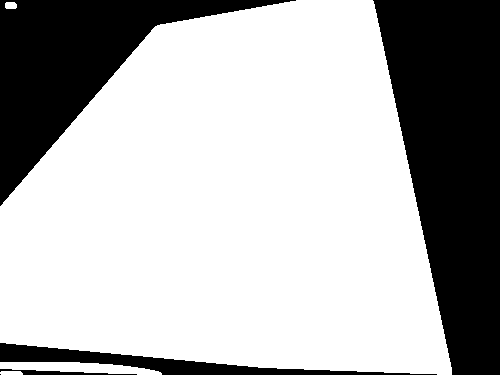

Processing file Sphynx_33.jpg


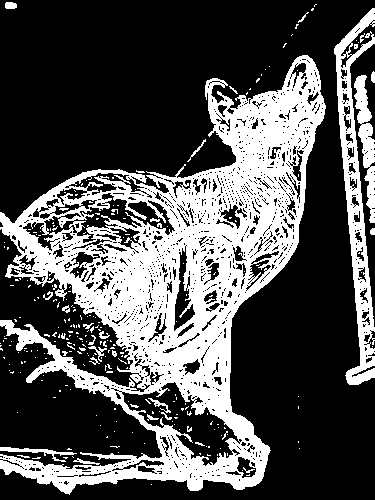

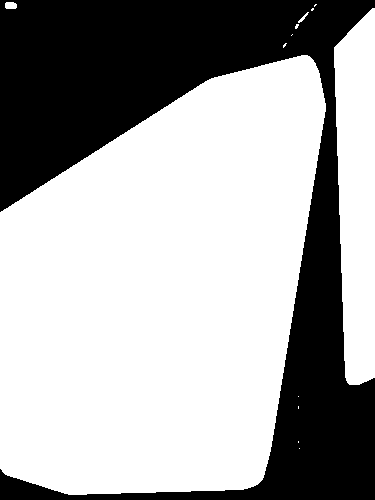

Processing file english_cocker_spaniel_10.jpg


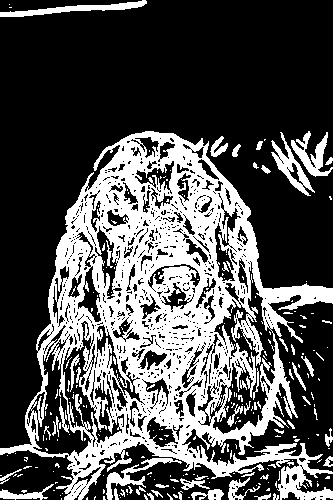

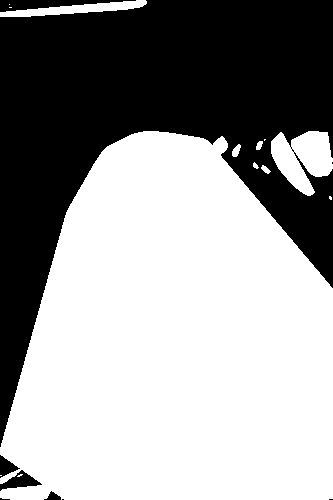

Processing file boxer_27.jpg


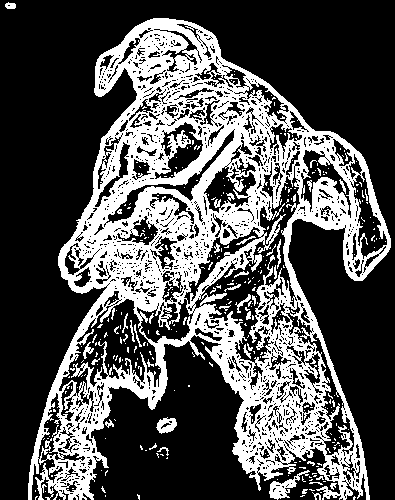

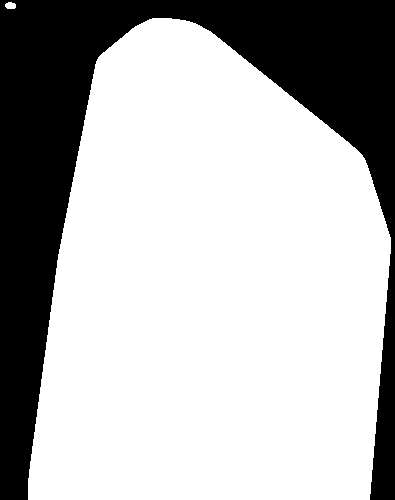

Processing file american_bulldog_199.jpg


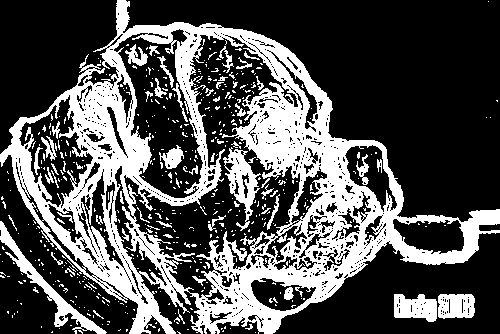

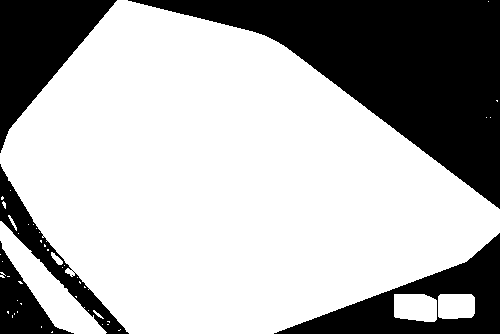

Processing file Russian_Blue_180.jpg


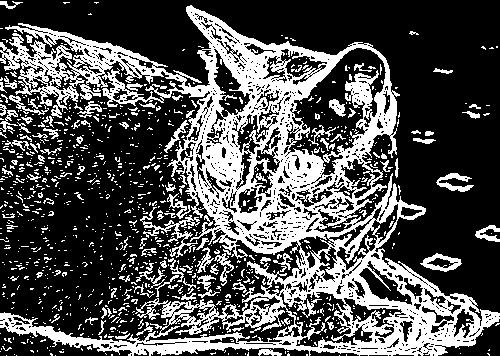

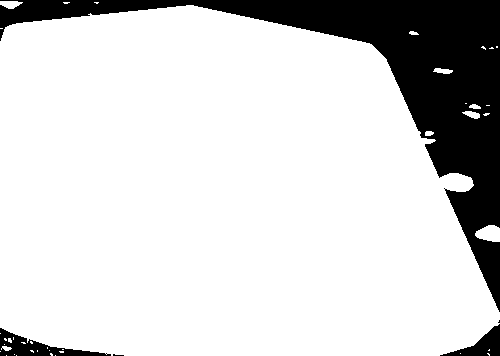

Processing file pug_97.jpg


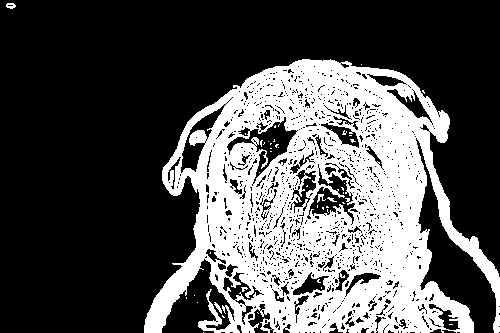

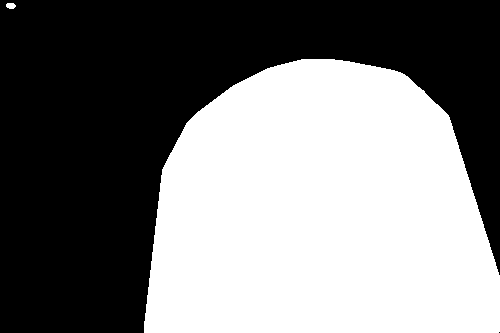

Processing file British_Shorthair_72.jpg


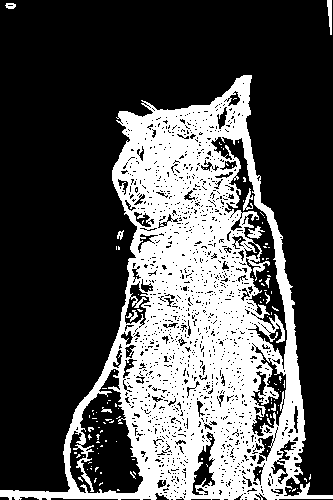

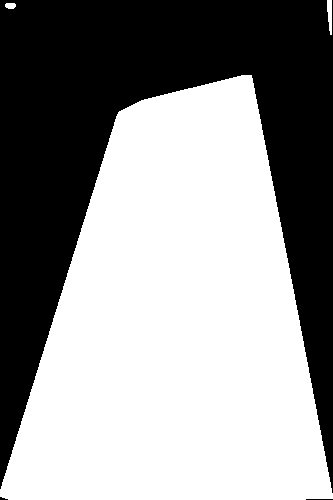

Processing file Russian_Blue_8.jpg


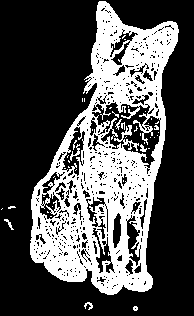

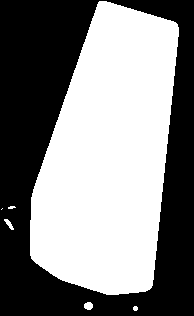

Processing file Maine_Coon_264.jpg


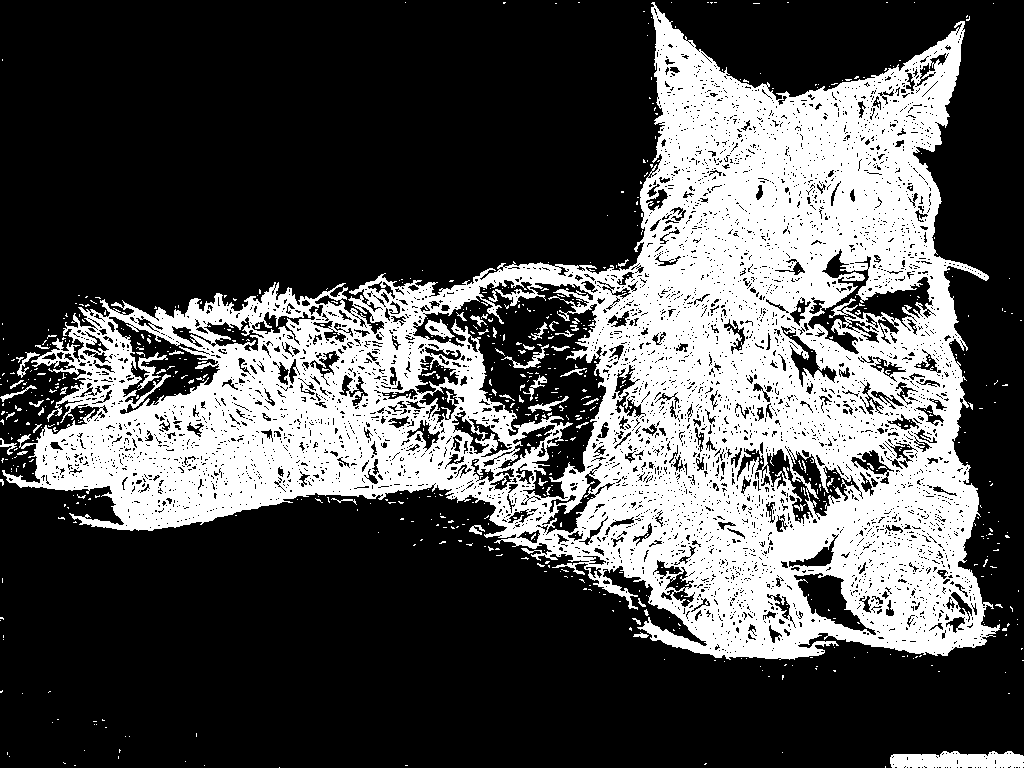

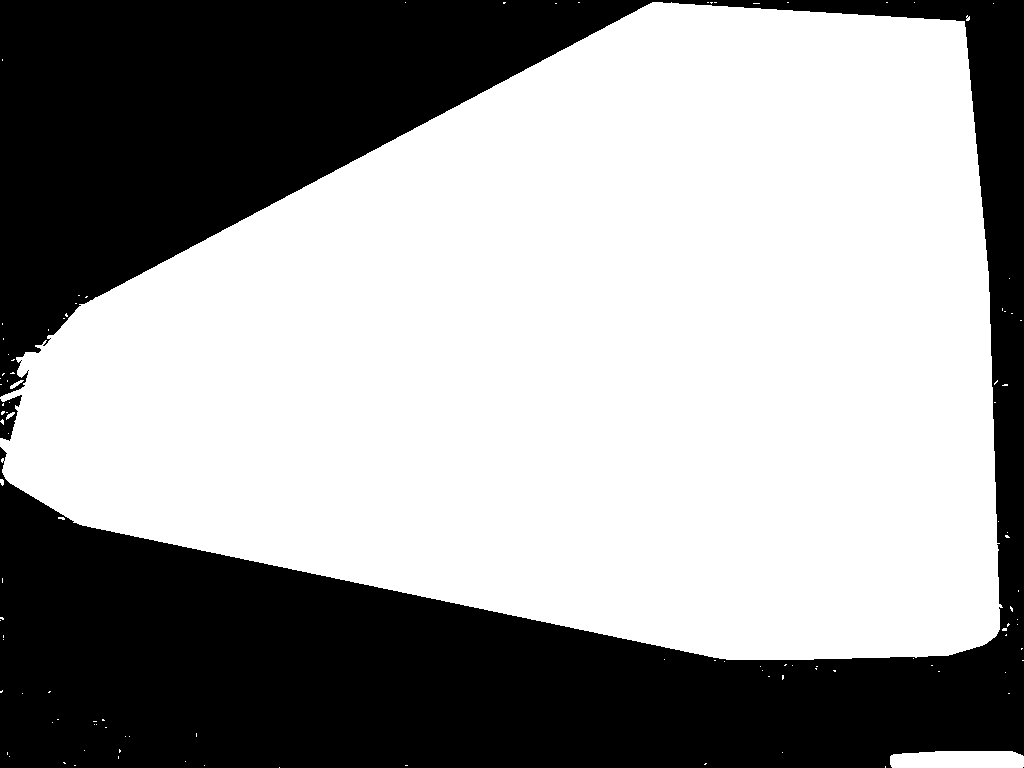

Processing file staffordshire_bull_terrier_41.jpg


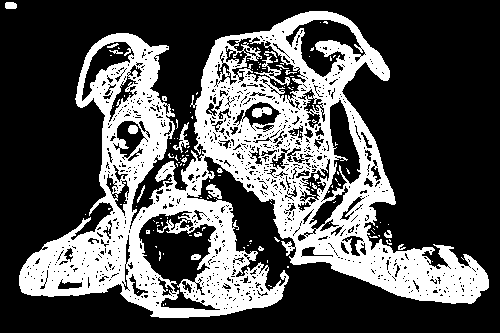

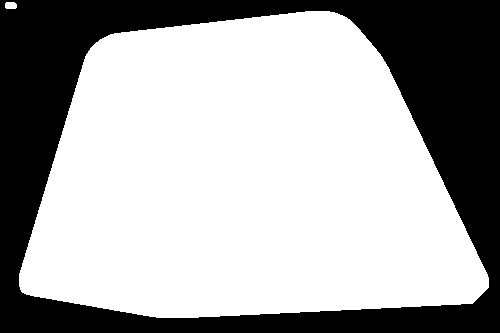

Processing file Maine_Coon_43.jpg


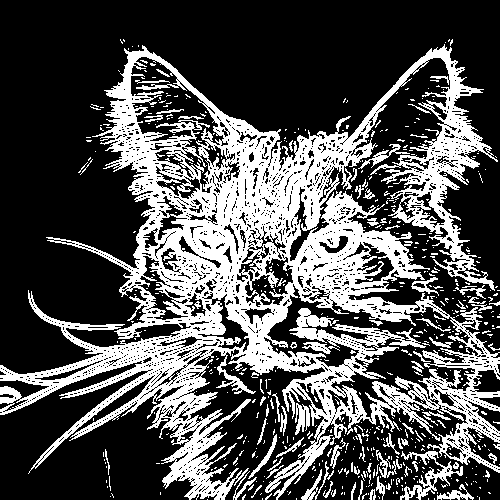

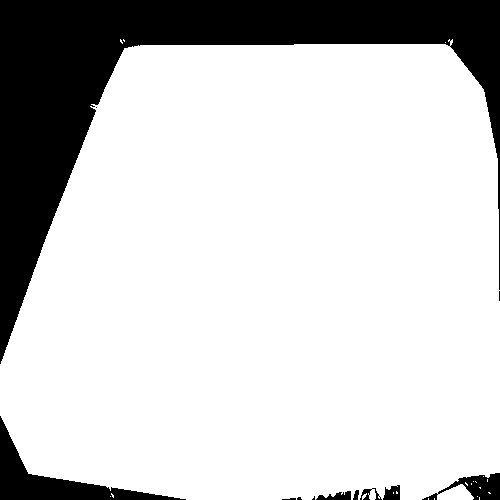

Processing file Bengal_103.jpg


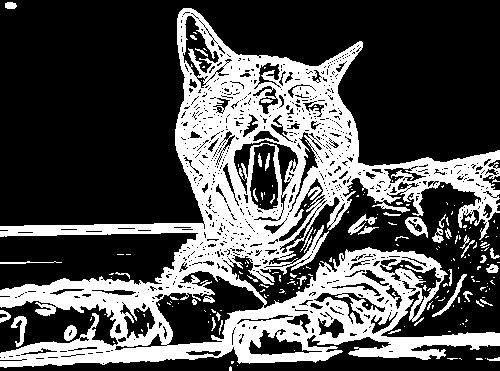

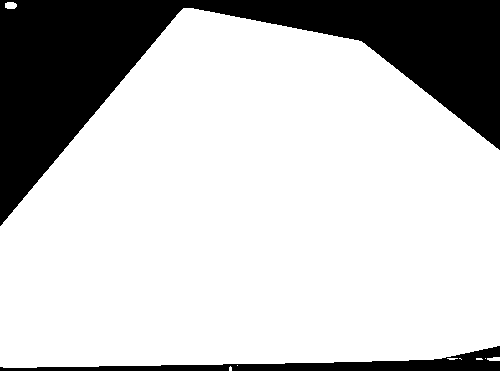

Processing file leonberger_24.jpg


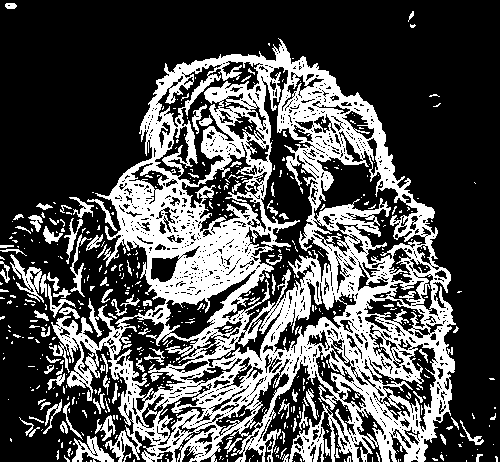

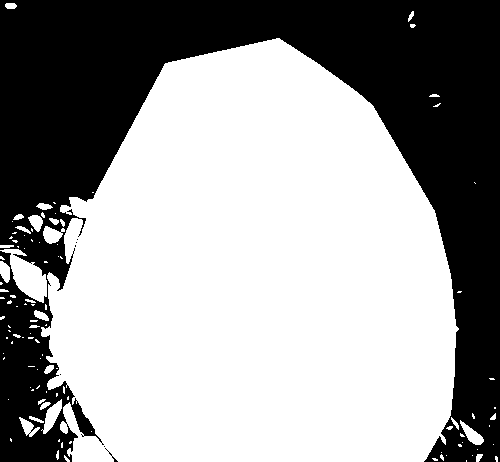

Processing file Egyptian_Mau_155.jpg


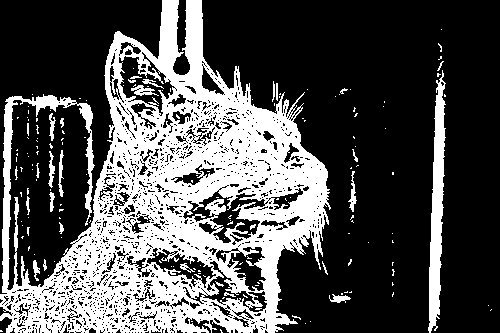

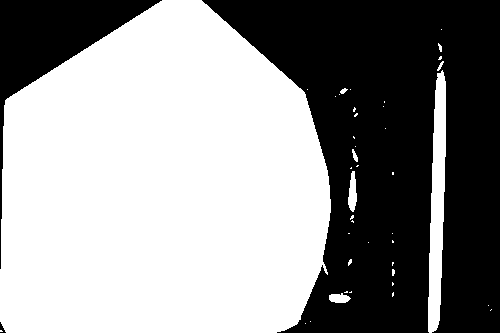

Processing file Persian_7.jpg


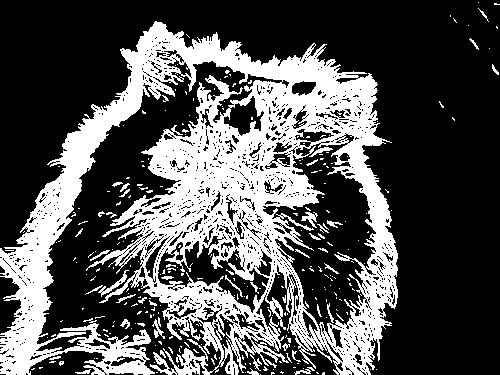

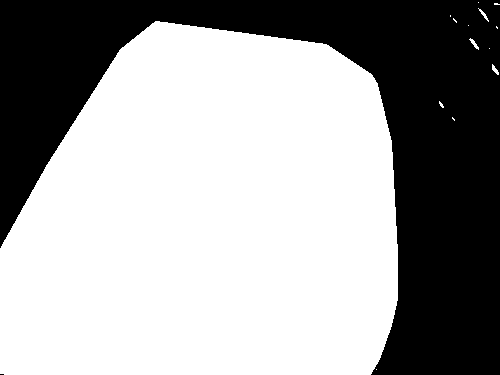

Processing file Persian_255.jpg


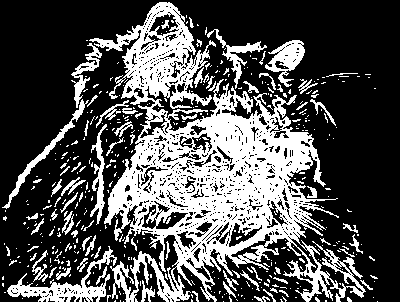

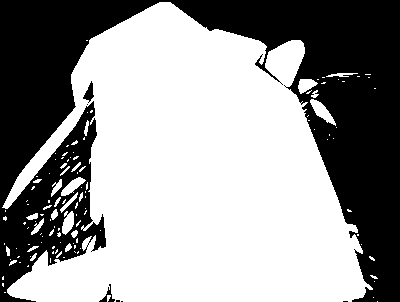

Processing file Russian_Blue_95.jpg


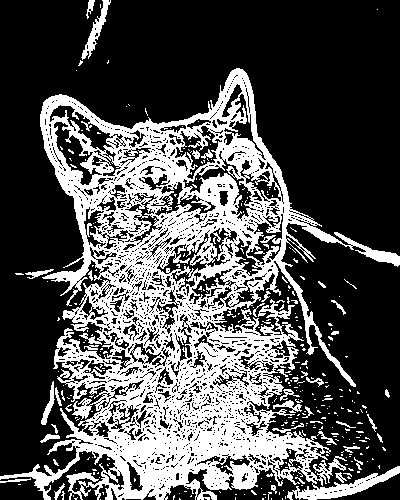

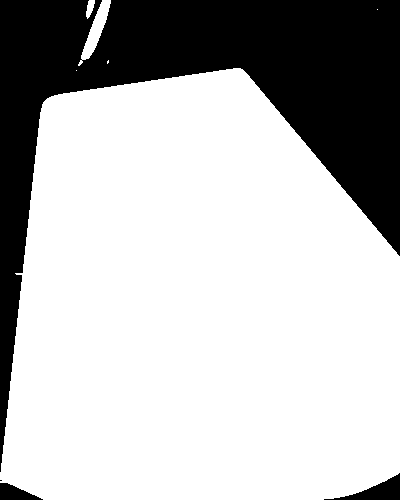

Processing file english_cocker_spaniel_68.jpg


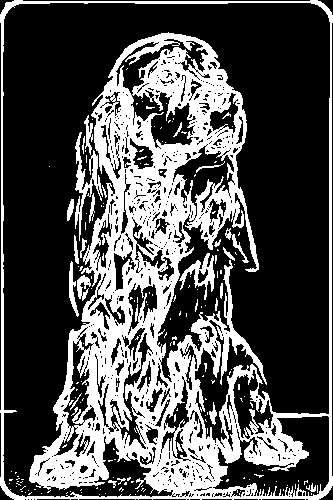

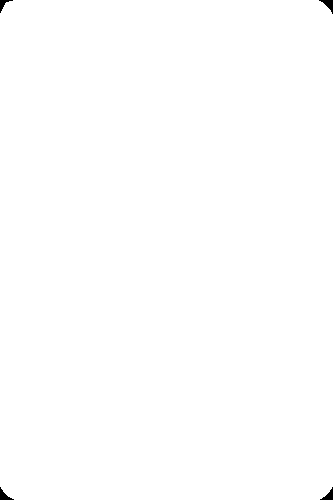

Processing file British_Shorthair_180.jpg


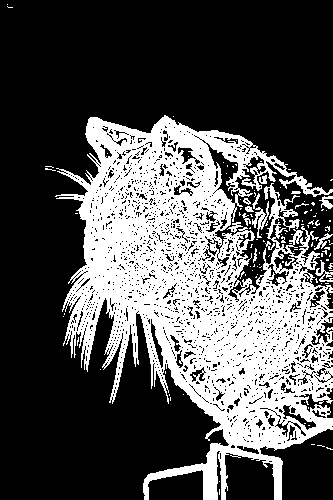

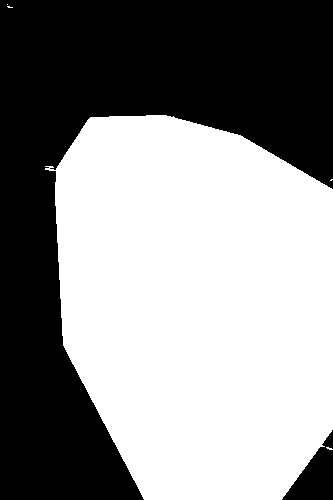

Processing file British_Shorthair_2.jpg


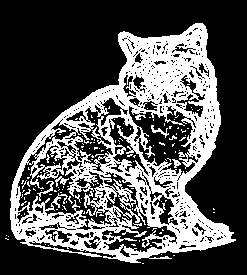

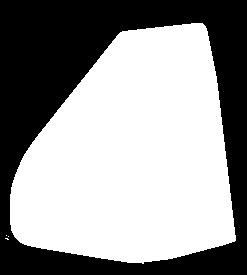

Processing file english_setter_42.jpg


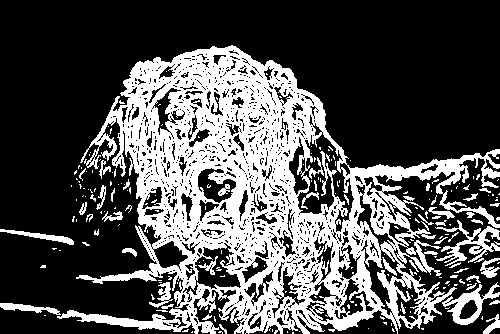

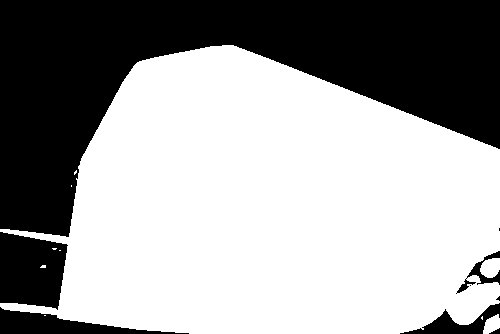

Processing file Persian_152.jpg


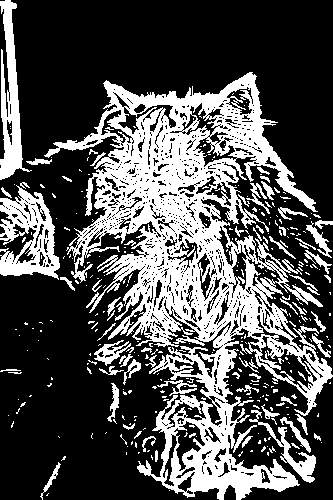

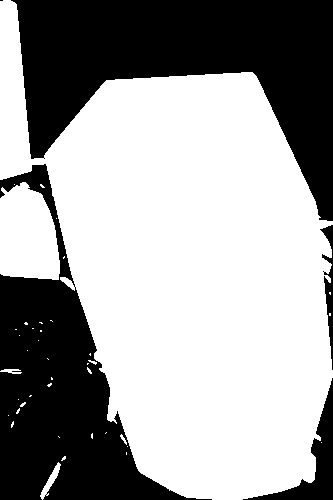

Processing file shiba_inu_131.jpg


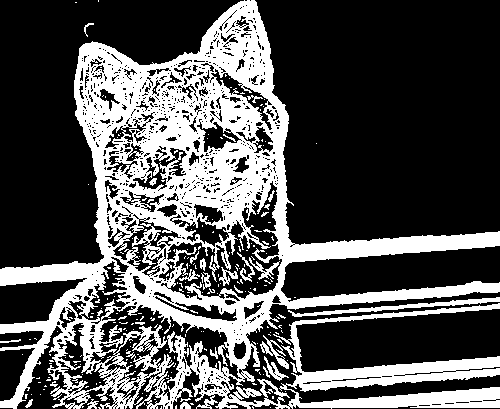

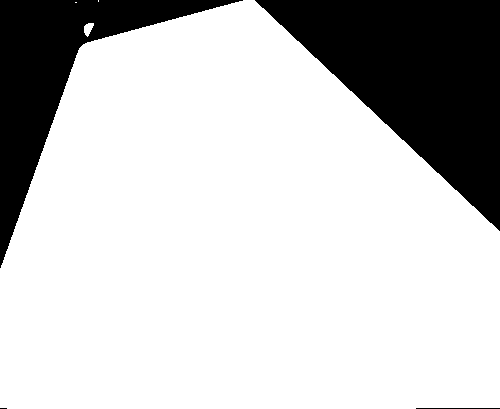

Processing file saint_bernard_50.jpg


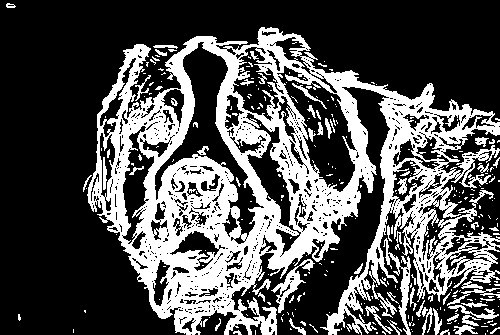

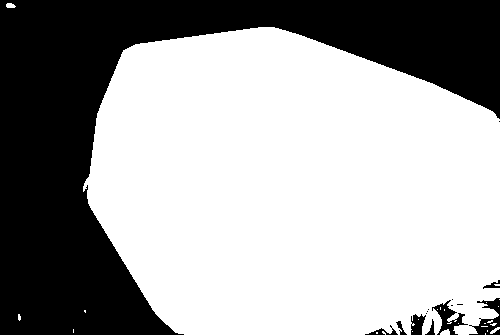

Processing file boxer_17.jpg


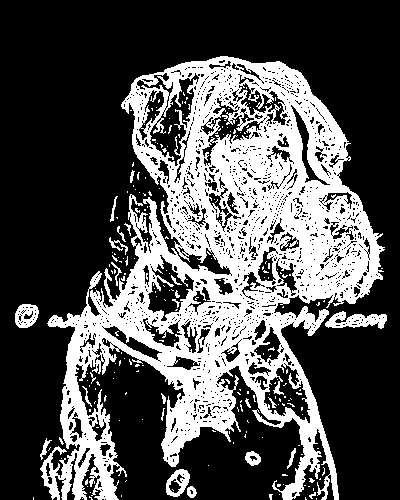

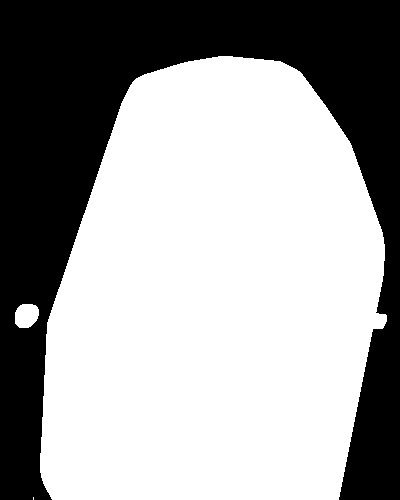

Processing file Russian_Blue_212.jpg


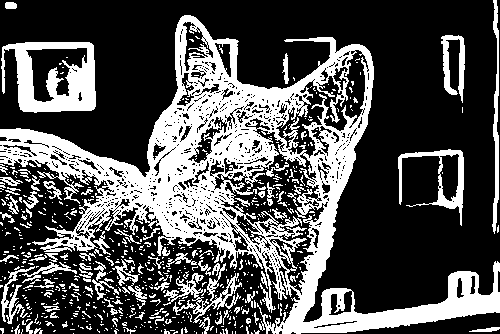

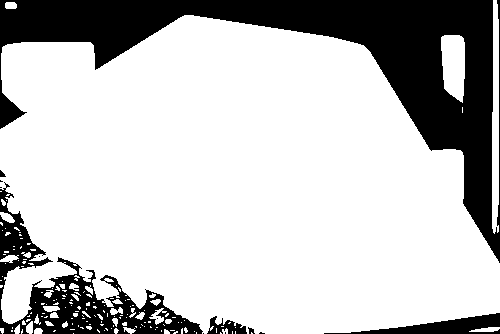

Processing file Bombay_48.jpg


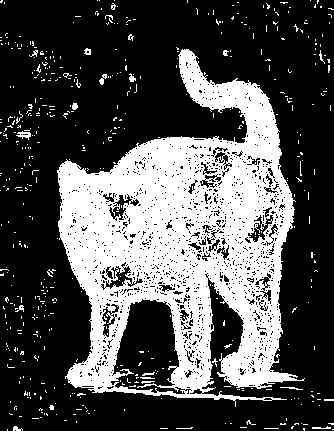

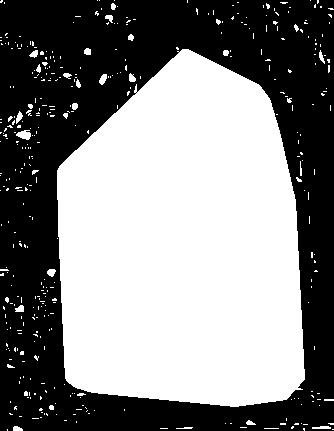

Processing file Bombay_16.jpg


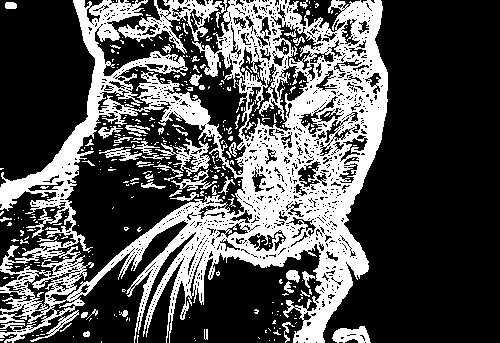

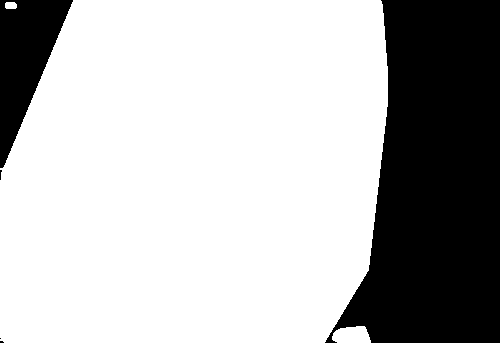

Processing file wheaten_terrier_1.jpg


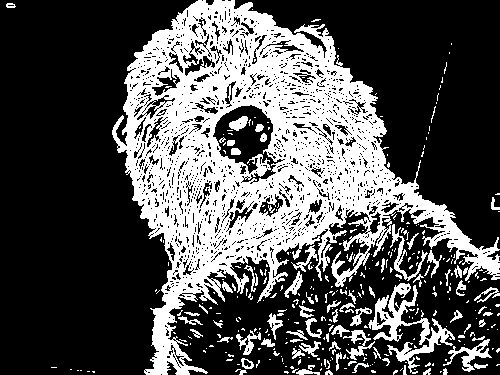

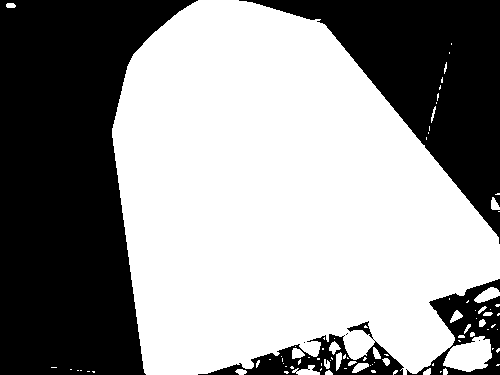

Processing file Sphynx_72.jpg


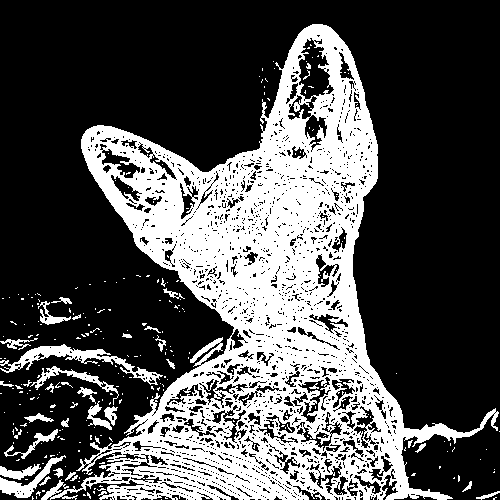

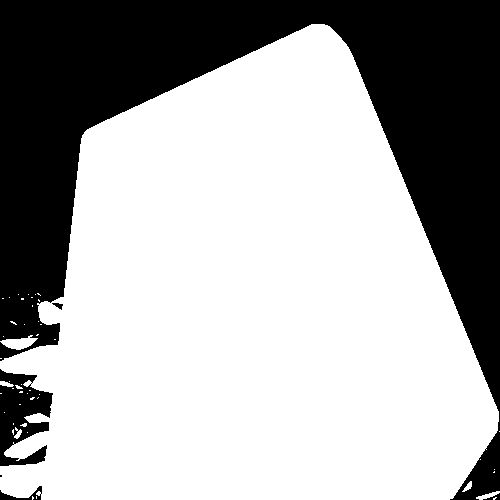

Processing file Russian_Blue_35.jpg


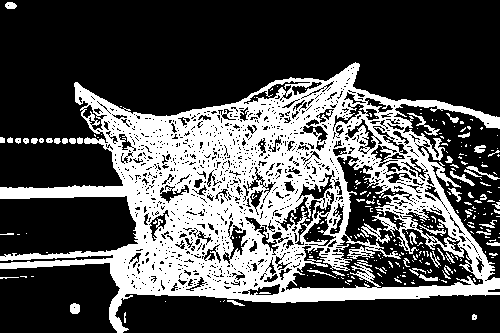

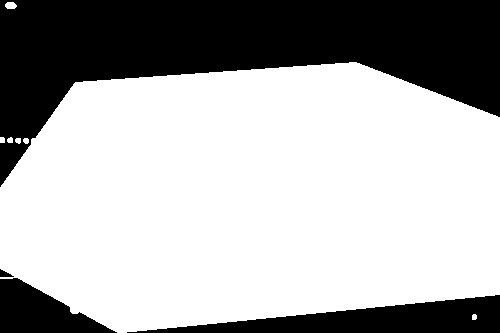

Processing file Siamese_240.jpg


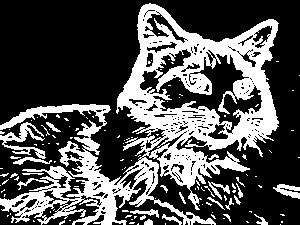

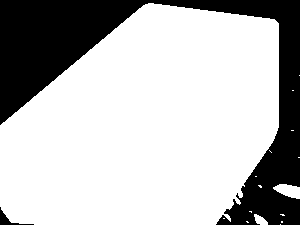

Processing file chihuahua_19.jpg


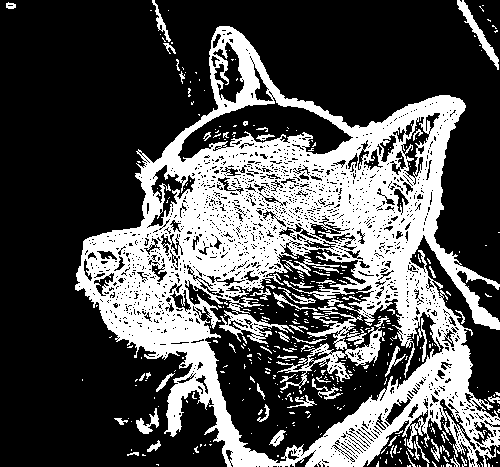

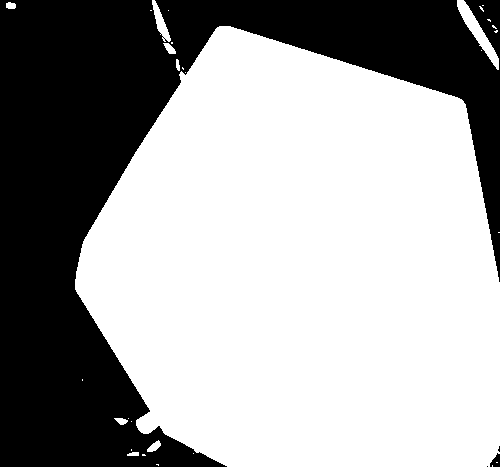

Processing file British_Shorthair_40.jpg


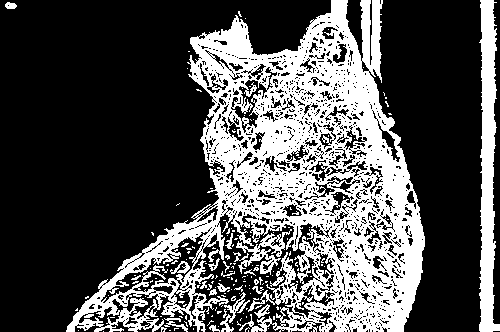

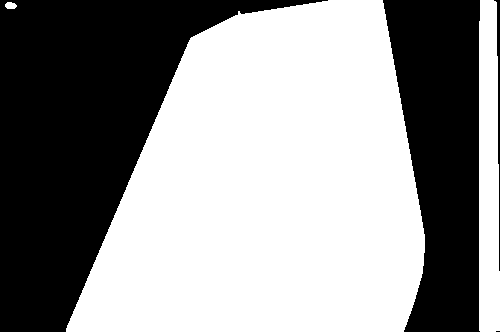

Processing file staffordshire_bull_terrier_67.jpg


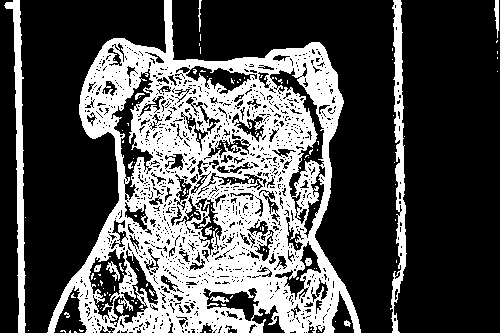

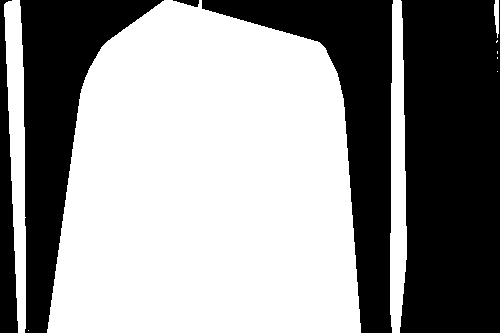

Processing file Abyssinian_9.jpg


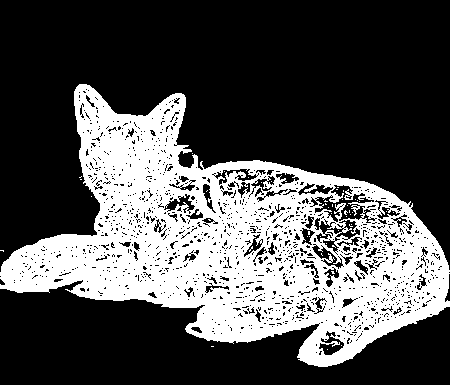

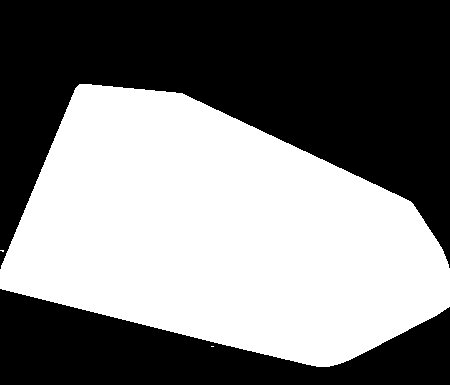

Processing file Persian_4.jpg


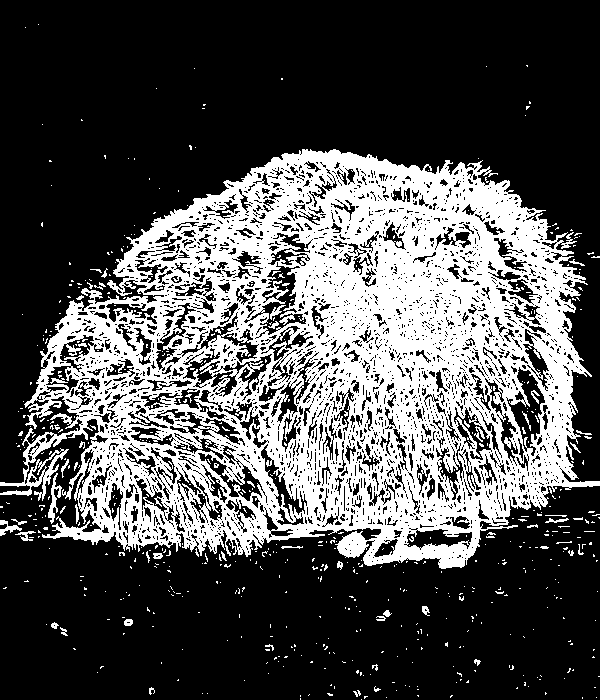

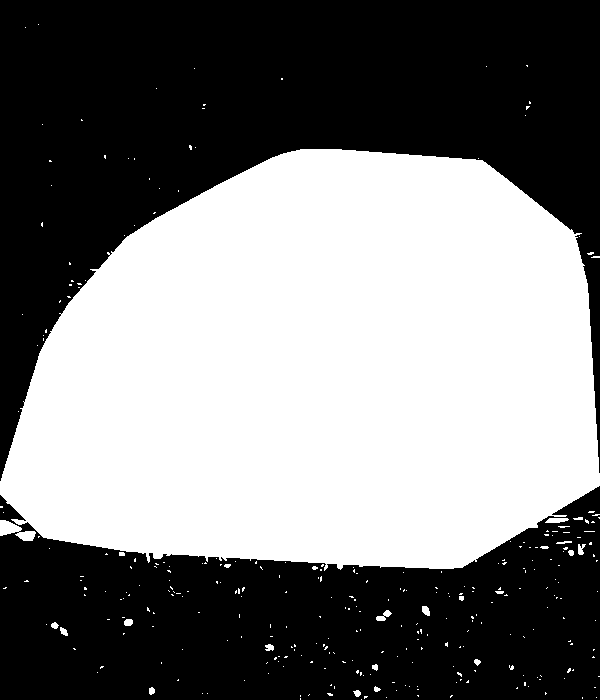

Processing file Maine_Coon_89.jpg


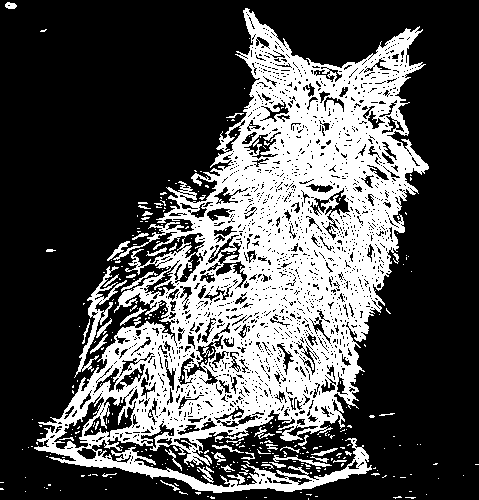

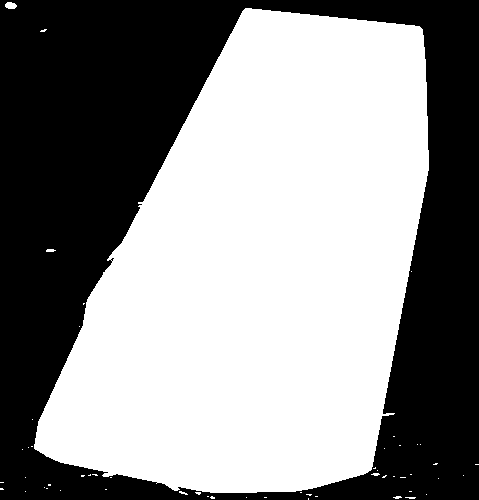

Processing file basset_hound_118.jpg


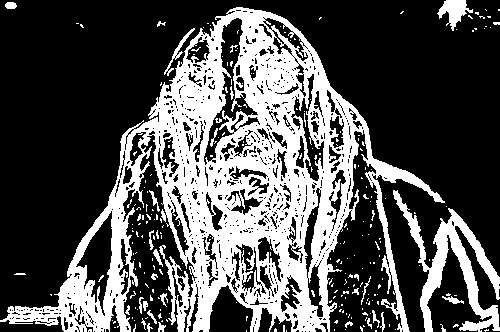

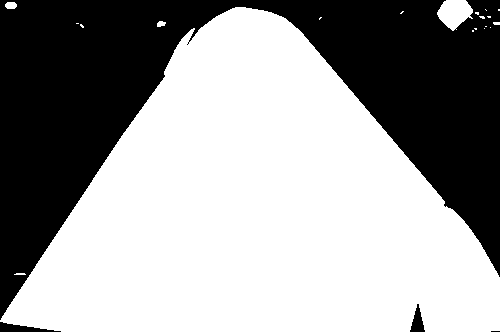

Processing file Egyptian_Mau_187.jpg


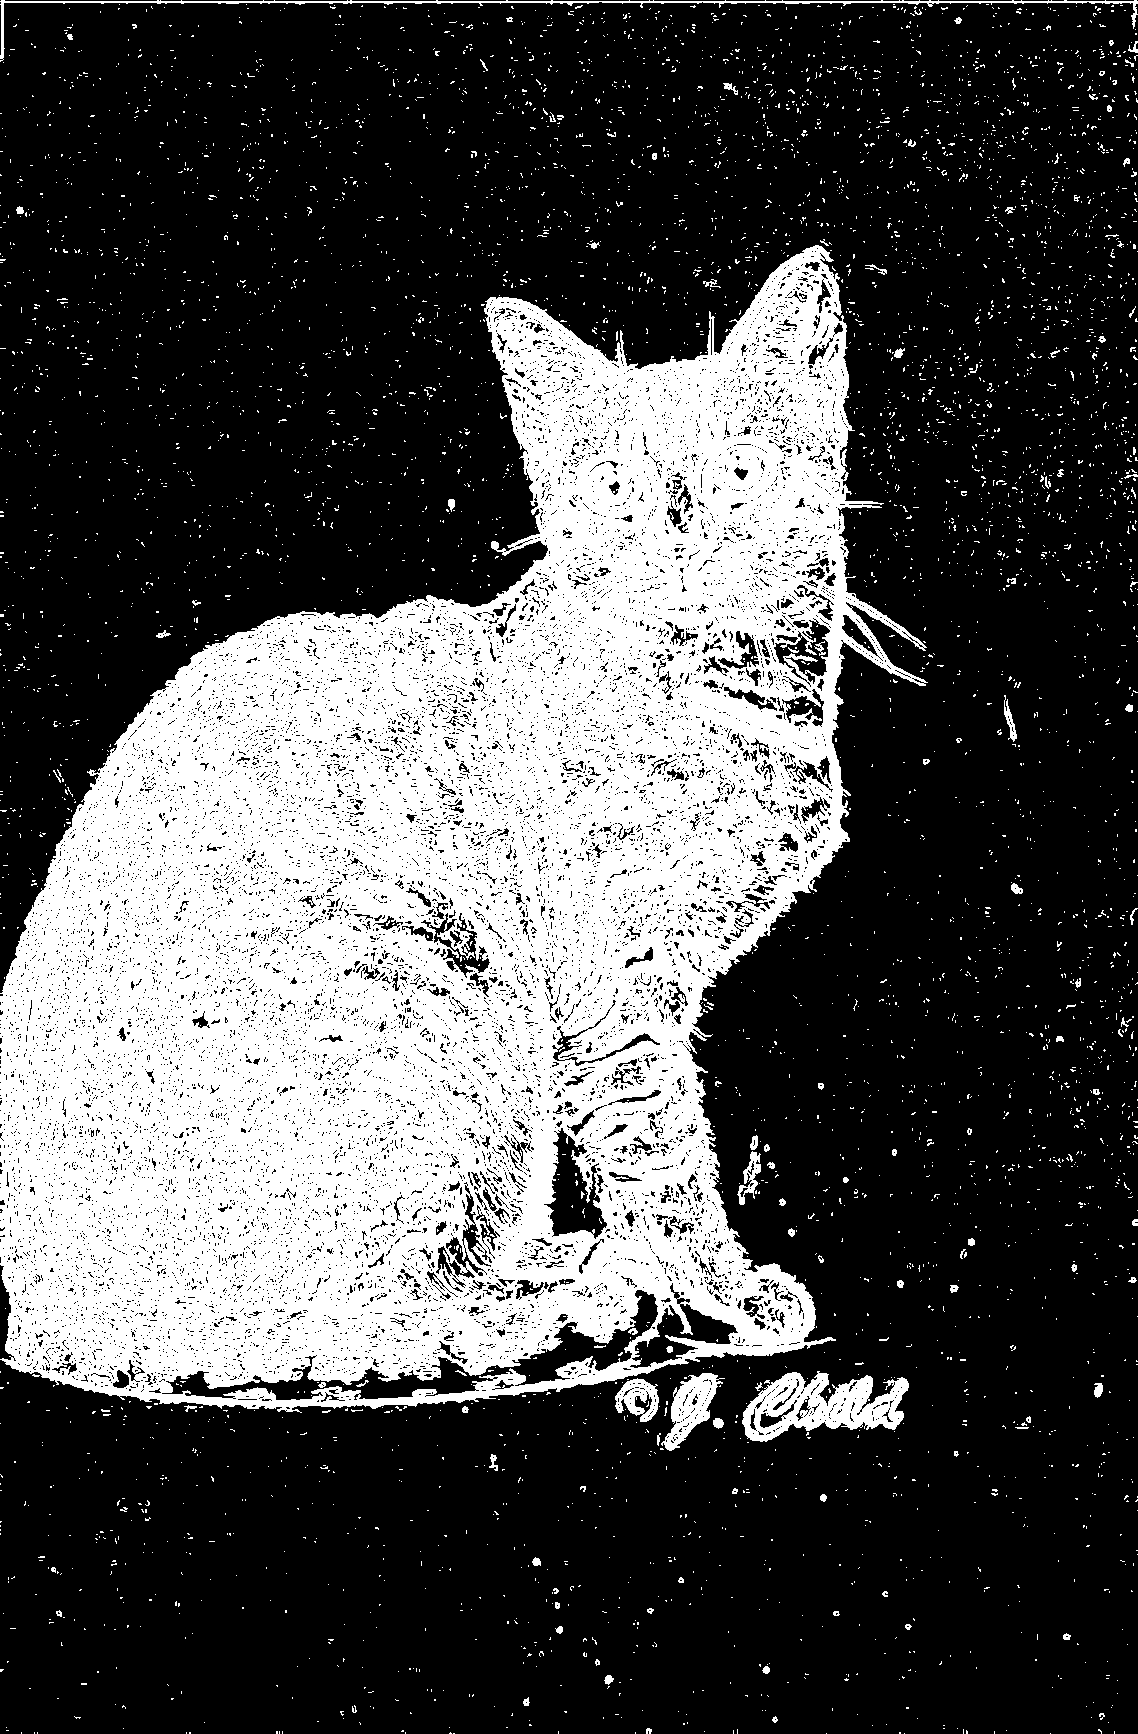

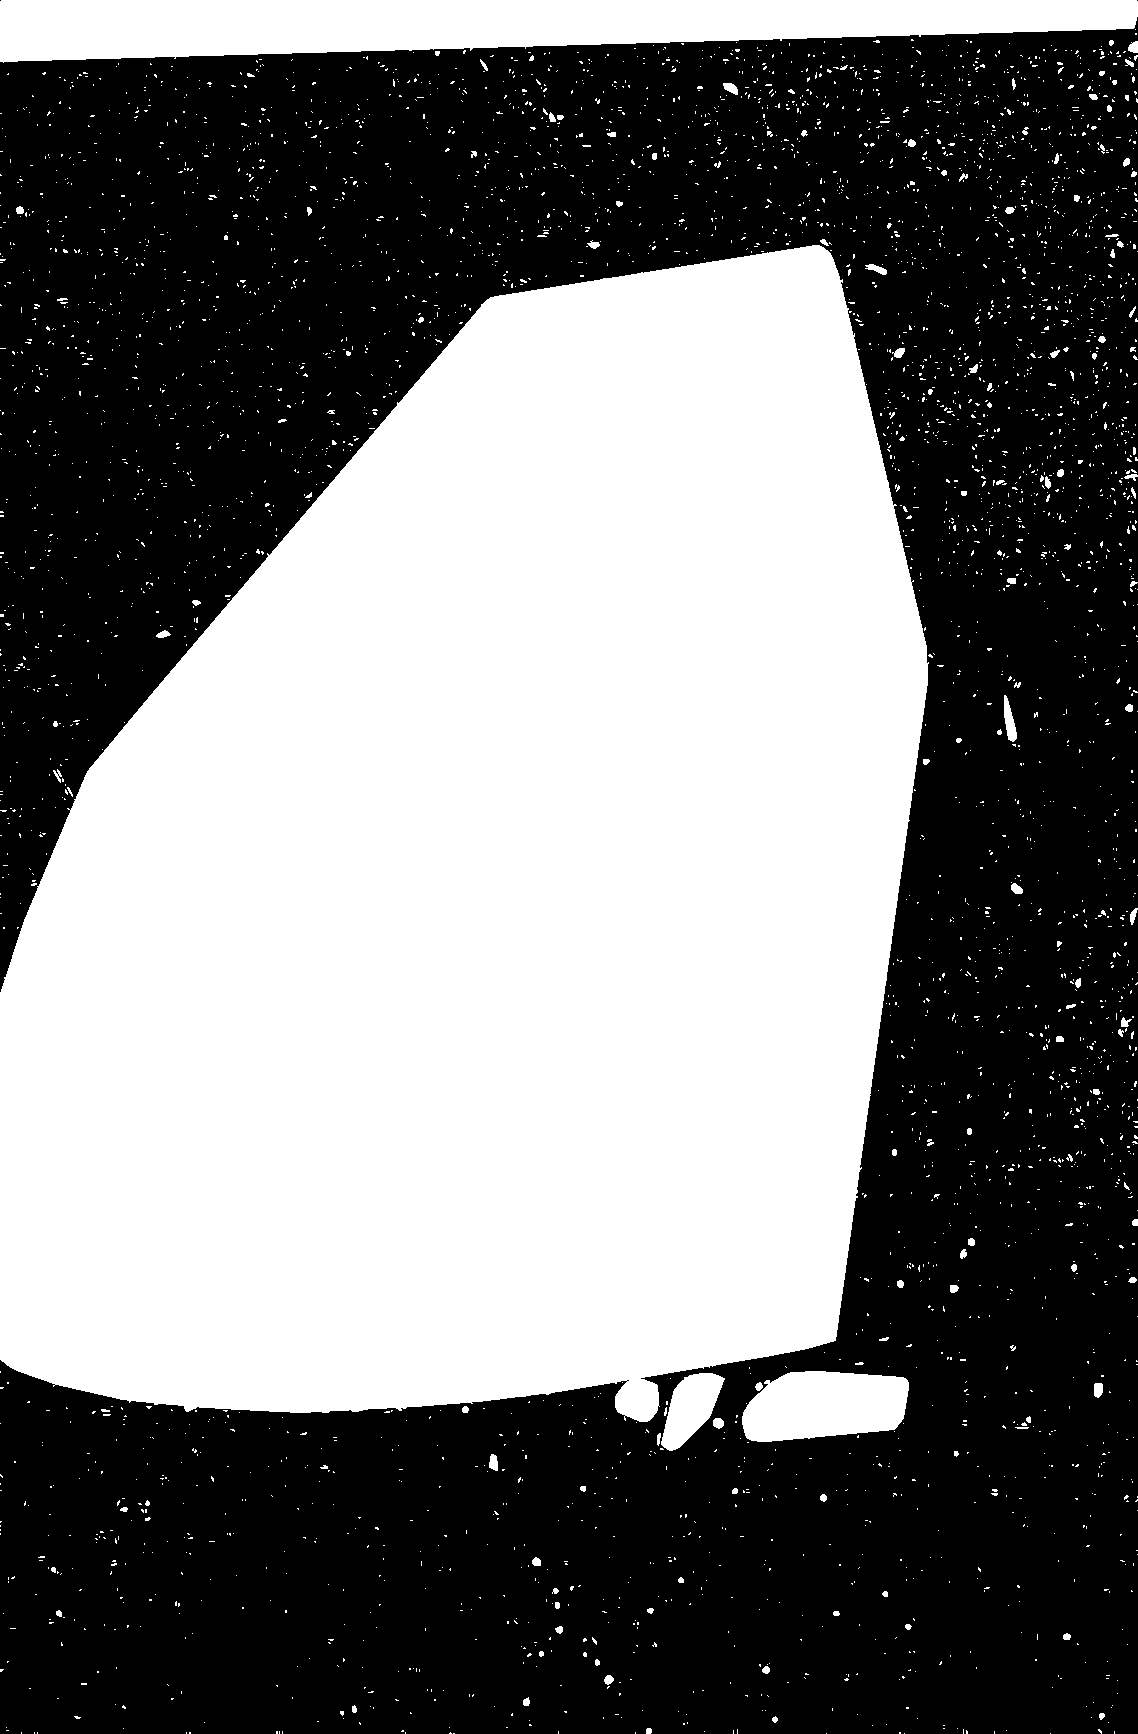

Processing file Birman_31.jpg


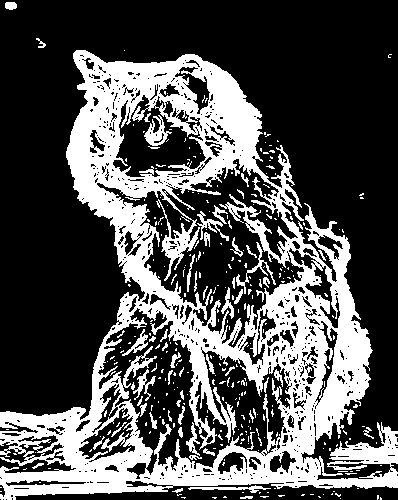

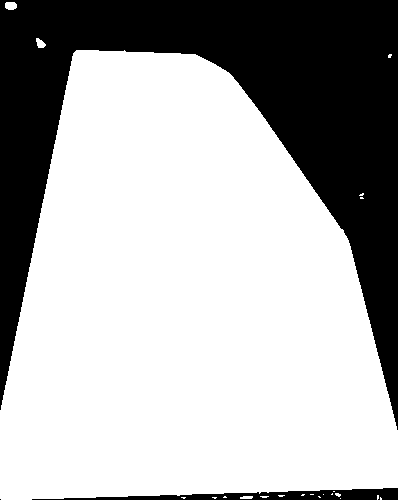

Processing file Abyssinian_44.jpg


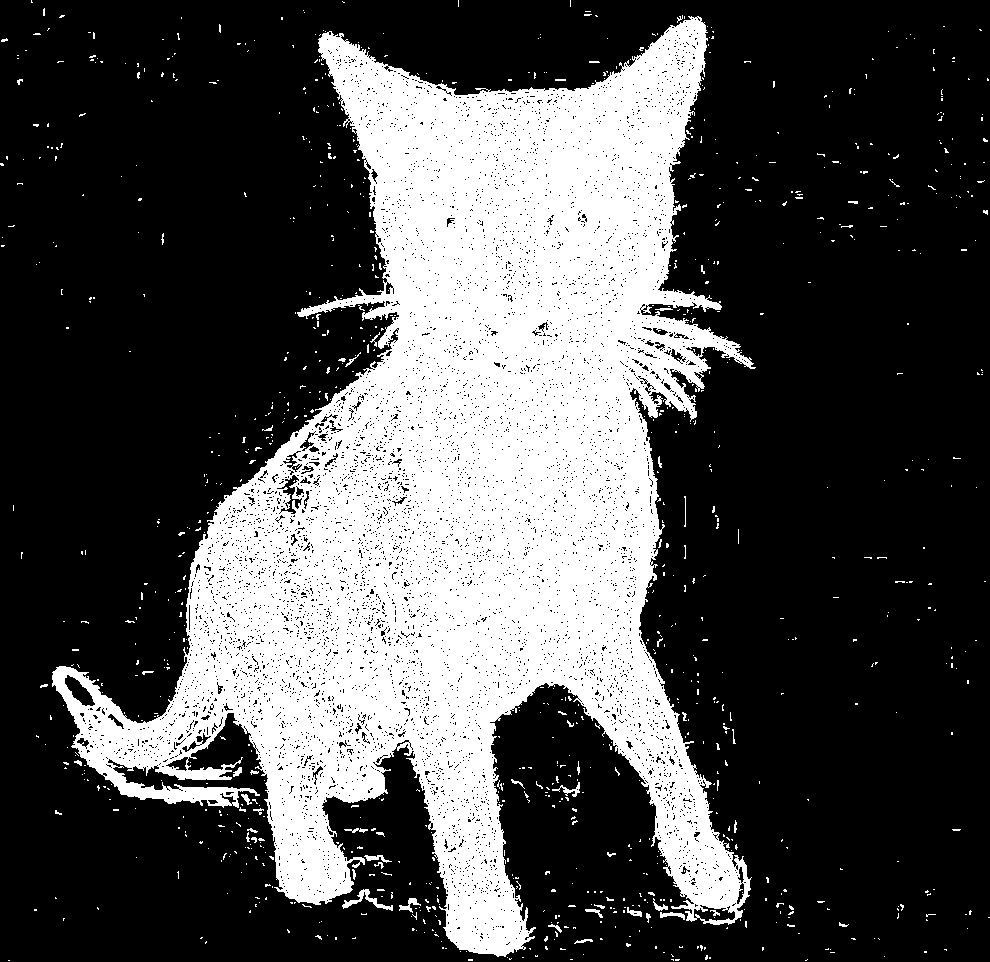

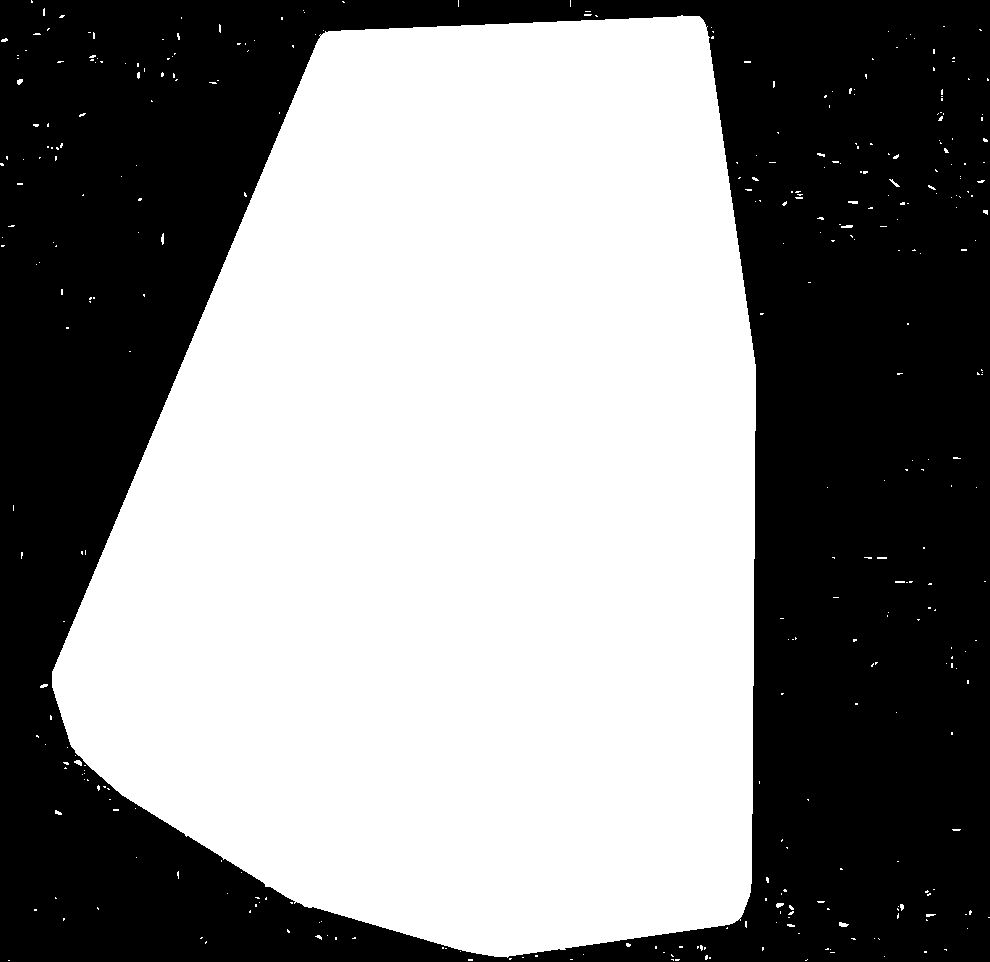

Processing file yorkshire_terrier_82.jpg


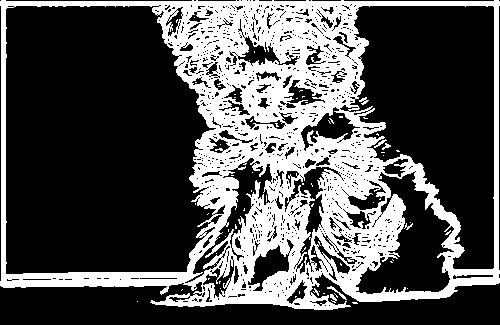

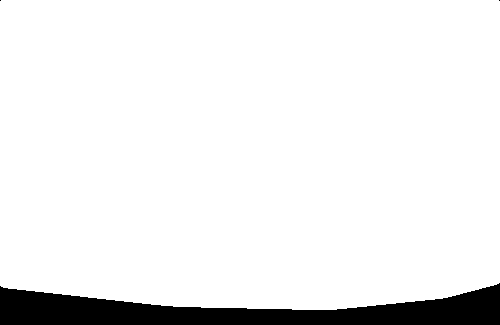

Processing file english_cocker_spaniel_144.jpg


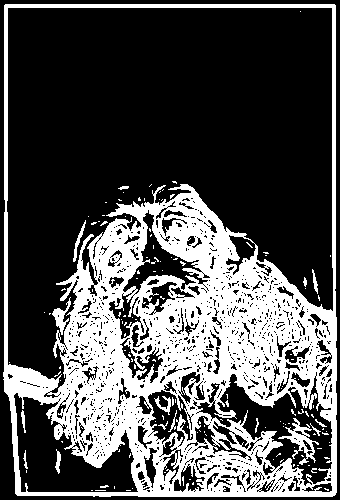

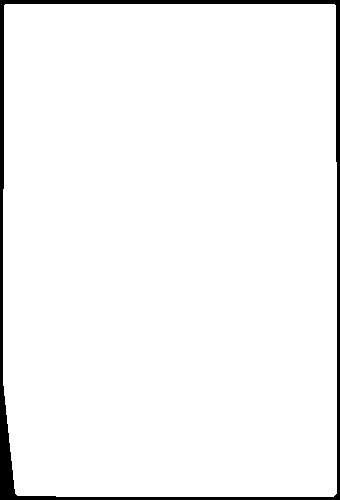

Processing file Egyptian_Mau_14.jpg


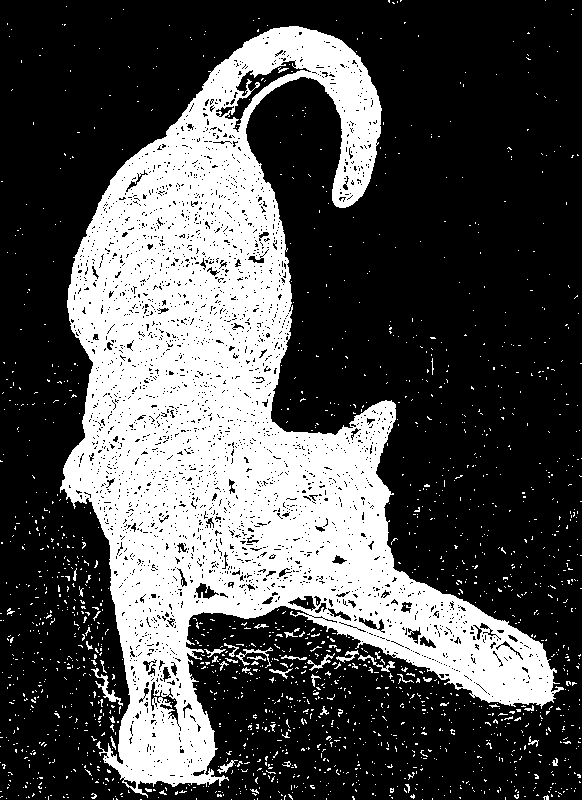

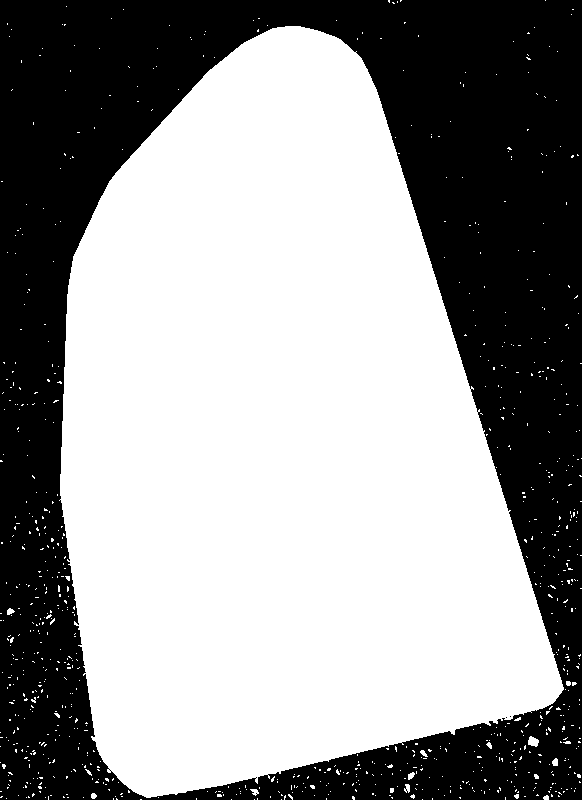

Processing file Siamese_189.jpg


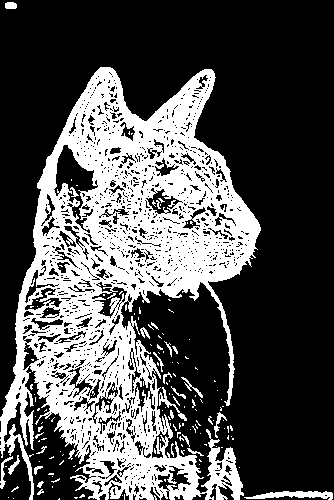

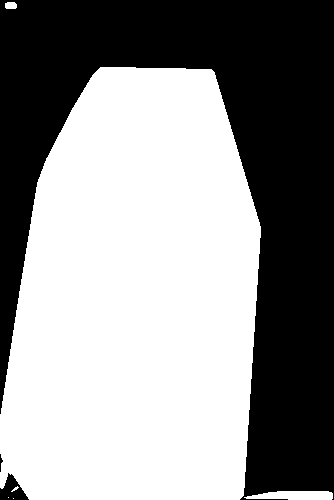

Processing file german_shorthaired_66.jpg


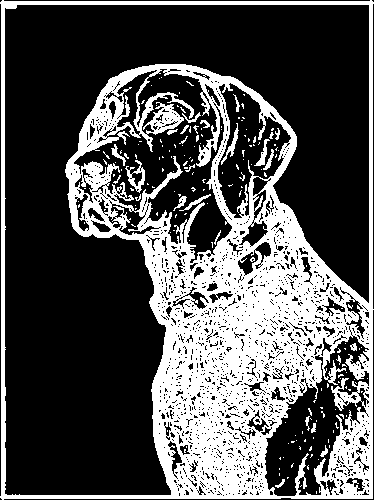

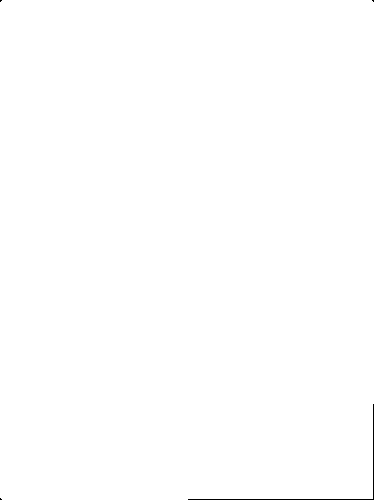

Processing file boxer_108.jpg


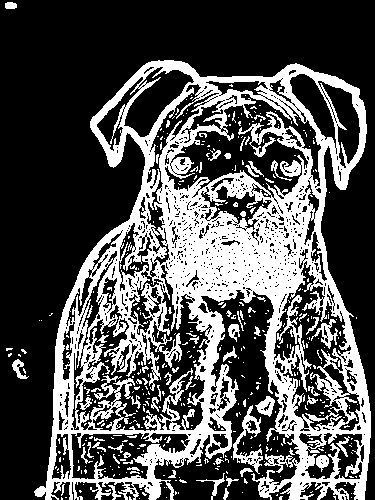

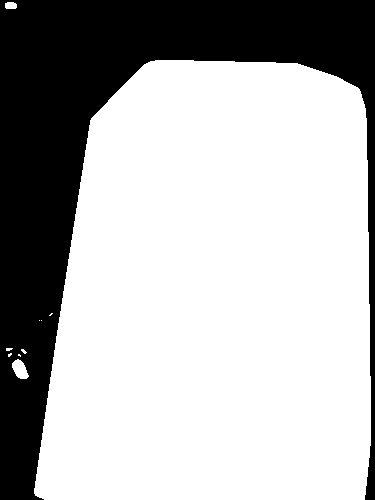

Processing file shiba_inu_140.jpg


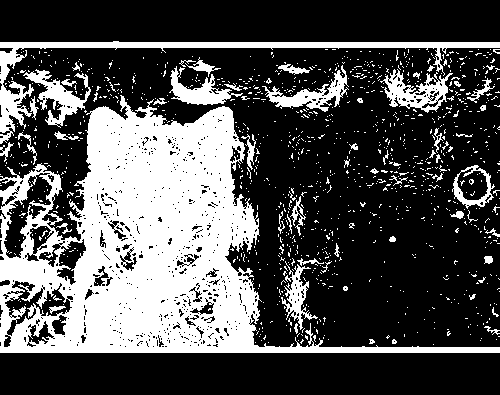

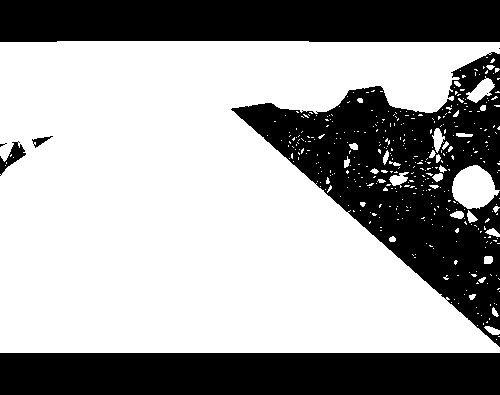

Processing file havanese_84.jpg


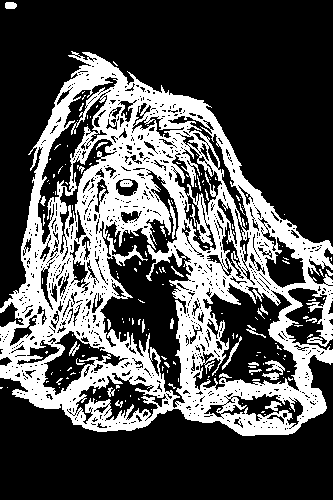

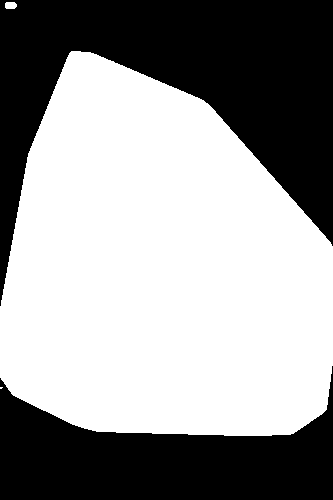

Processing file Russian_Blue_199.jpg


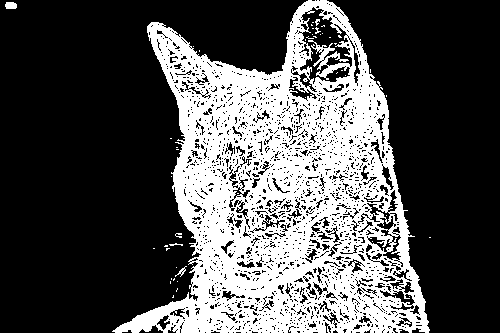

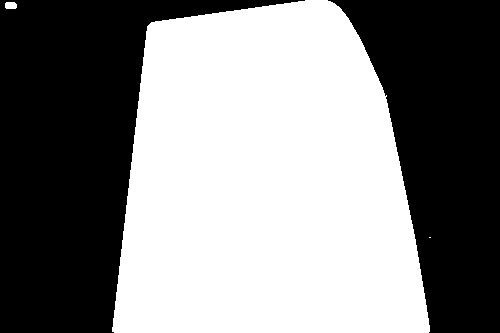

Processing file leonberger_189.jpg


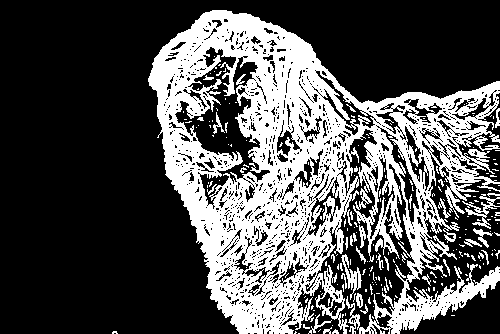

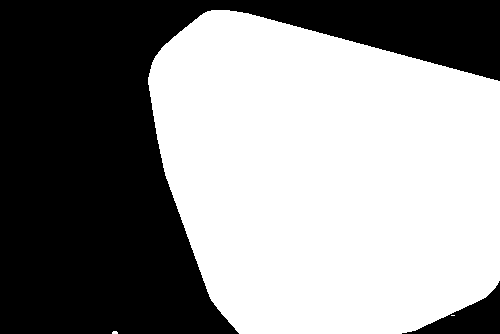

Processing file newfoundland_110.jpg


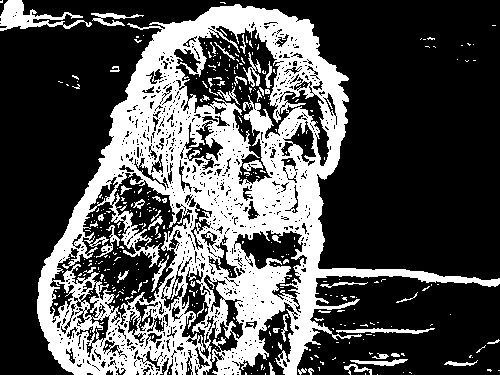

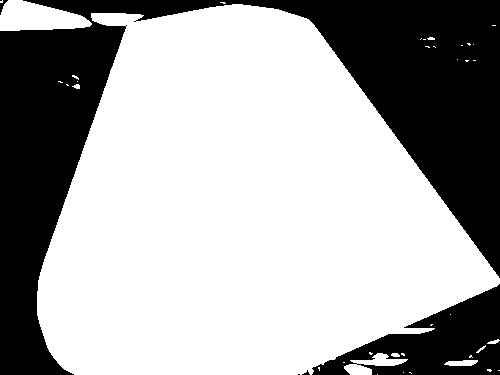

Processing file german_shorthaired_126.jpg


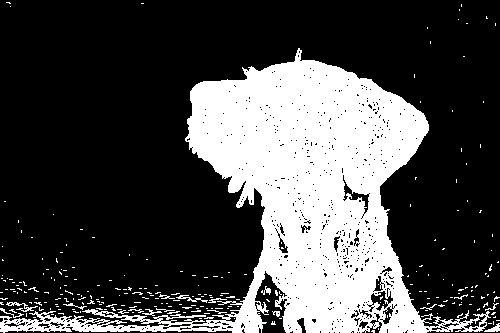

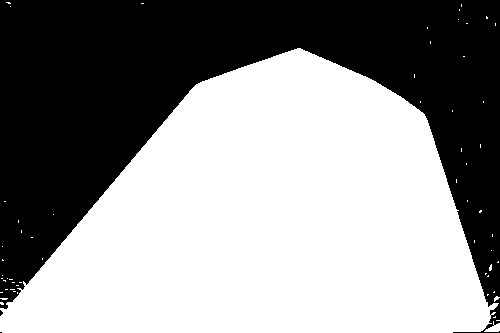

Processing file Sphynx_37.jpg


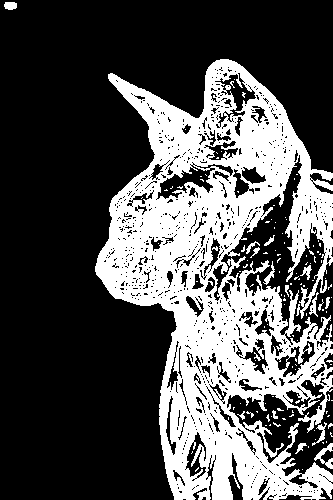

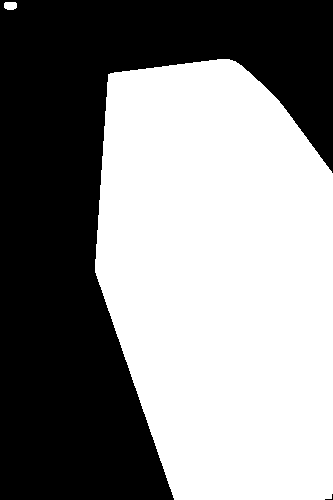

Processing file Sphynx_25.jpg


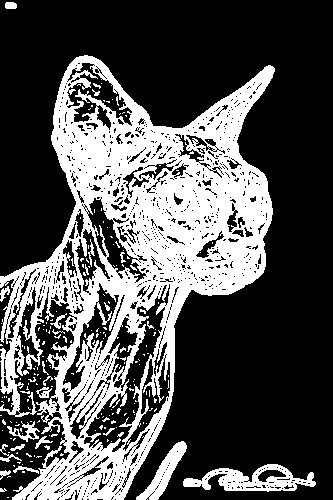

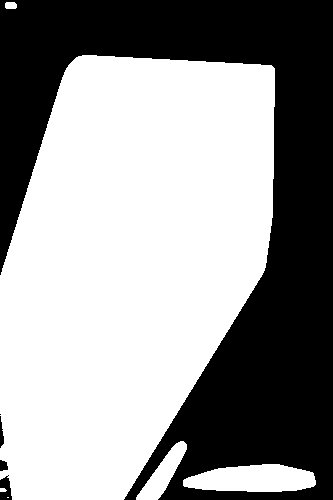

Processing file British_Shorthair_67.jpg


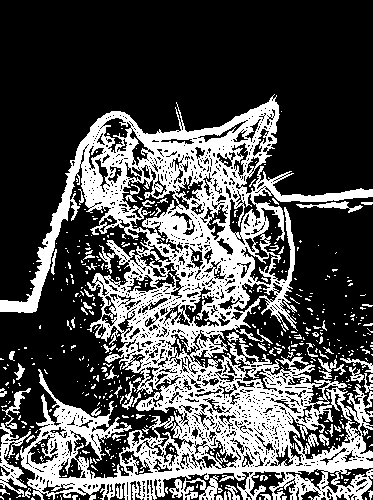

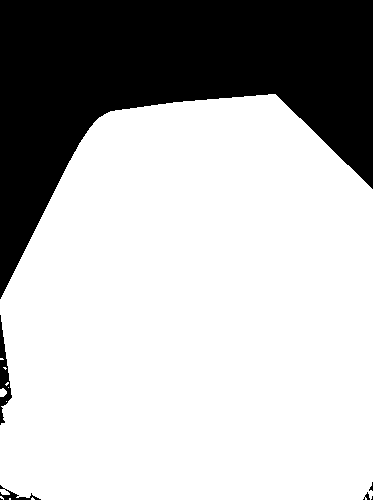

Processing file Abyssinian_31.jpg


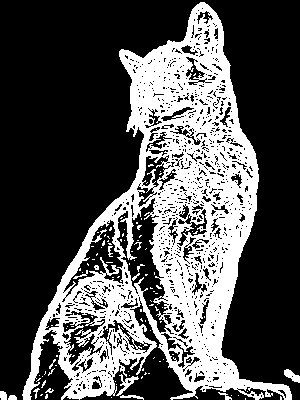

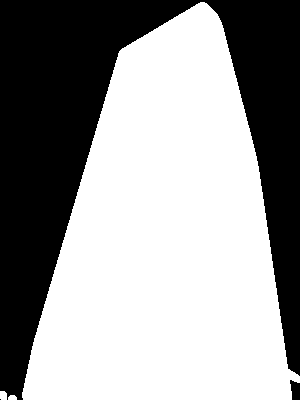

Processing file Persian_221.jpg


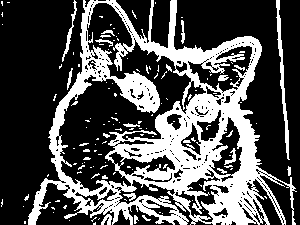

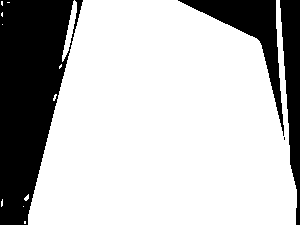

Processing file pug_65.jpg


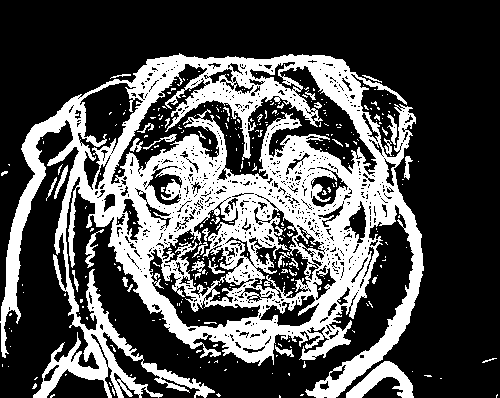

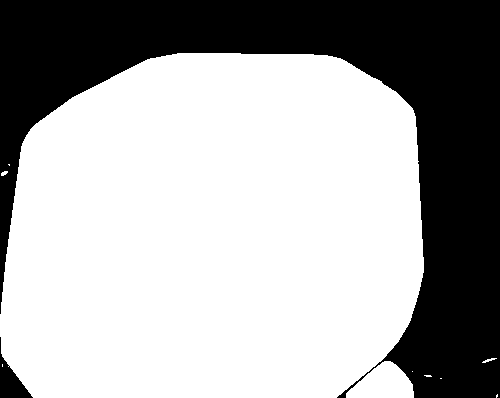

Processing file american_bulldog_95.jpg


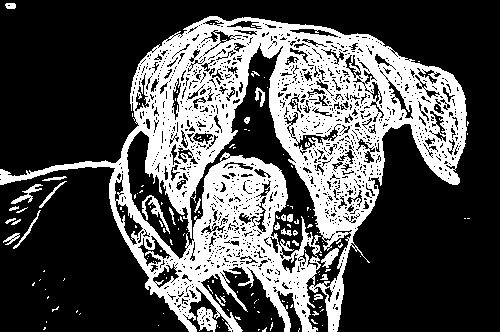

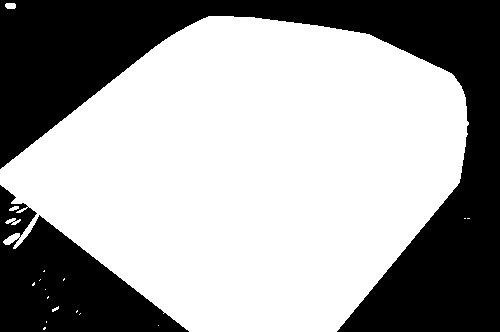

Processing file British_Shorthair_70.jpg


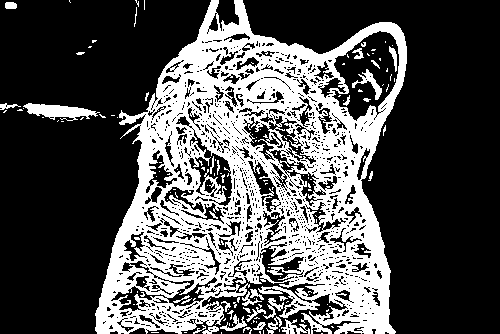

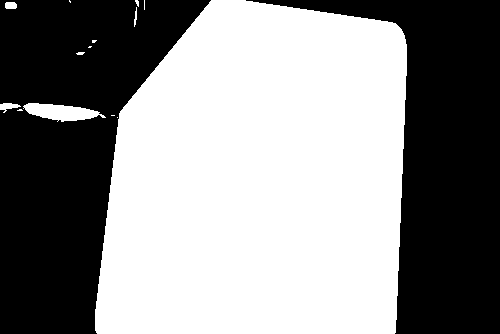

Processing file wheaten_terrier_53.jpg


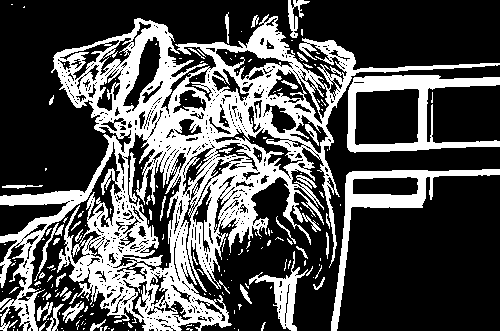

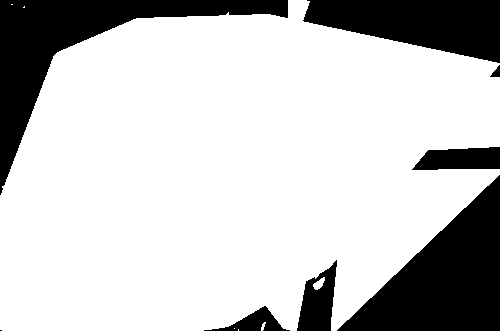

Processing file yorkshire_terrier_75.jpg


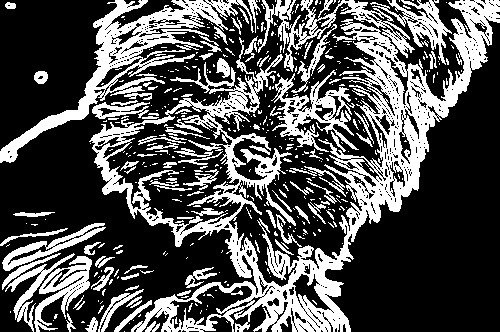

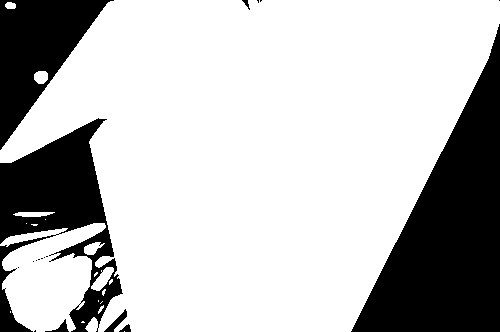

Processing file american_bulldog_140.jpg


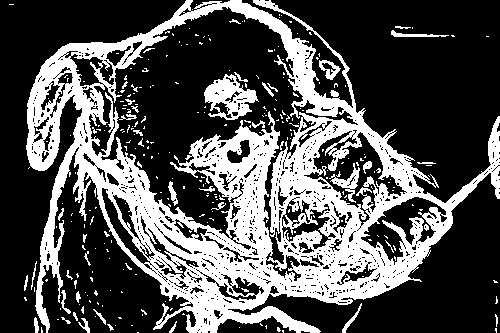

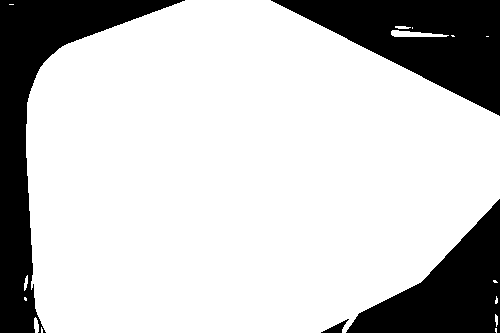

Processing file Abyssinian_122.jpg


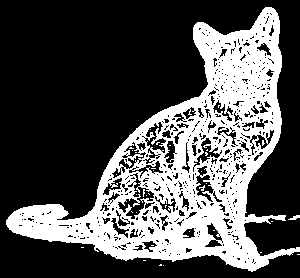

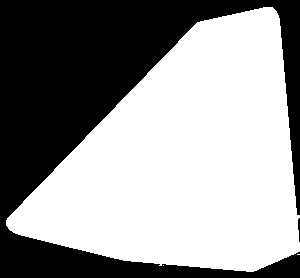

Processing file Bengal_50.jpg


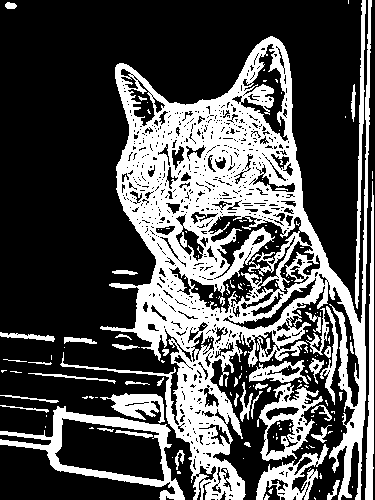

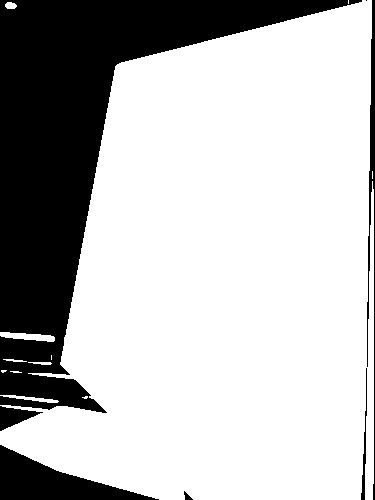

Processing file beagle_1.jpg


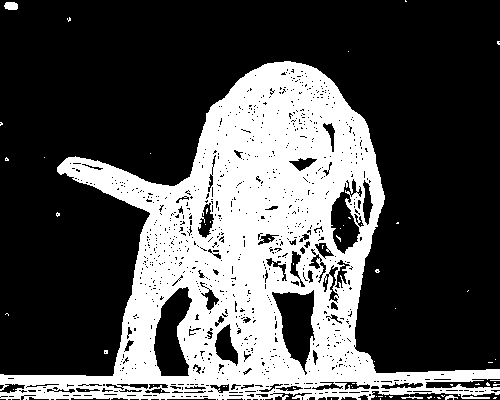

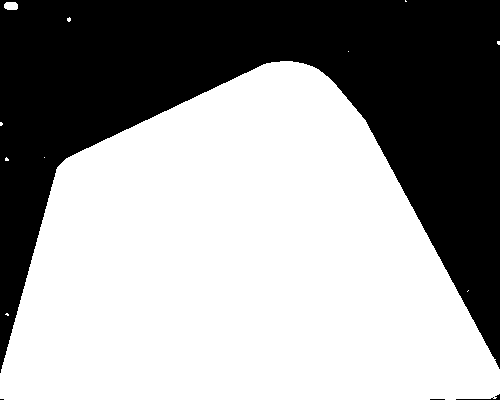

Processing file British_Shorthair_109.jpg


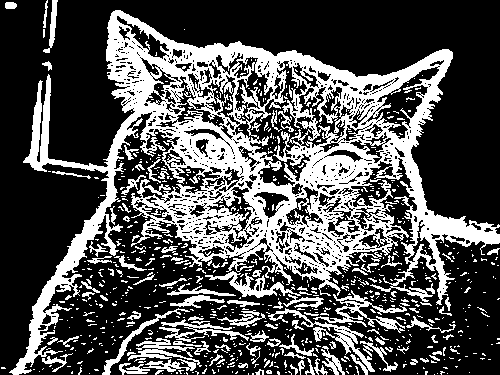

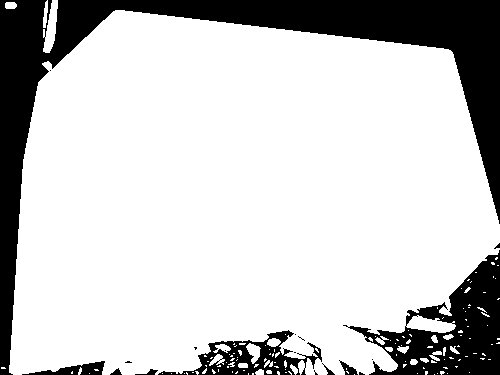

Processing file leonberger_2.jpg


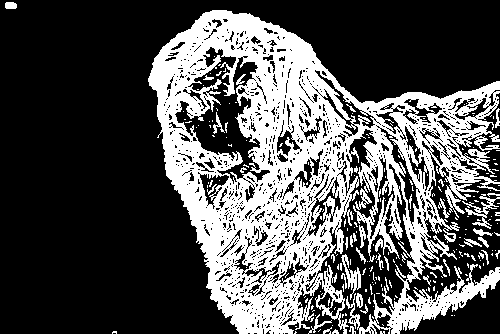

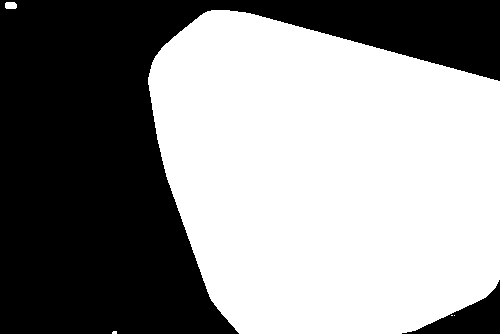

Processing file British_Shorthair_93.jpg


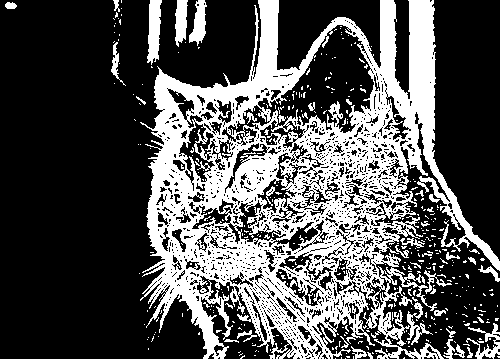

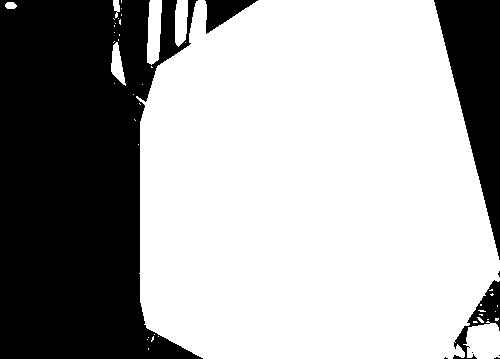

Processing file Ragdoll_125.jpg


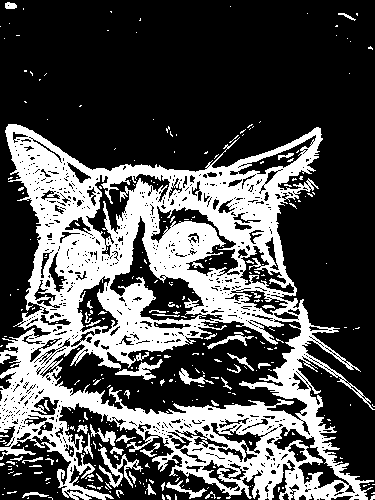

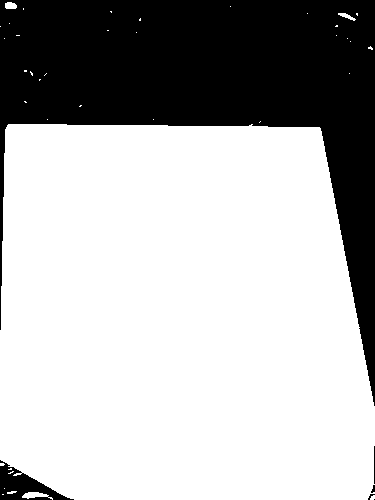

Metric_value 0.7776553432512903


In [57]:
print(f"Metric_value {evaluate_iou(image_dir='./images', anno_dir='./annotations')}")

Processing file boxer_11.jpg


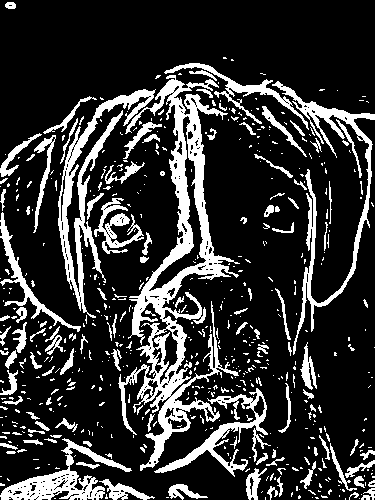

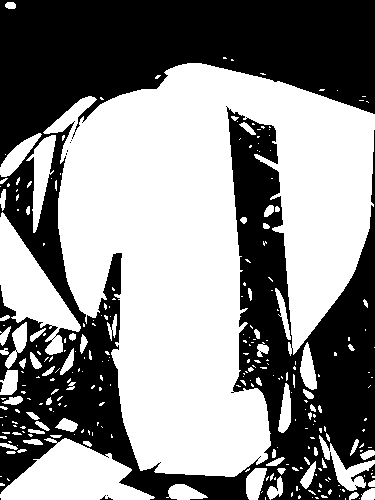

Processing file Abyssinian_24.jpg


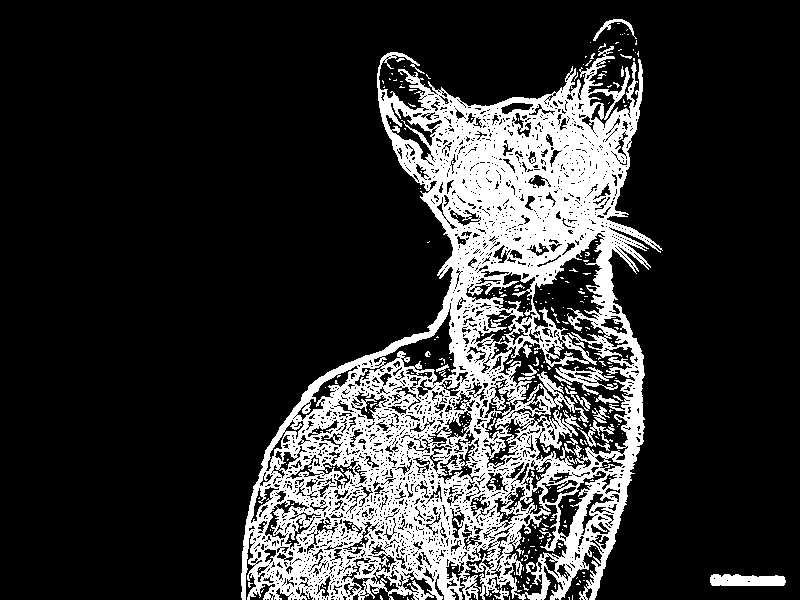

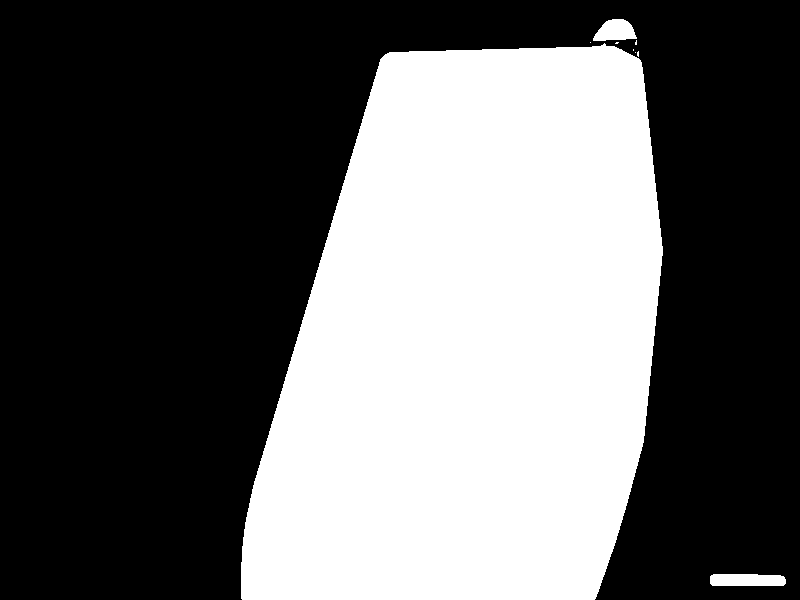

Processing file Russian_Blue_171.jpg


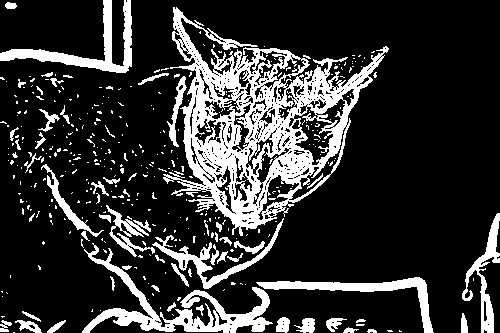

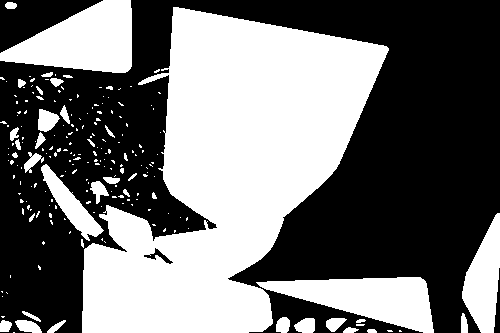

Processing file Abyssinian_210.jpg


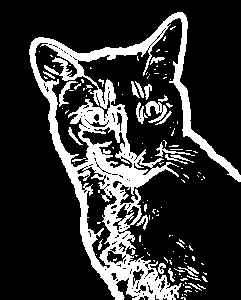

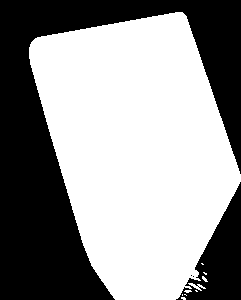

Processing file beagle_180.jpg


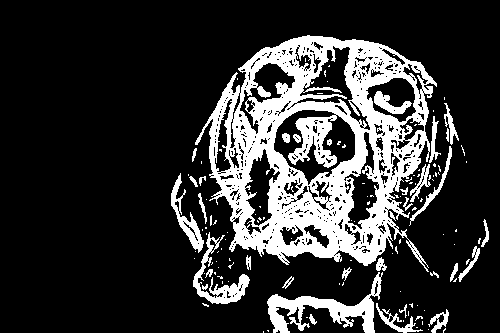

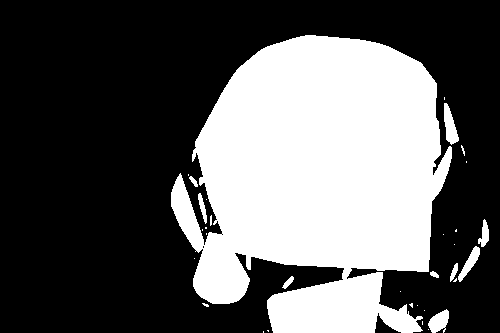

Processing file basset_hound_181.jpg


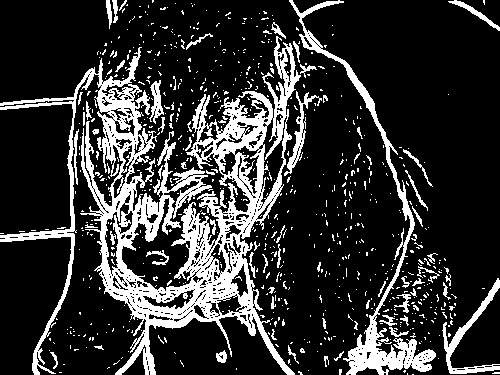

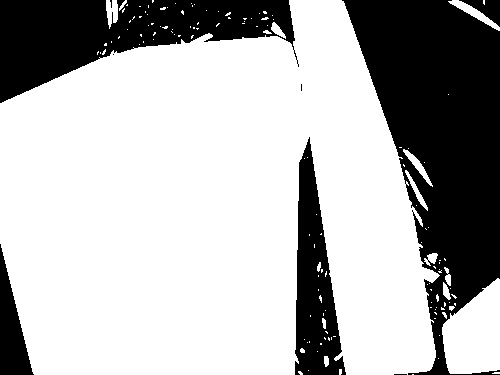

Processing file Egyptian_Mau_95.jpg


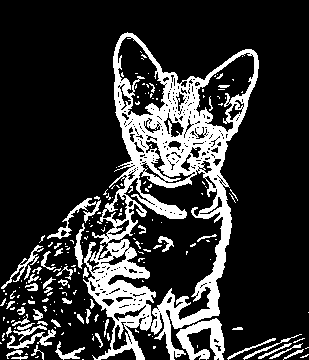

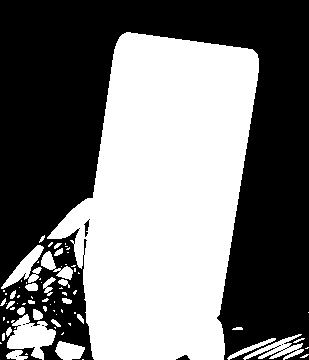

Processing file Siamese_128.jpg


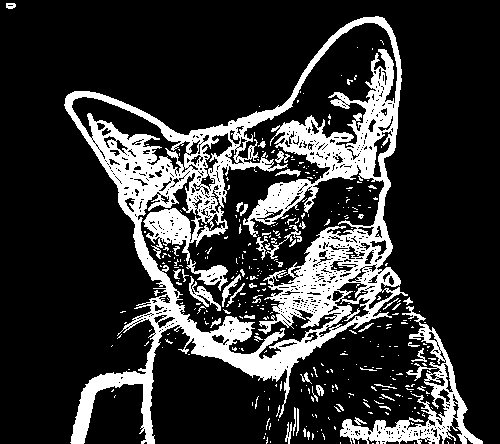

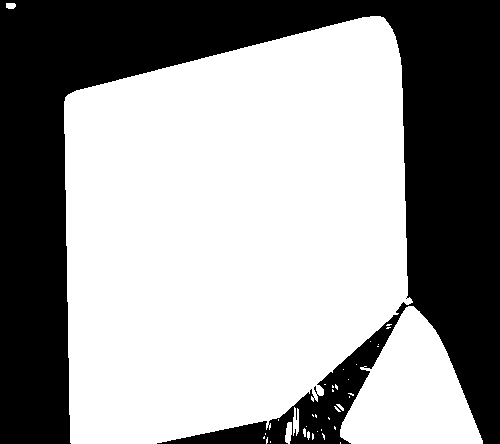

Processing file pug_13.jpg


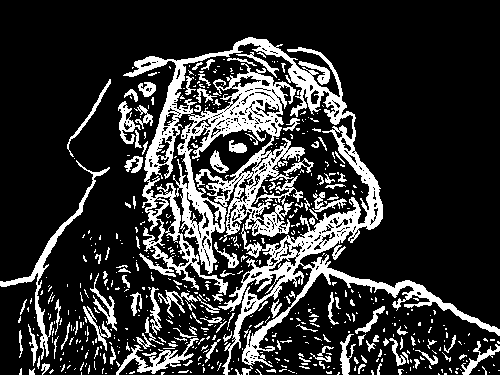

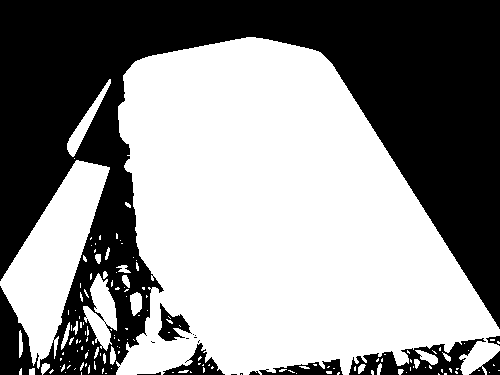

Processing file Bengal_147.jpg


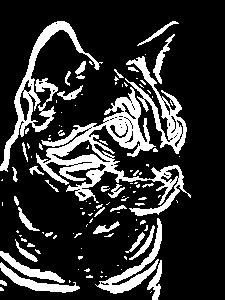

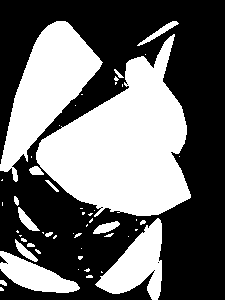

Processing file Sphynx_139.jpg


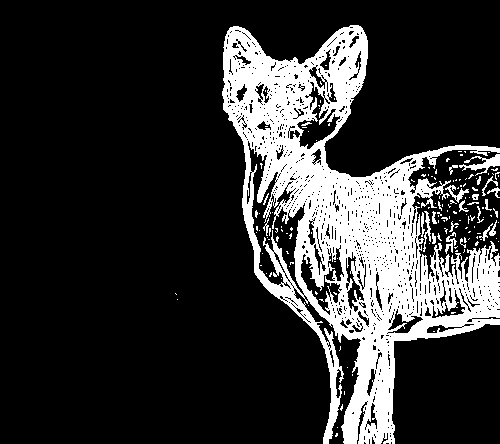

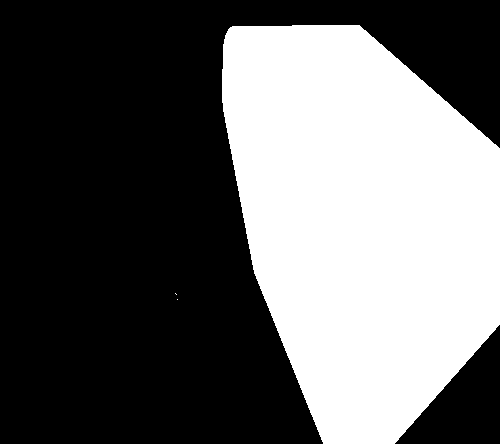

Processing file basset_hound_14.jpg


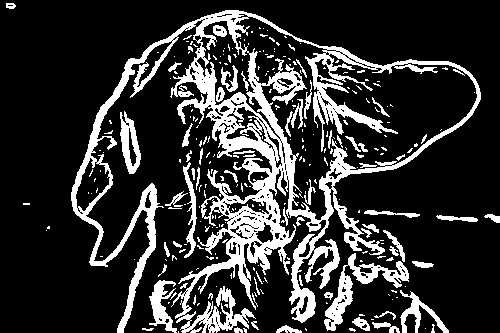

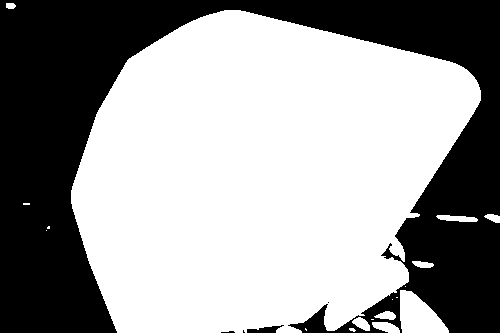

Processing file Maine_Coon_79.jpg


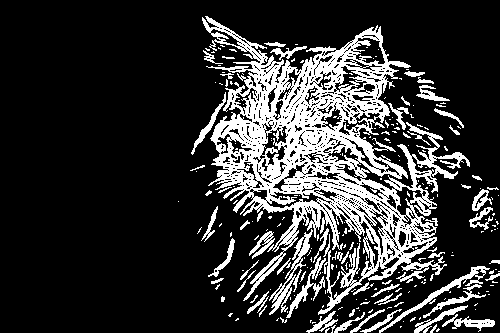

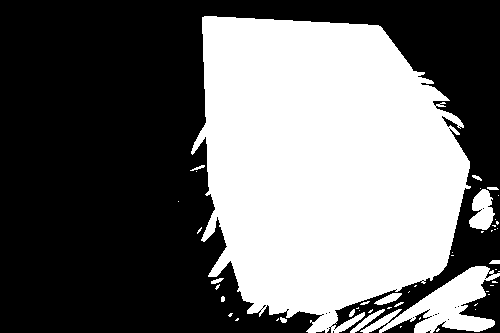

Processing file keeshond_92.jpg


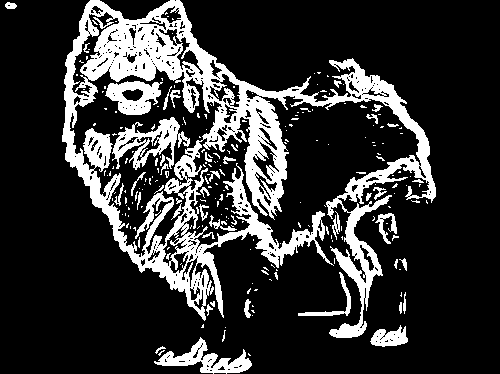

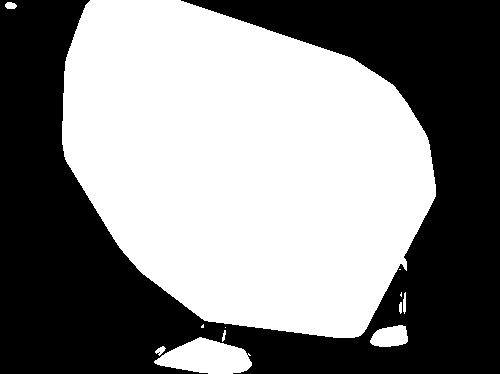

Processing file Abyssinian_66.jpg


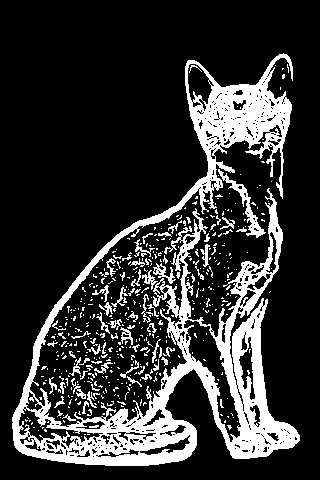

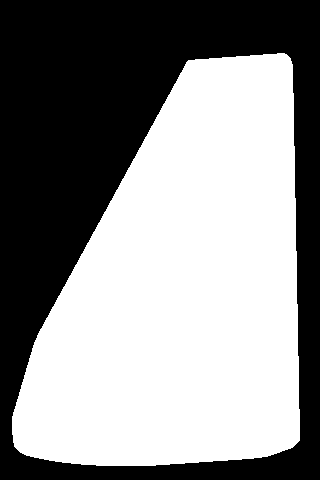

Processing file leonberger_100.jpg


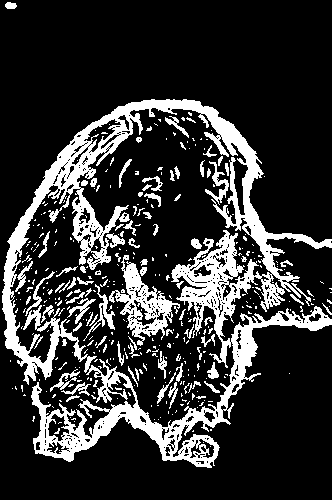

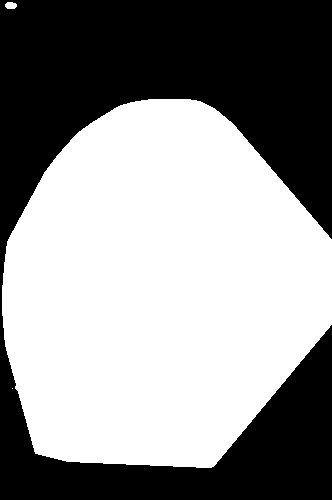

Processing file yorkshire_terrier_90.jpg


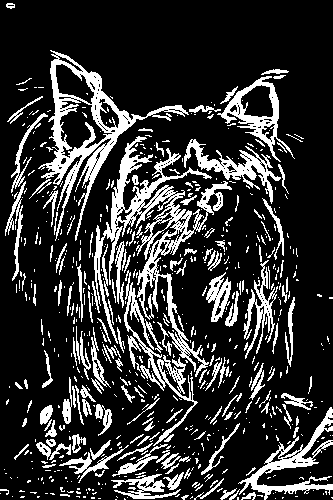

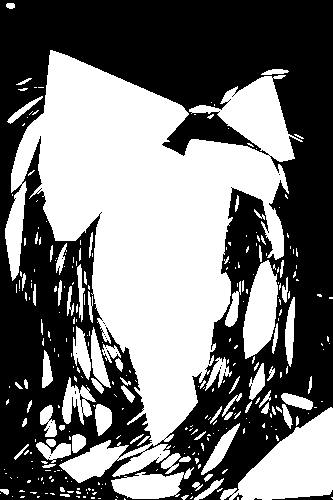

Processing file Birman_7.jpg


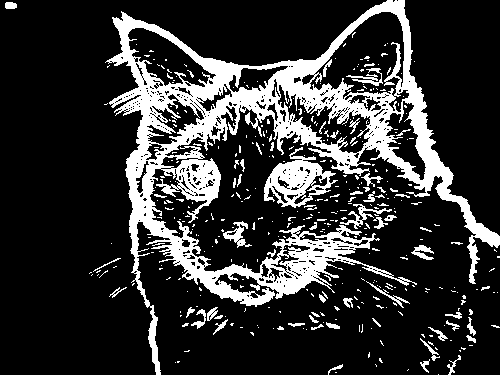

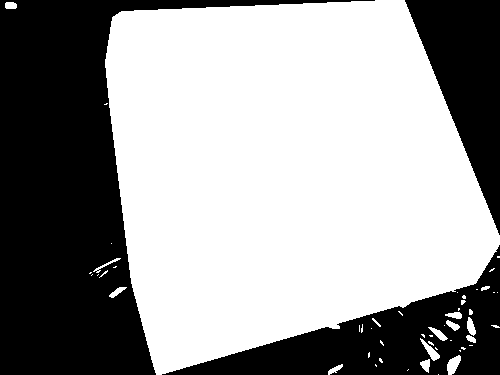

Processing file shiba_inu_132.jpg


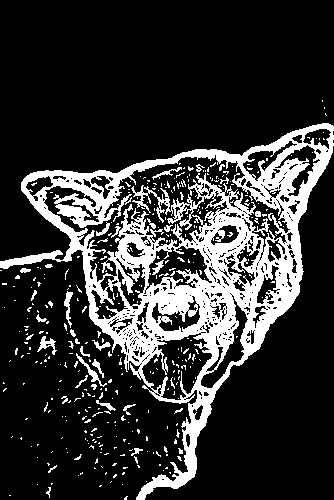

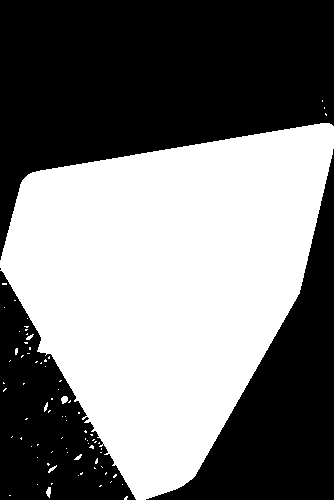

Processing file Persian_16.jpg


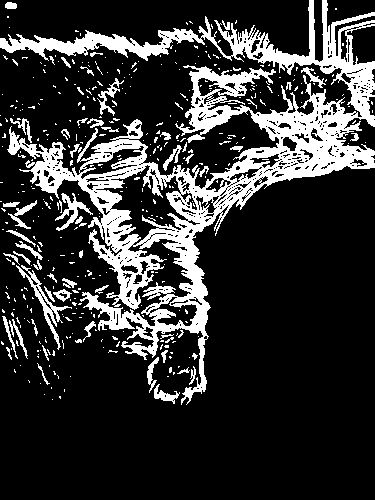

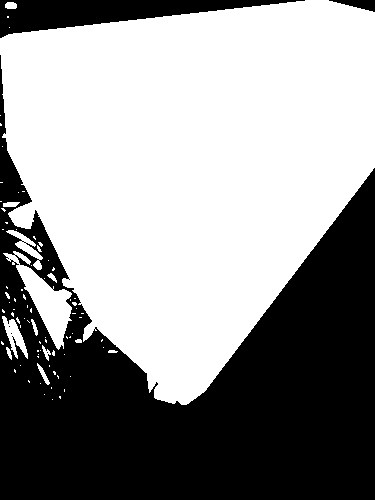

Processing file Ragdoll_188.jpg


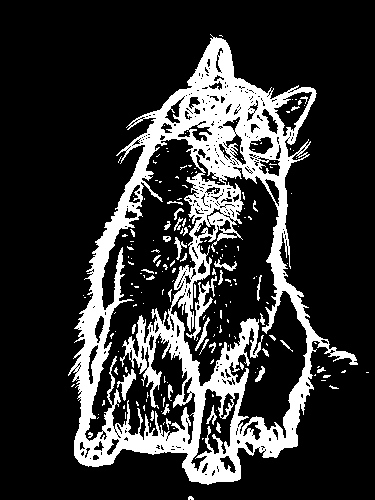

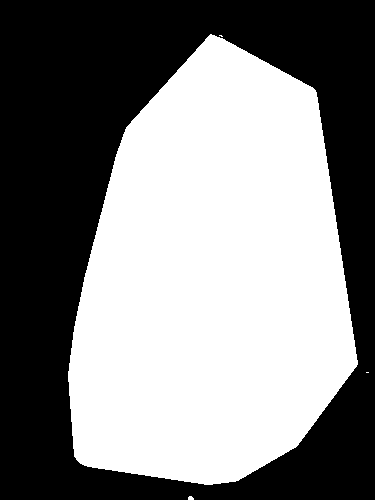

Processing file chihuahua_38.jpg


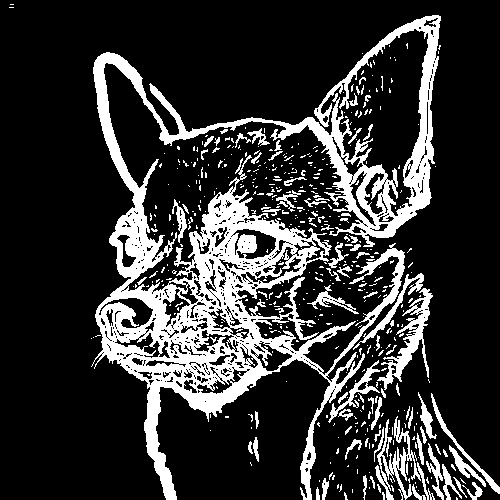

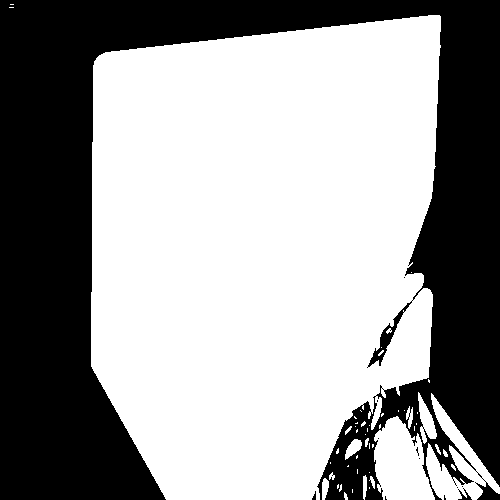

Processing file english_setter_96.jpg


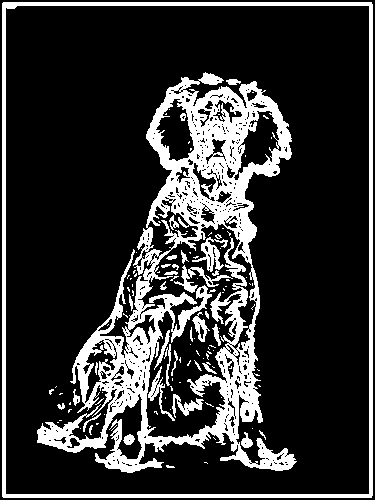

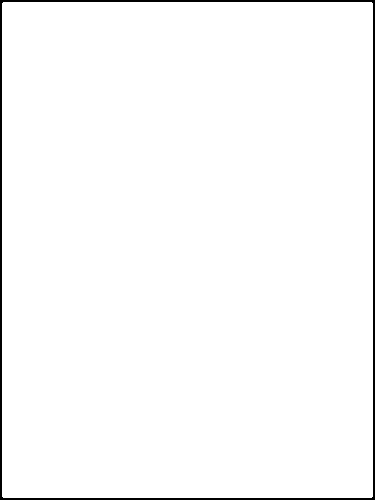

Processing file Maine_Coon_3.jpg


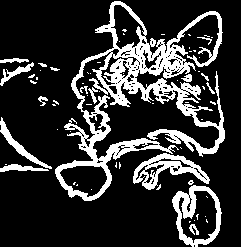

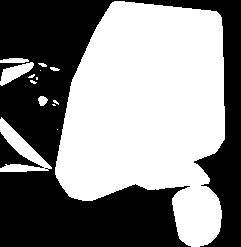

Processing file Russian_Blue_24.jpg


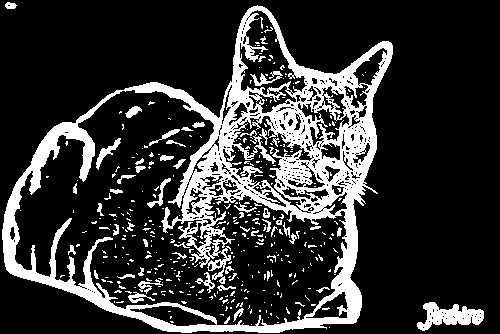

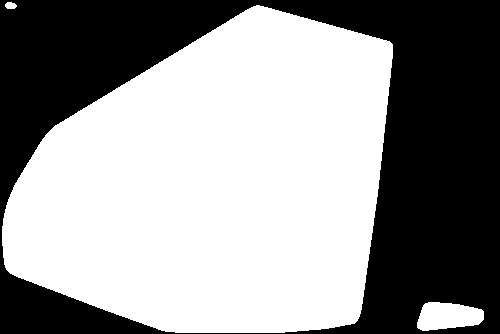

Processing file Abyssinian_19.jpg


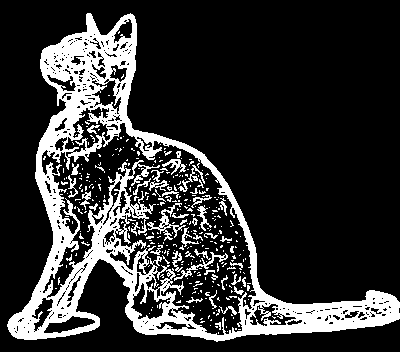

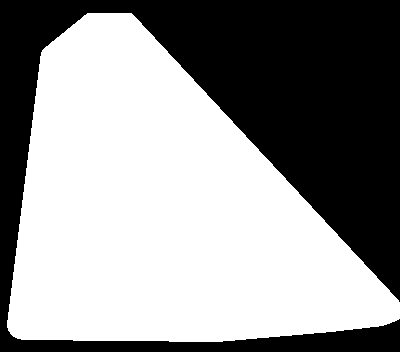

Processing file shiba_inu_72.jpg


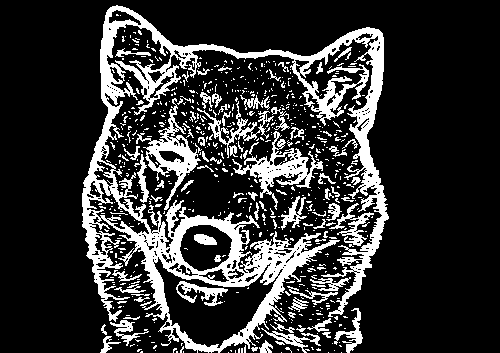

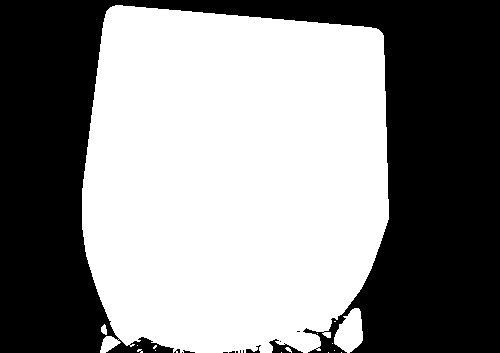

Processing file British_Shorthair_186.jpg


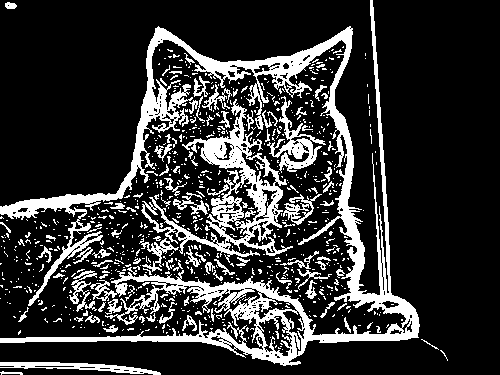

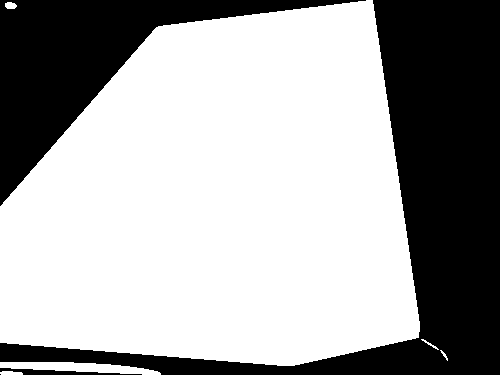

Processing file Sphynx_33.jpg


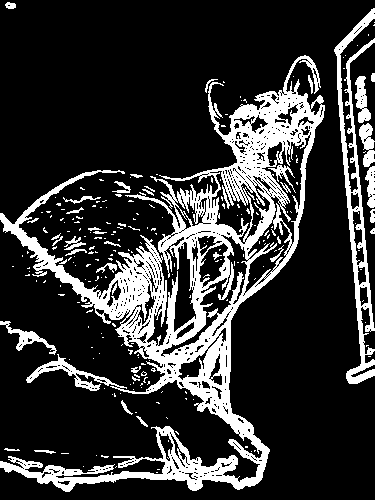

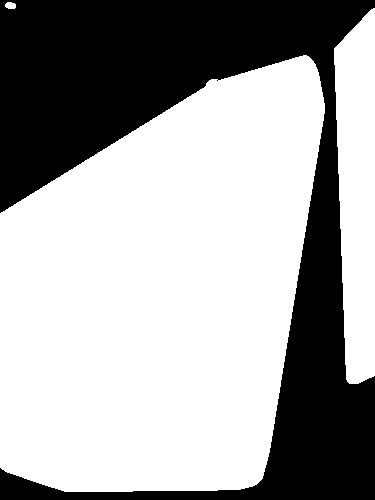

Processing file english_cocker_spaniel_10.jpg


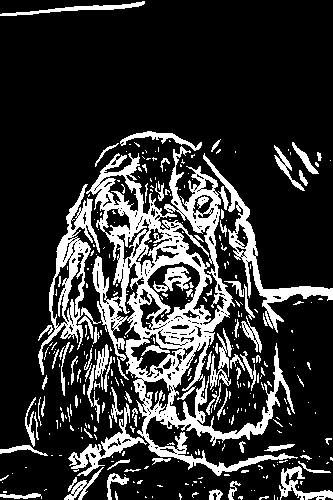

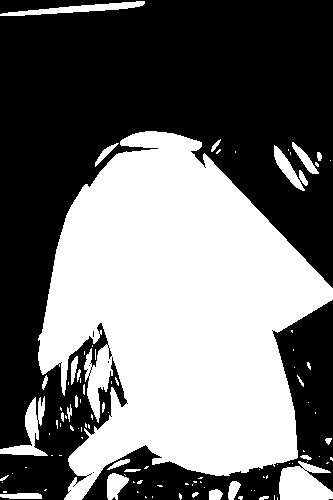

Processing file boxer_27.jpg


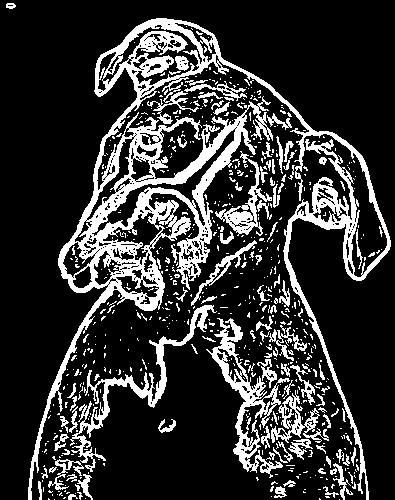

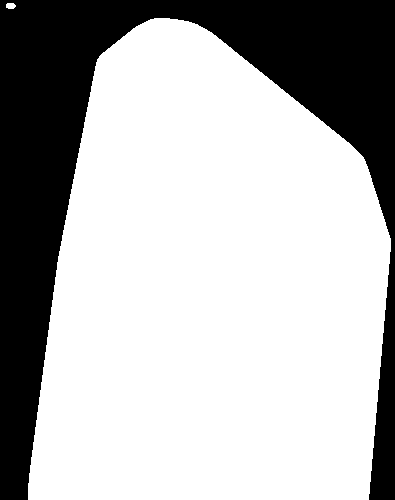

Processing file american_bulldog_199.jpg


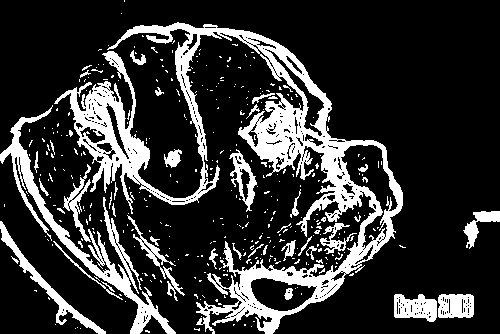

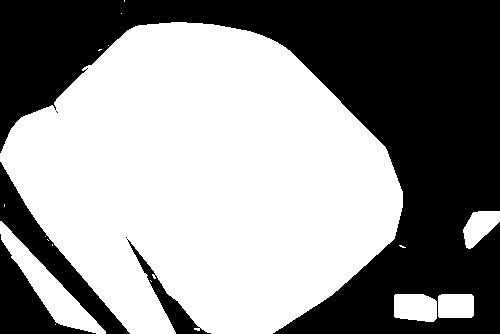

Processing file Russian_Blue_180.jpg


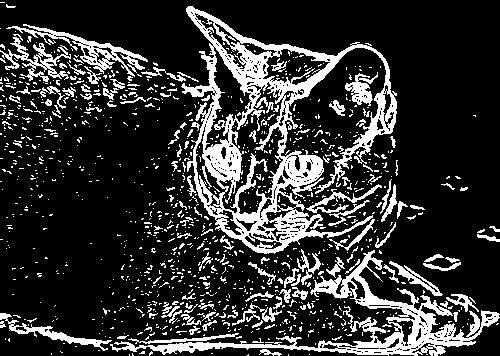

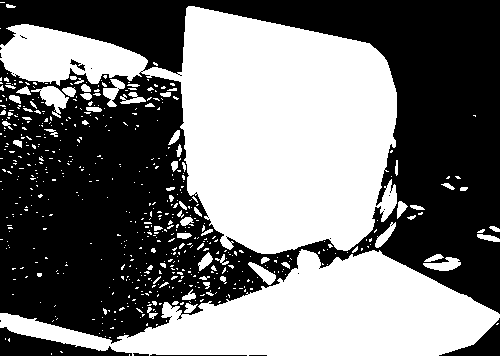

Processing file pug_97.jpg


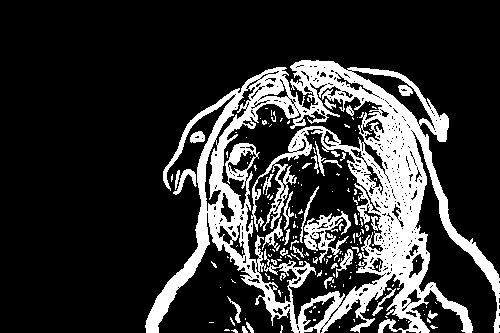

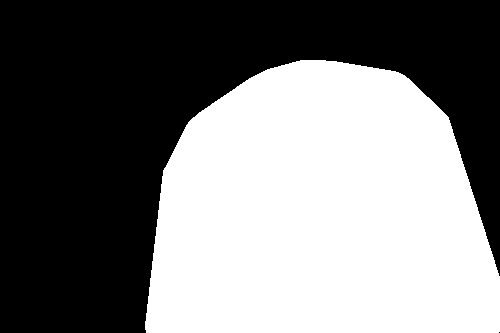

Processing file British_Shorthair_72.jpg


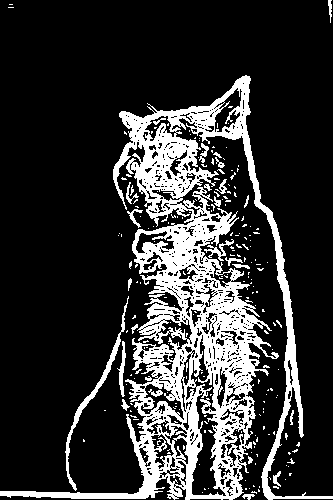

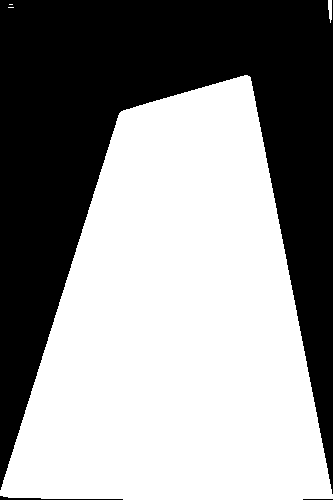

Processing file Russian_Blue_8.jpg


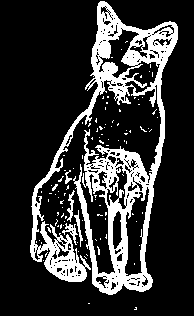

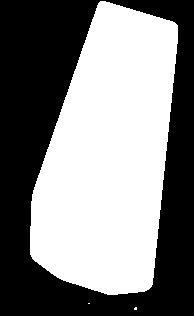

Processing file Maine_Coon_264.jpg


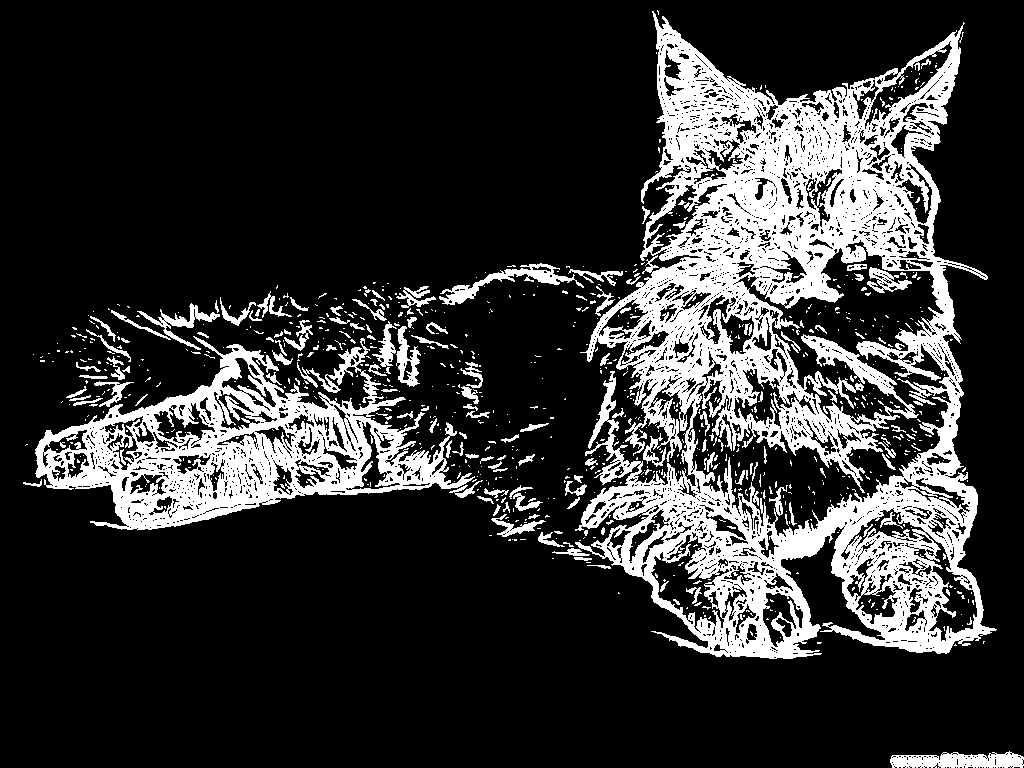

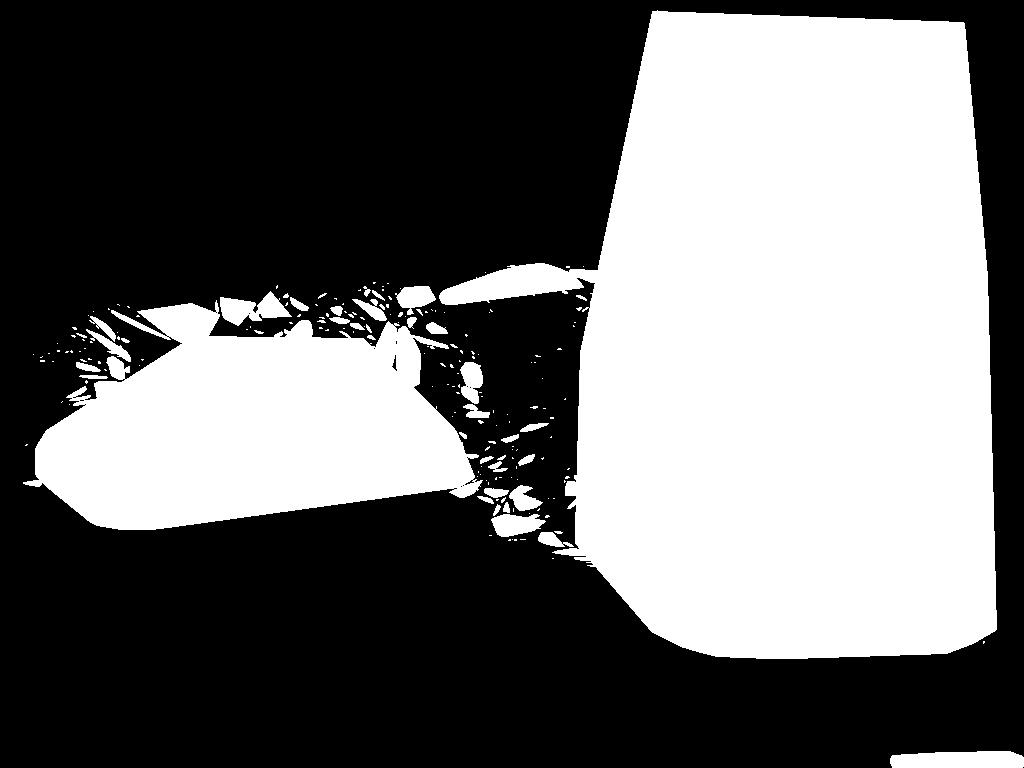

Processing file staffordshire_bull_terrier_41.jpg


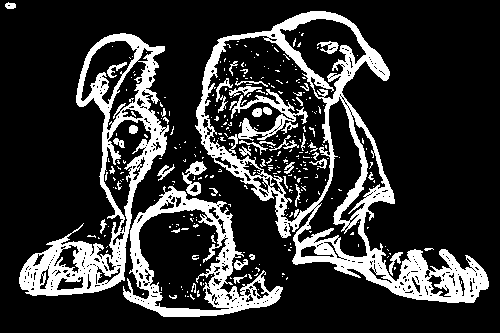

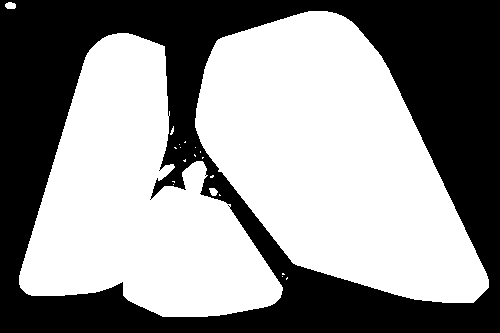

Processing file Maine_Coon_43.jpg


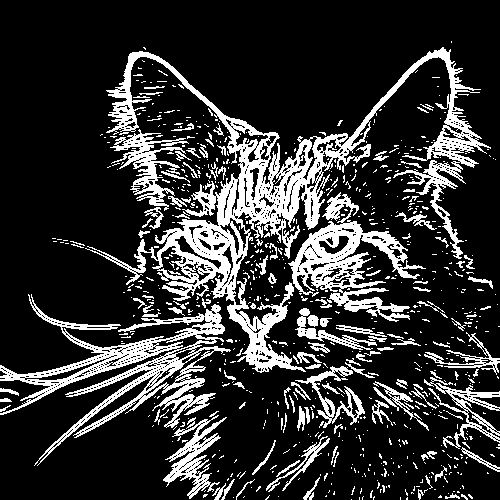

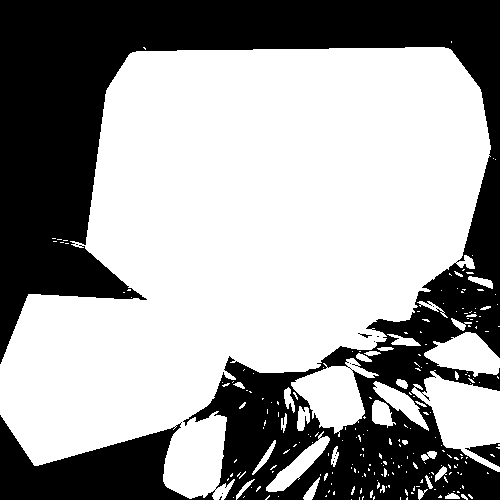

Processing file Bengal_103.jpg


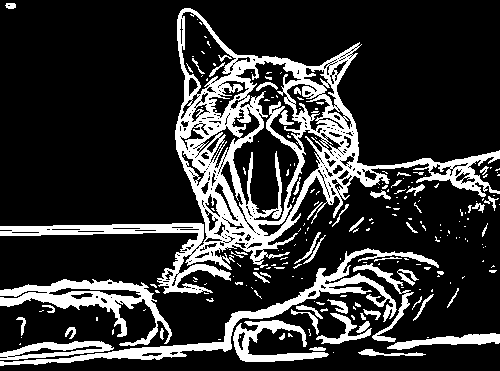

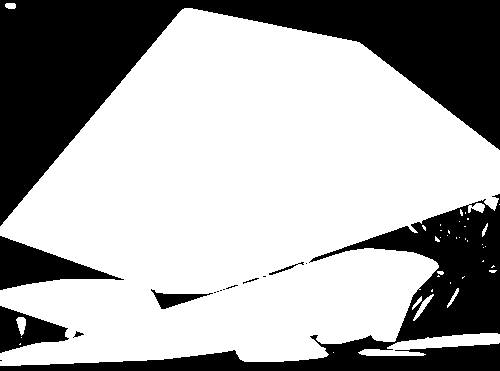

Processing file leonberger_24.jpg


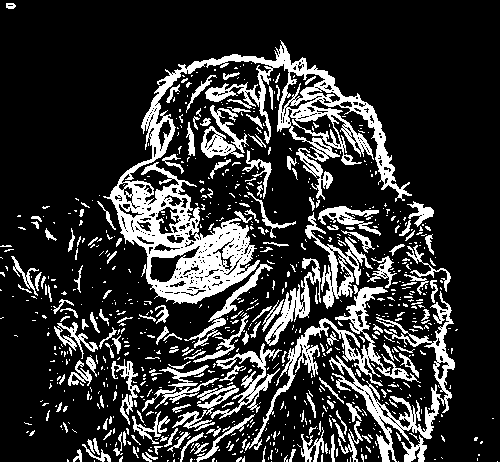

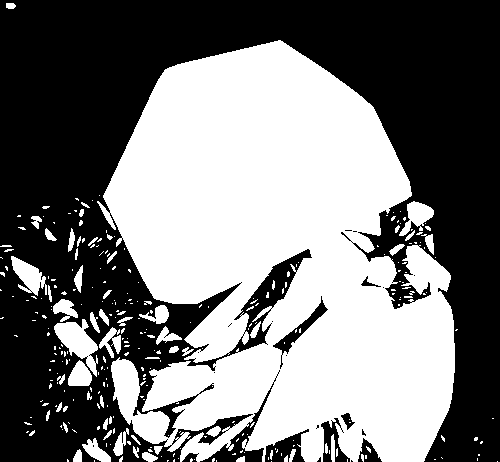

Processing file Egyptian_Mau_155.jpg


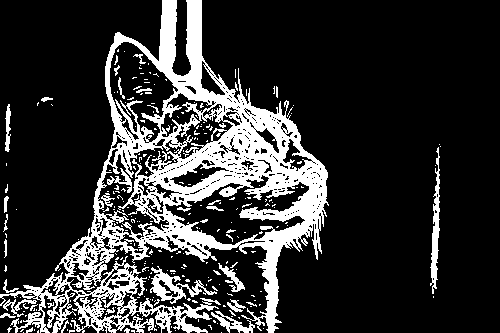

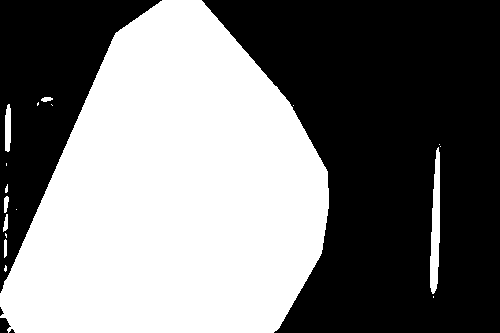

Processing file Persian_7.jpg


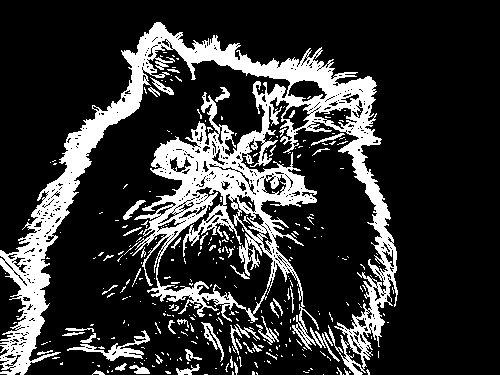

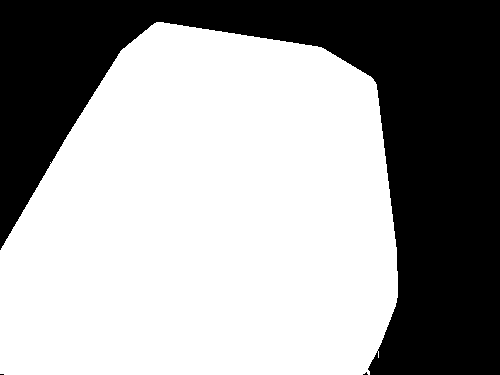

Processing file Persian_255.jpg


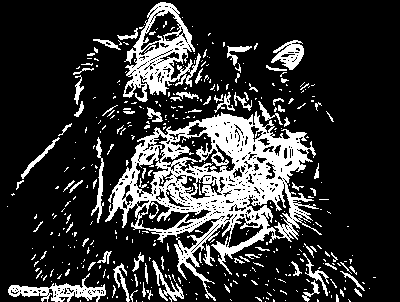

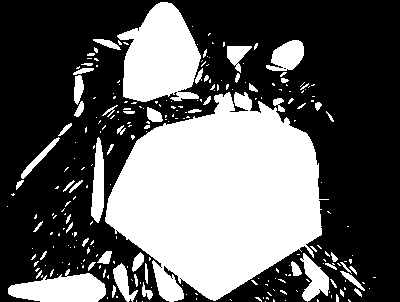

Processing file Russian_Blue_95.jpg


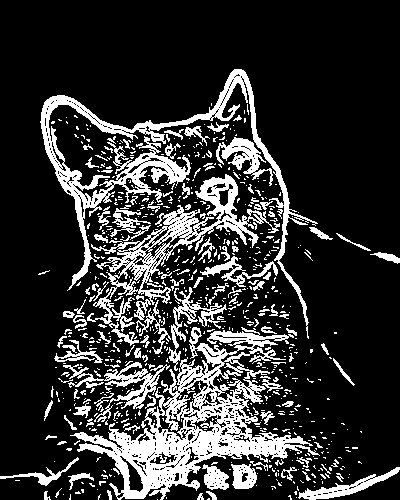

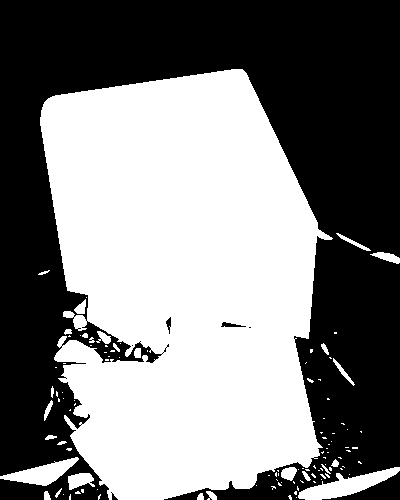

Processing file english_cocker_spaniel_68.jpg


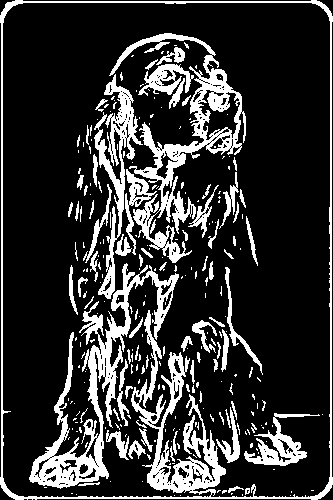

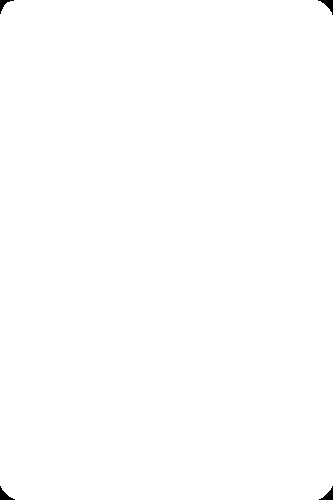

Processing file British_Shorthair_180.jpg


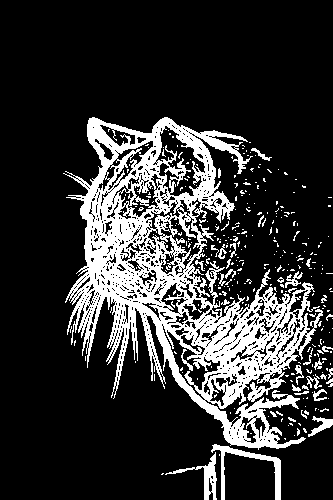

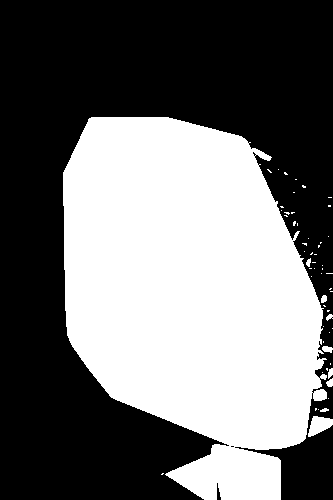

Processing file British_Shorthair_2.jpg


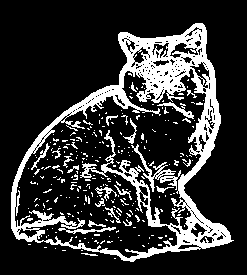

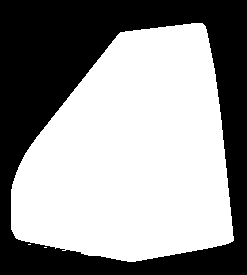

Processing file english_setter_42.jpg


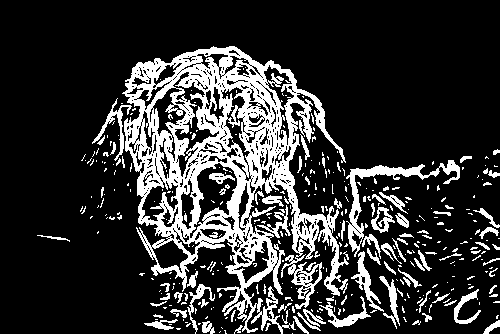

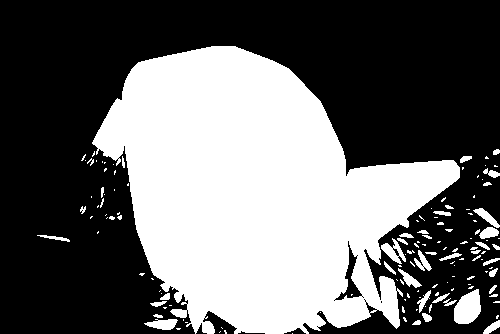

Processing file Persian_152.jpg


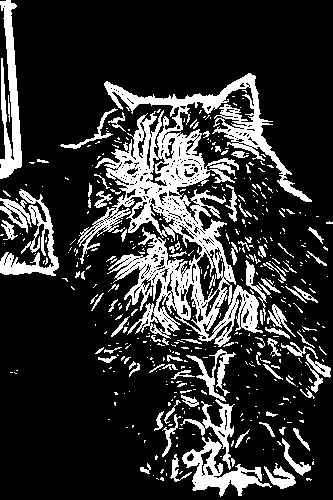

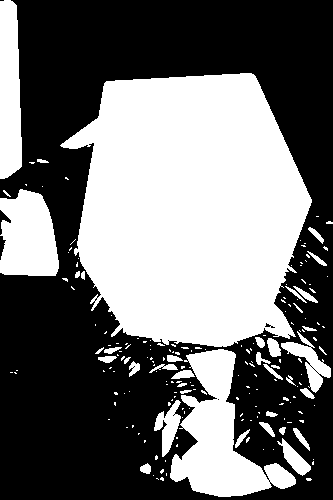

Processing file shiba_inu_131.jpg


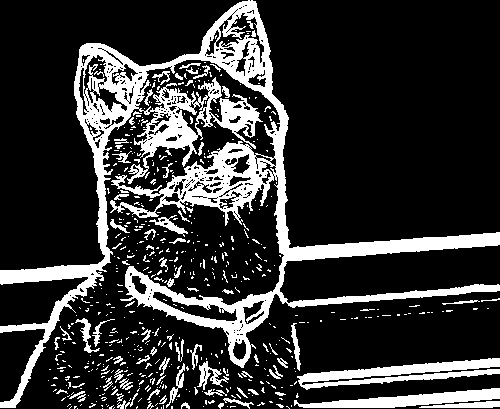

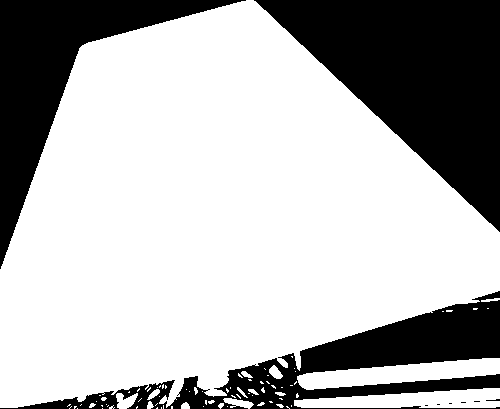

Processing file saint_bernard_50.jpg


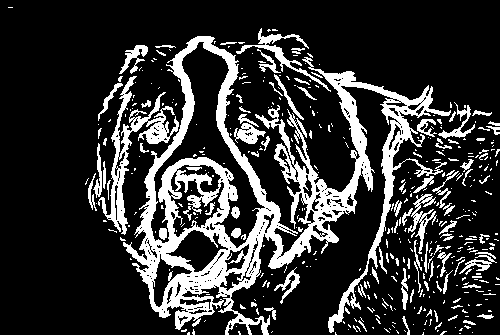

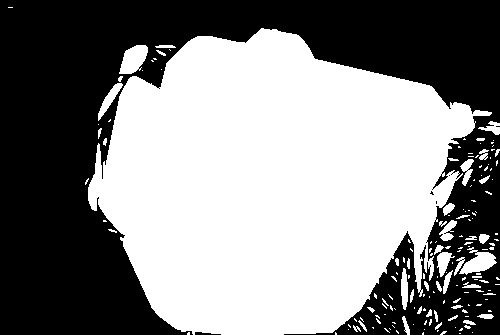

Processing file boxer_17.jpg


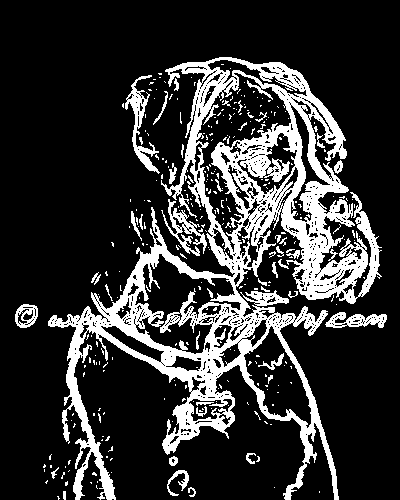

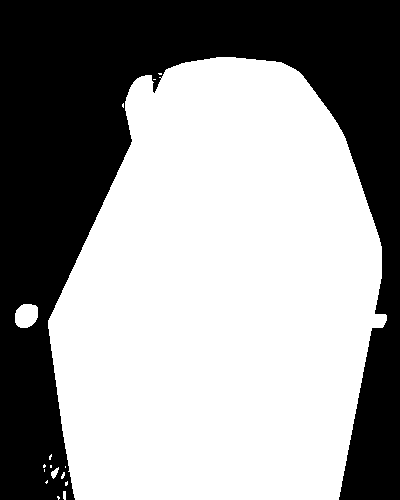

Processing file Russian_Blue_212.jpg


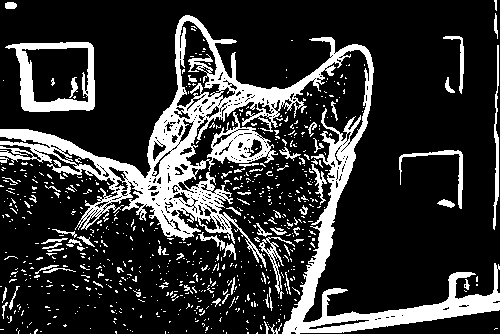

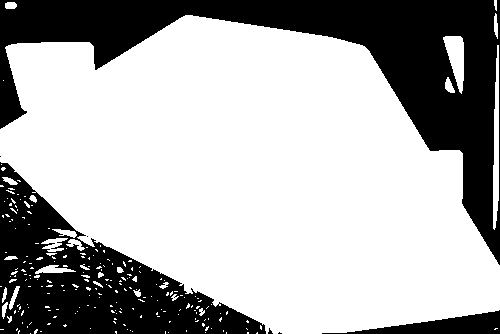

Processing file Bombay_48.jpg


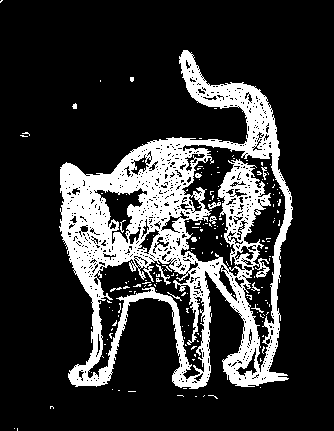

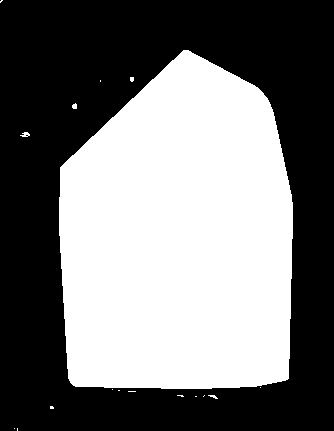

Processing file Bombay_16.jpg


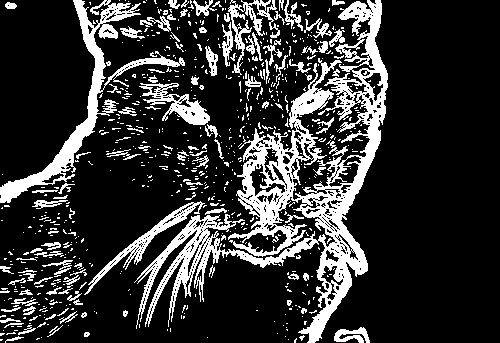

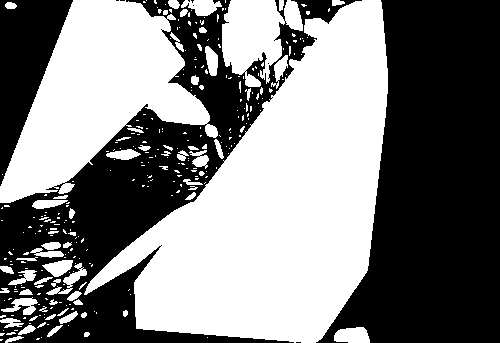

Processing file wheaten_terrier_1.jpg


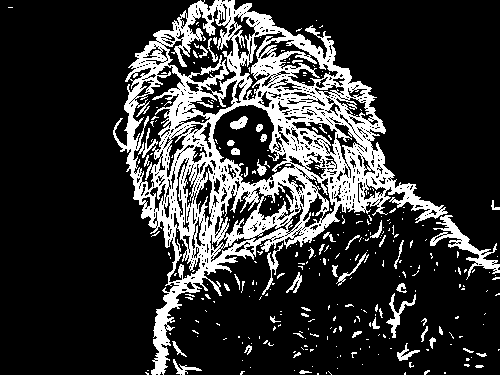

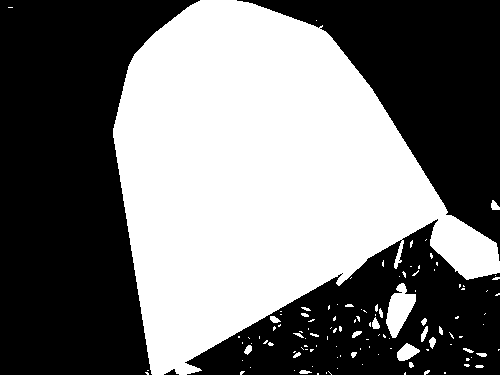

Processing file Sphynx_72.jpg


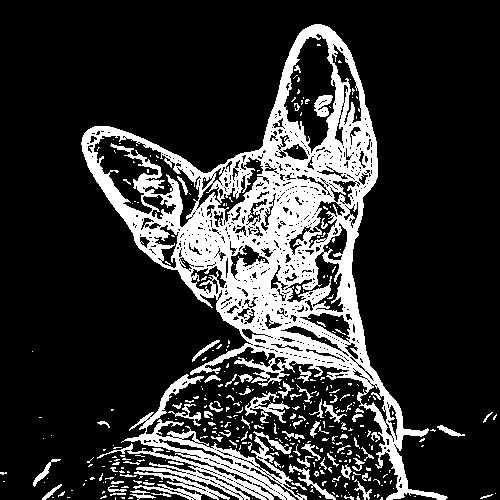

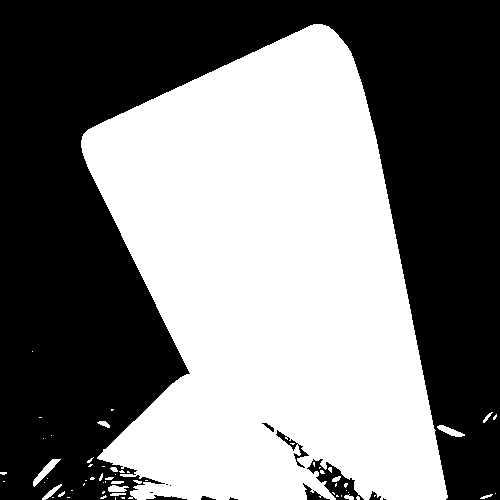

Processing file Russian_Blue_35.jpg


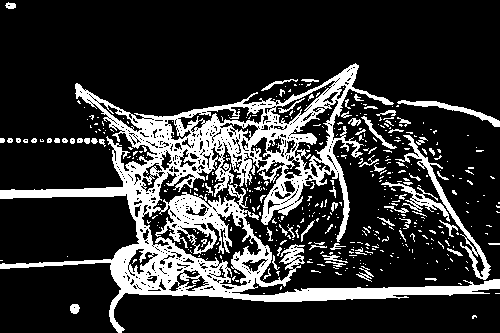

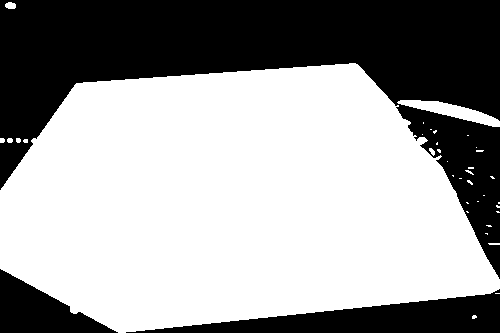

Processing file Siamese_240.jpg


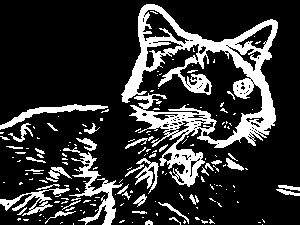

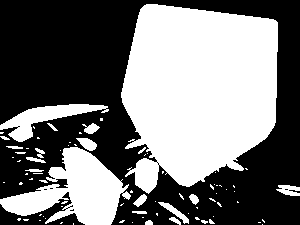

Processing file chihuahua_19.jpg


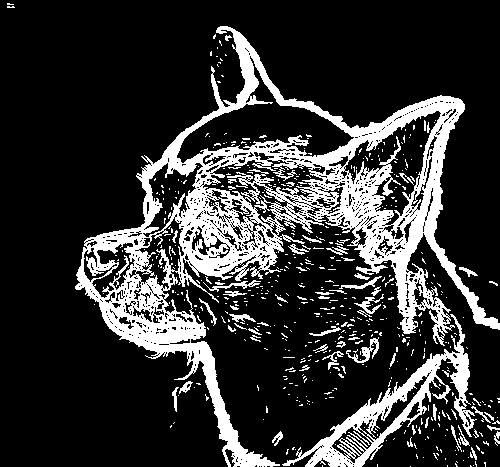

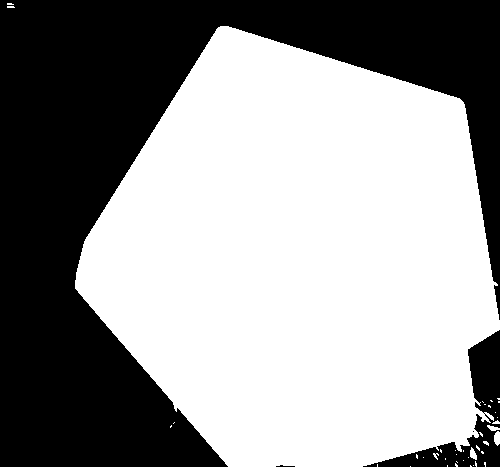

Processing file British_Shorthair_40.jpg


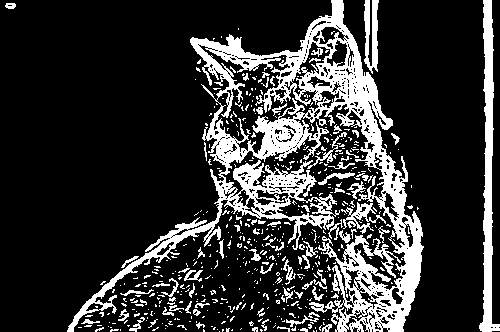

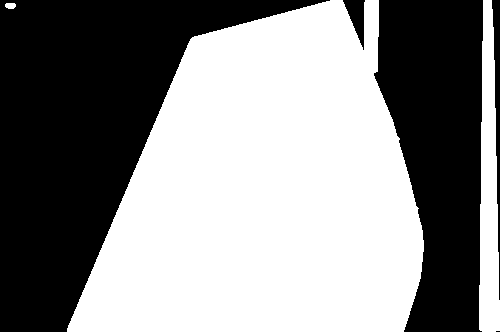

Processing file staffordshire_bull_terrier_67.jpg


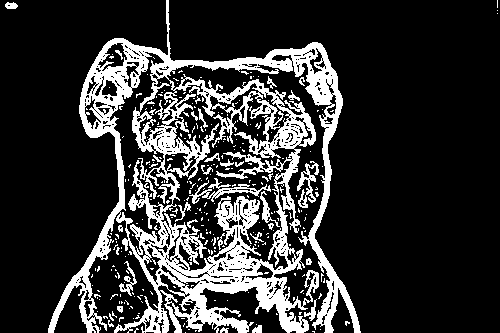

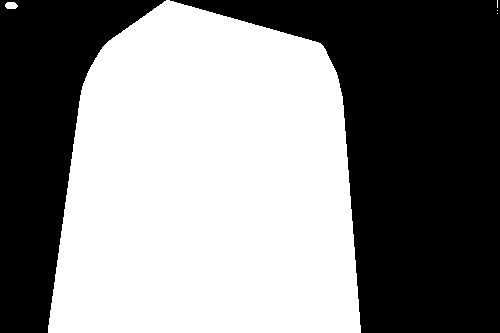

Processing file Abyssinian_9.jpg


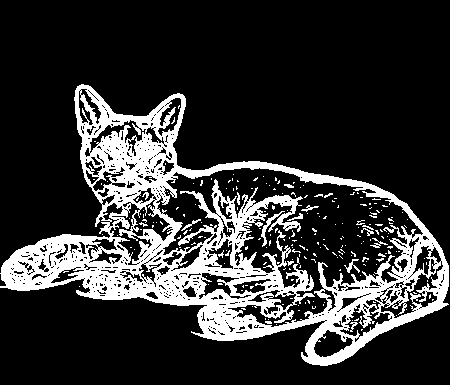

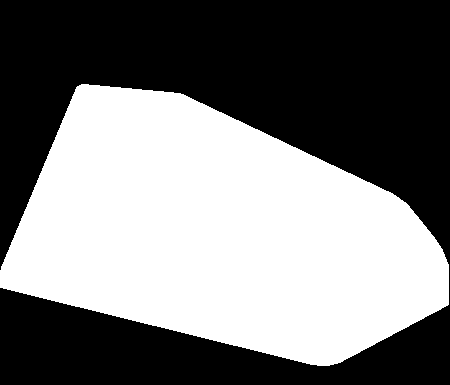

Processing file Persian_4.jpg


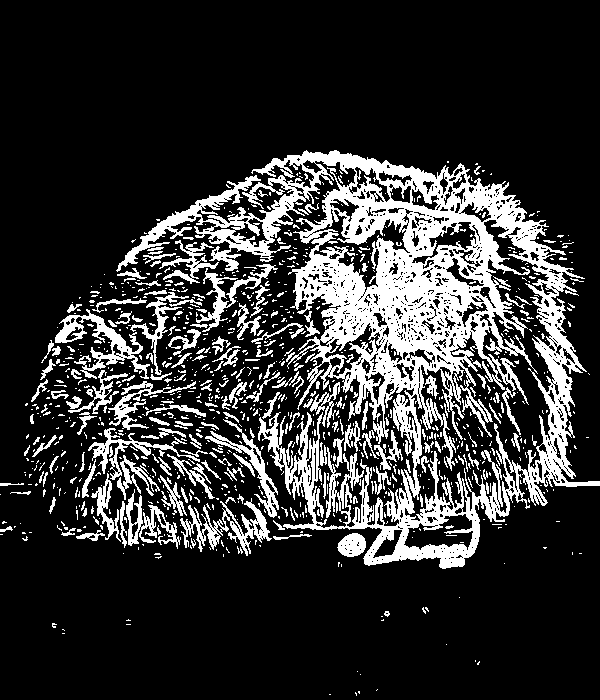

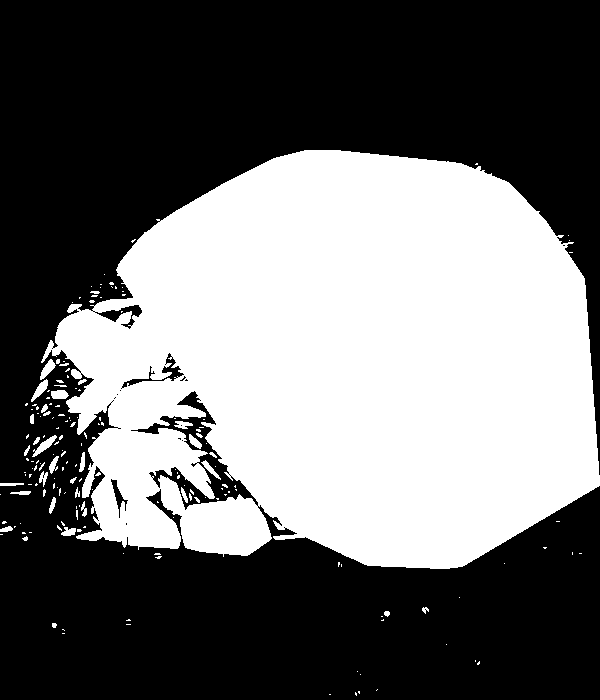

Processing file Maine_Coon_89.jpg


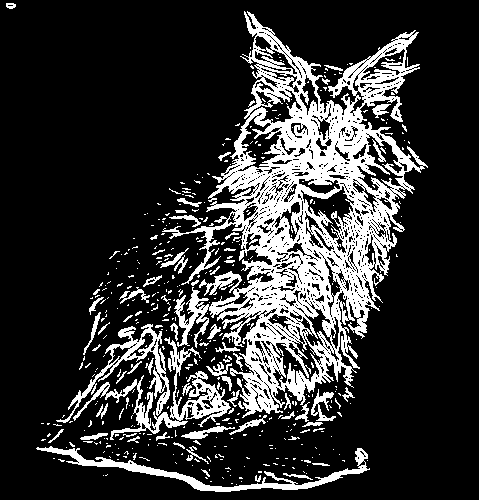

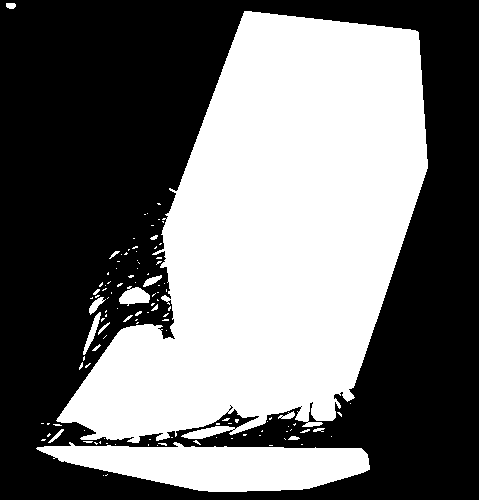

Processing file basset_hound_118.jpg


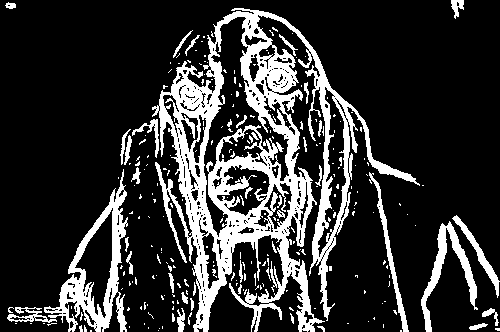

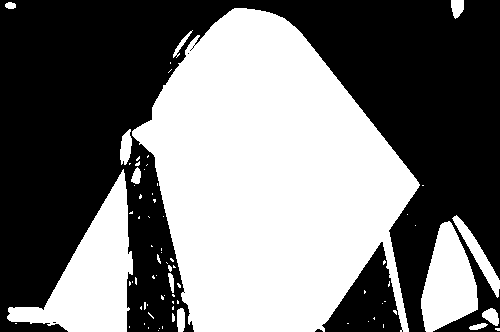

Processing file Egyptian_Mau_187.jpg


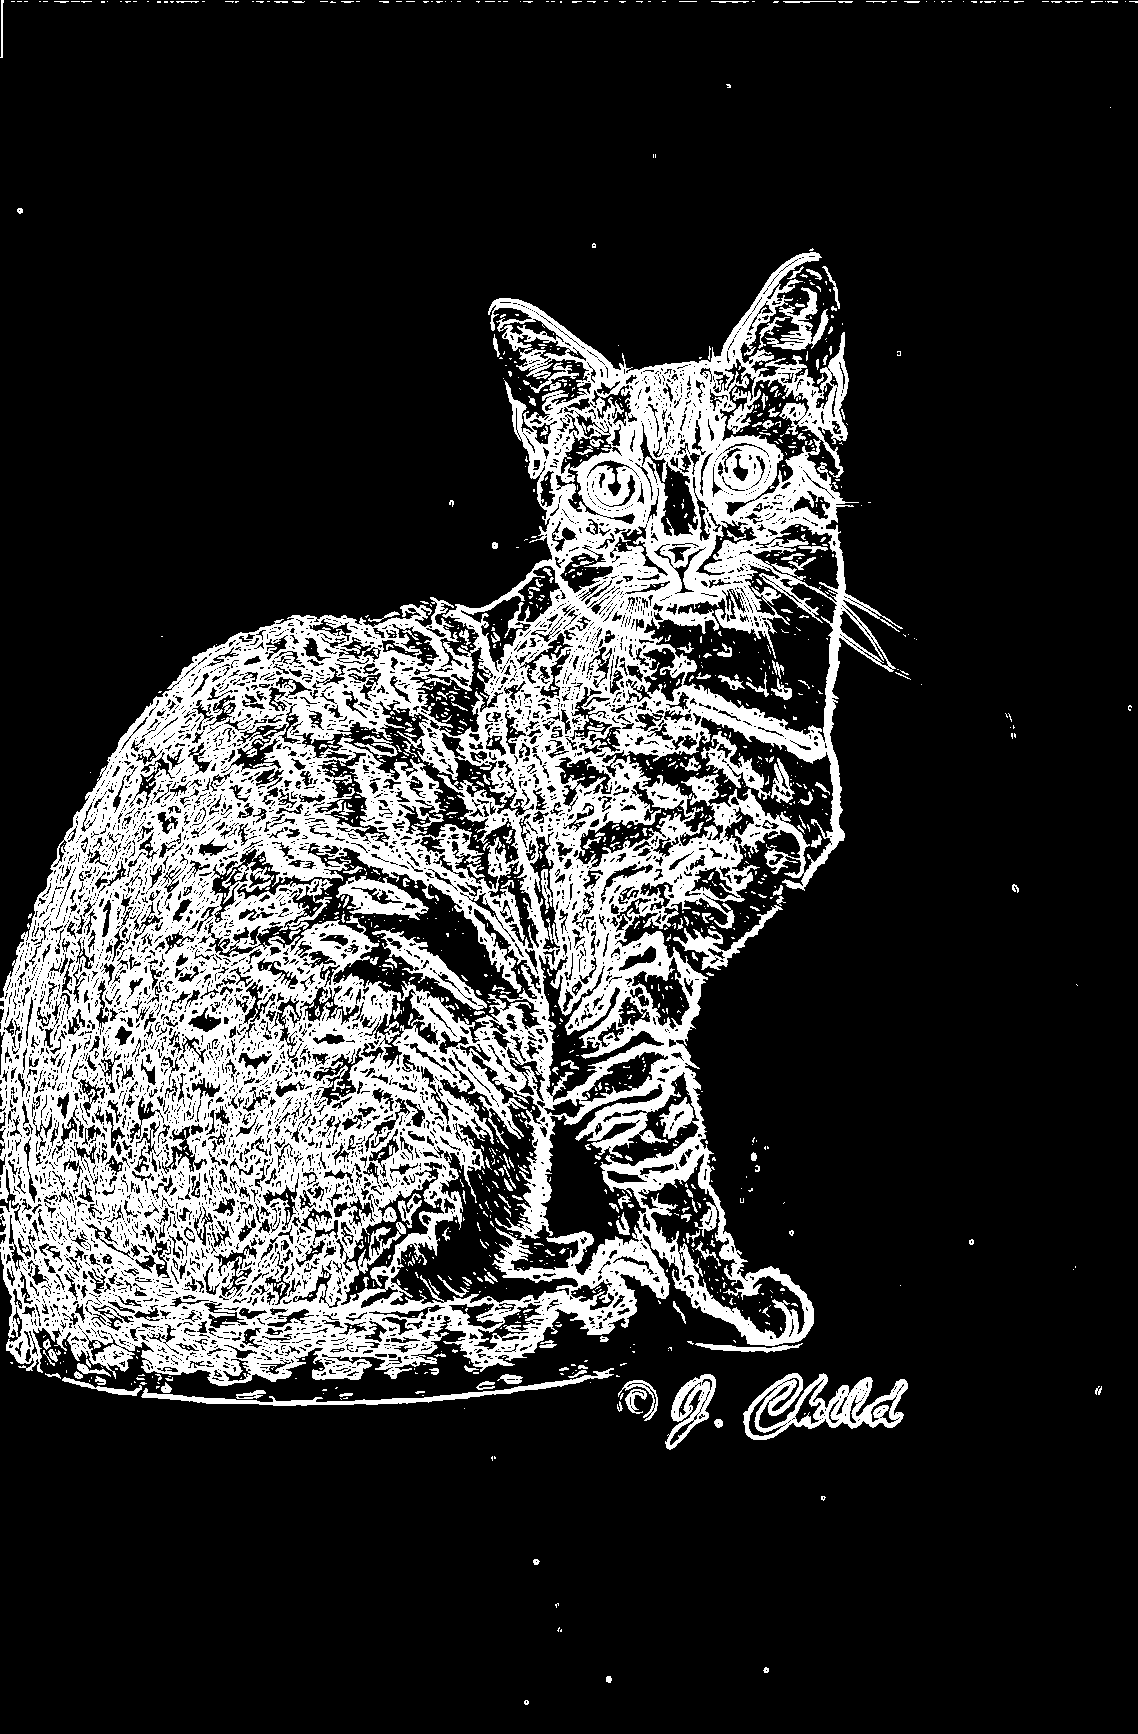

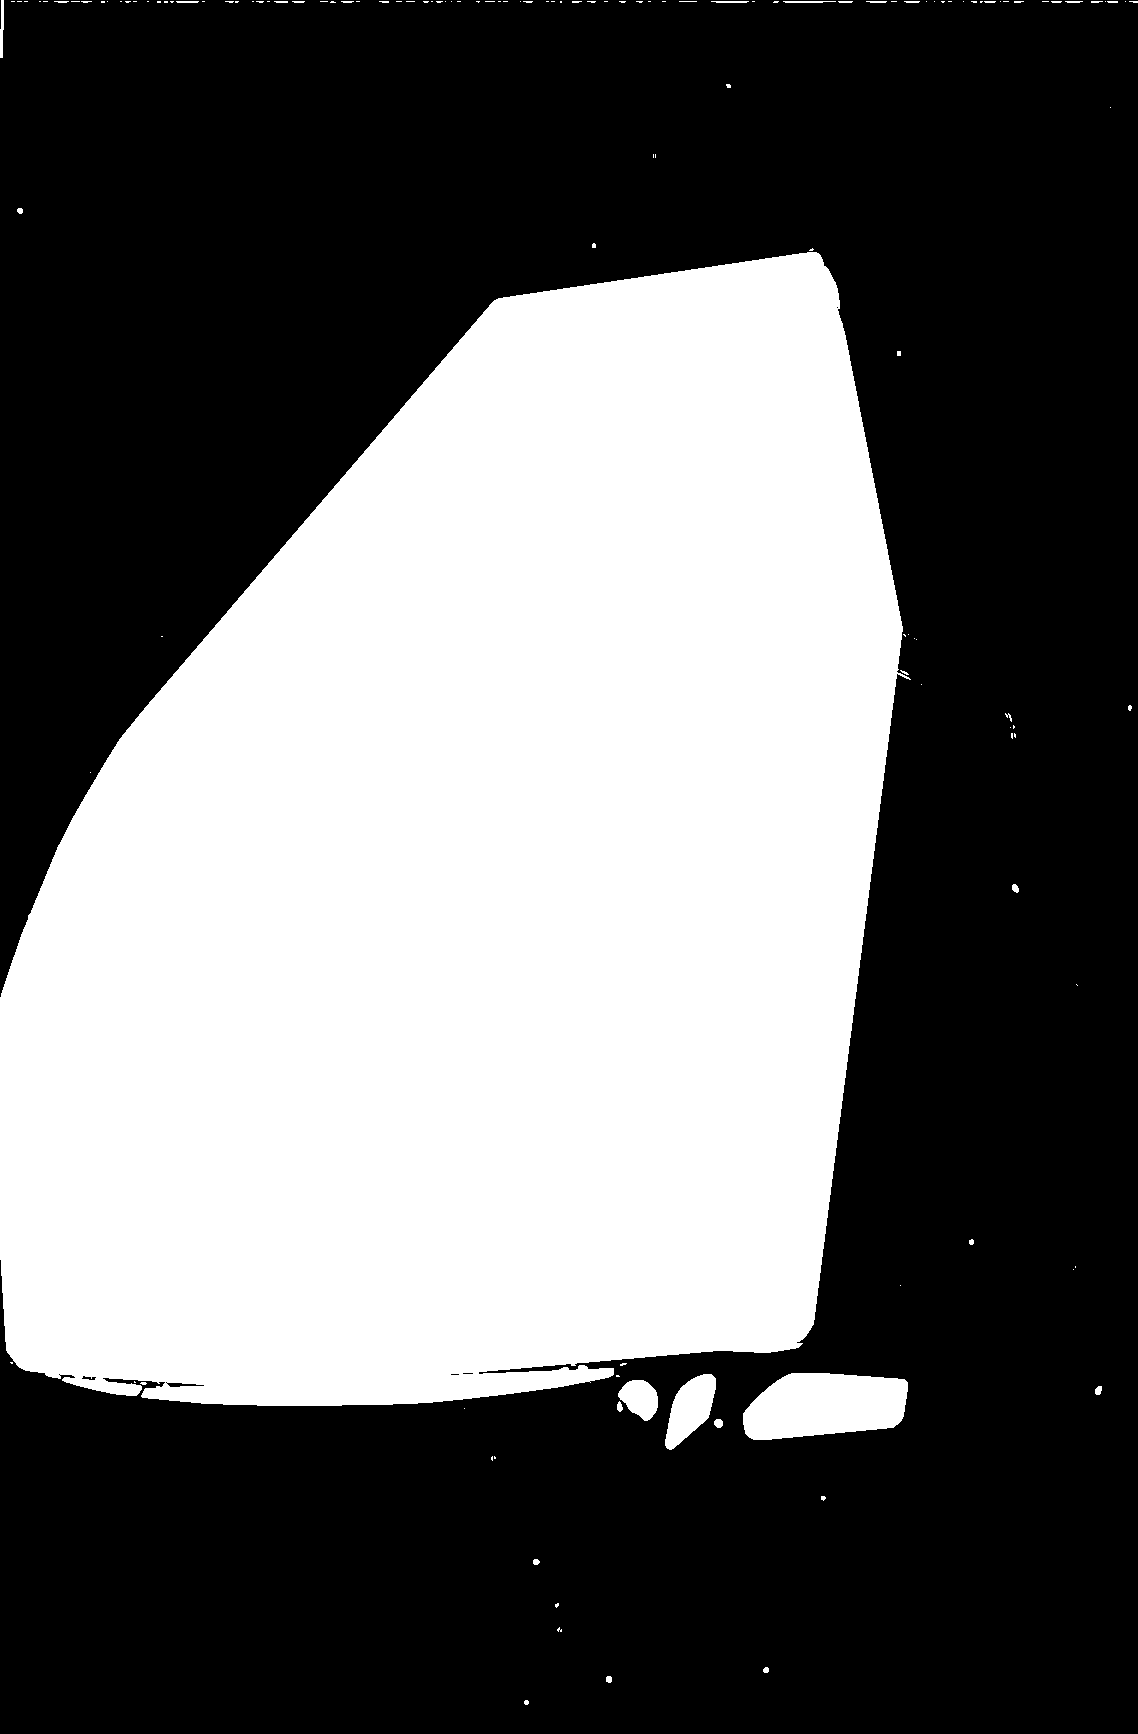

Processing file Birman_31.jpg


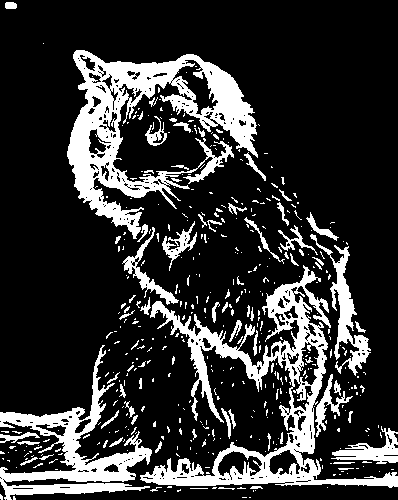

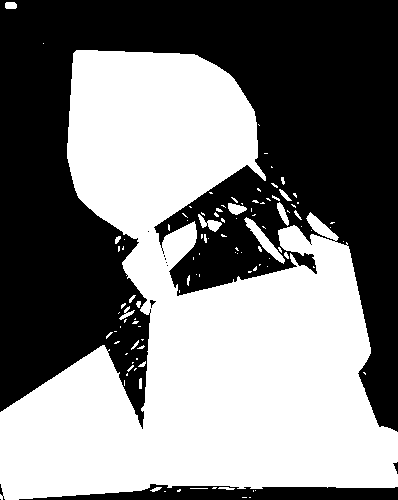

Processing file Abyssinian_44.jpg


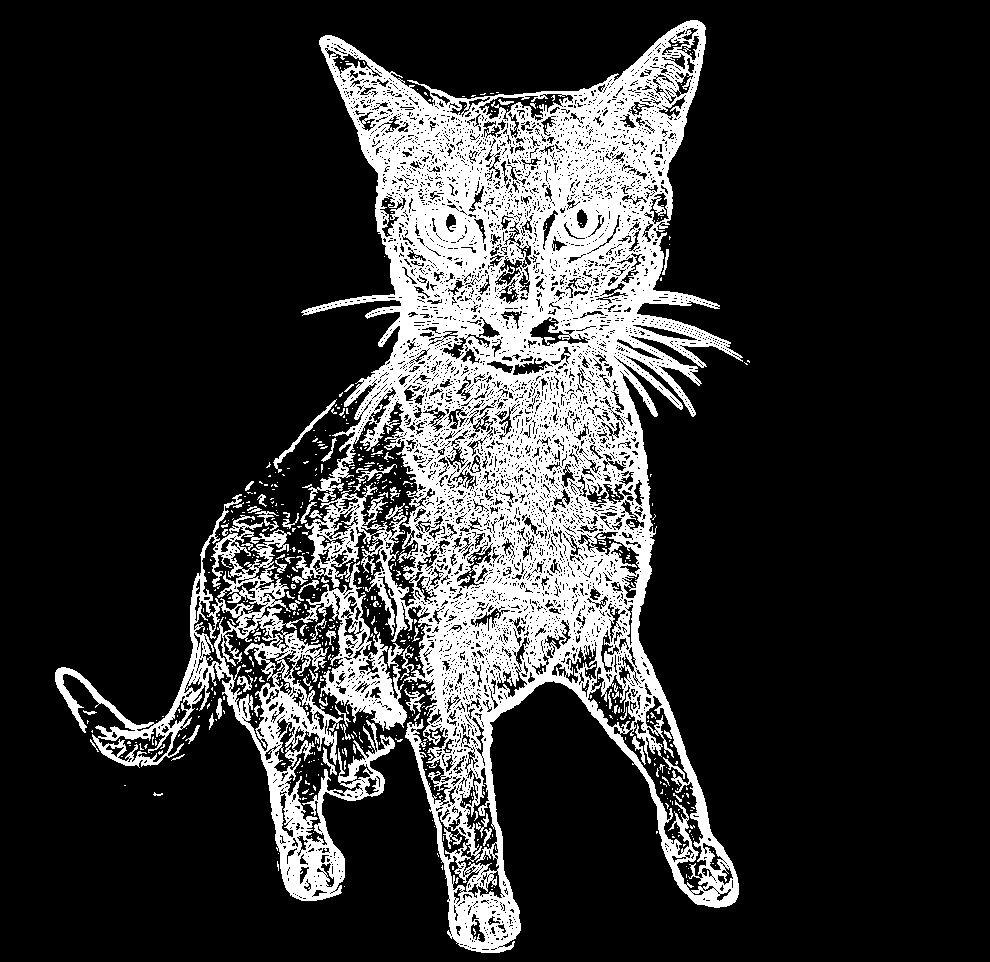

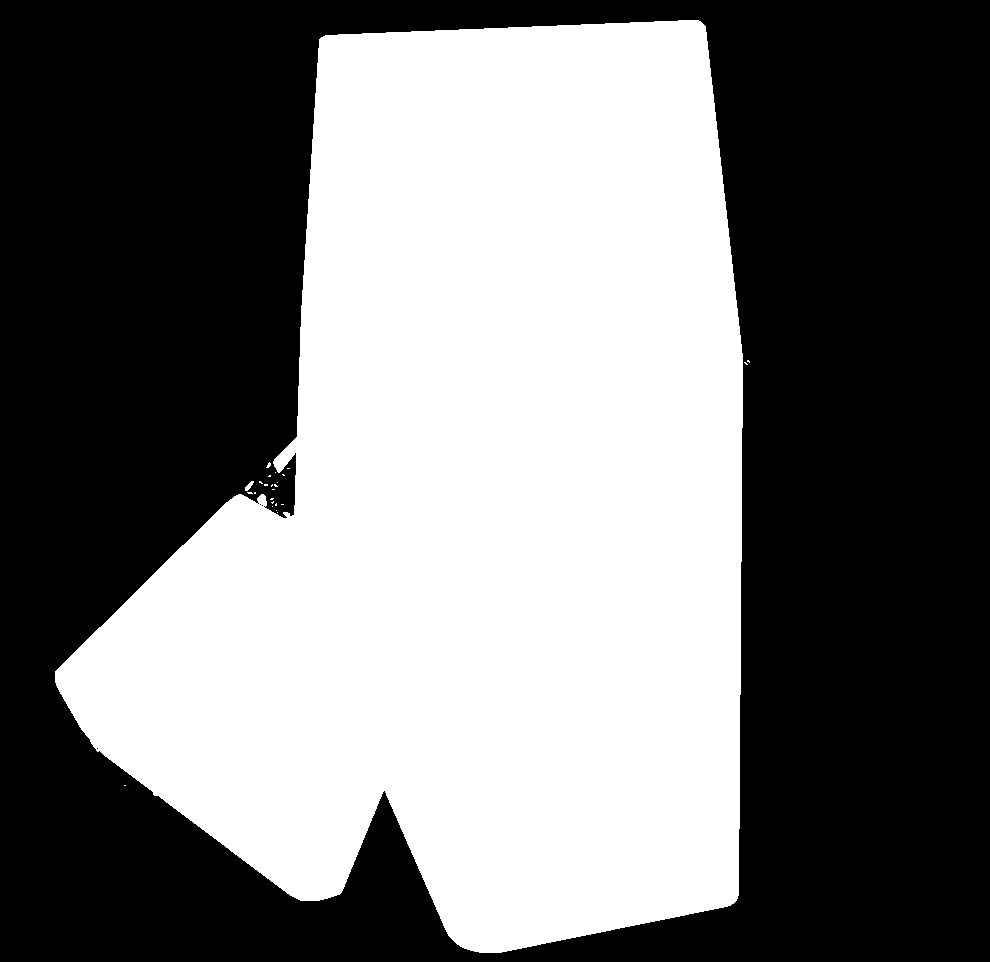

Processing file yorkshire_terrier_82.jpg


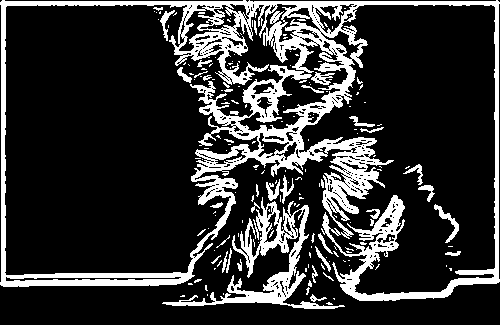

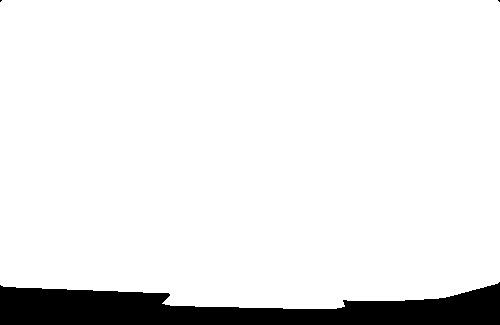

Processing file english_cocker_spaniel_144.jpg


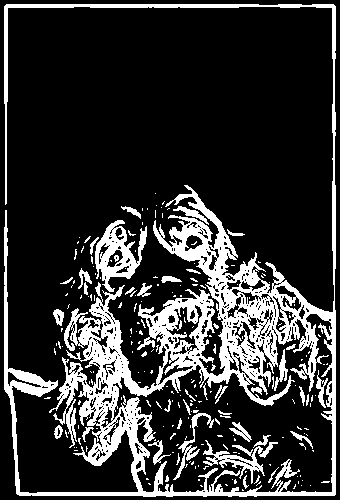

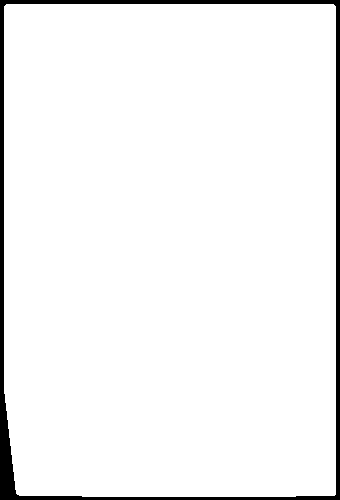

Processing file Egyptian_Mau_14.jpg


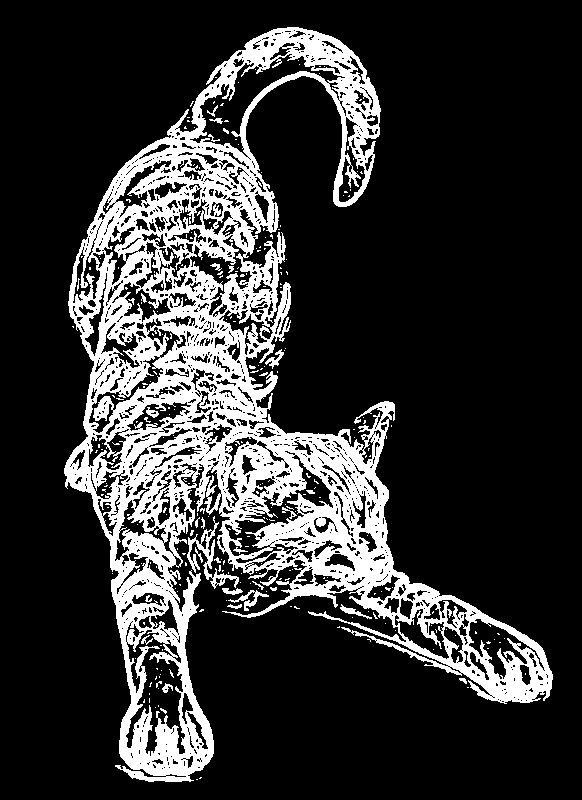

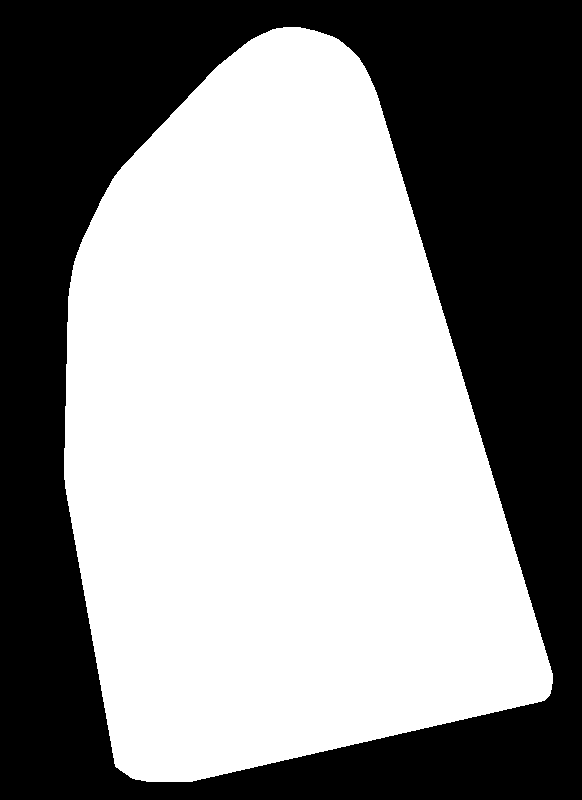

Processing file Siamese_189.jpg


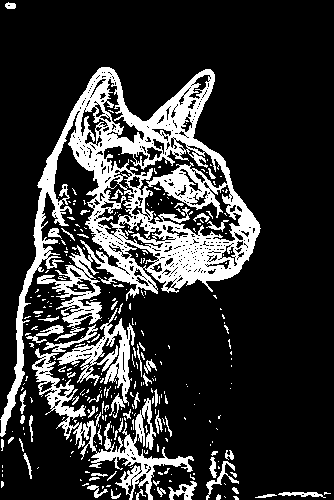

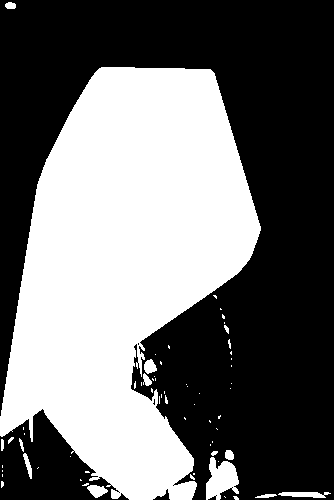

Processing file german_shorthaired_66.jpg


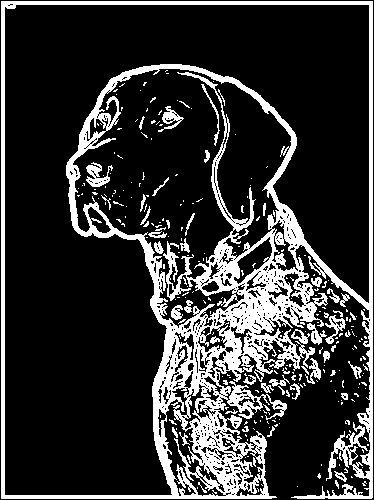

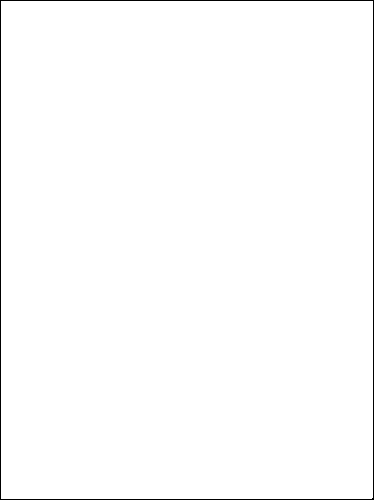

Processing file boxer_108.jpg


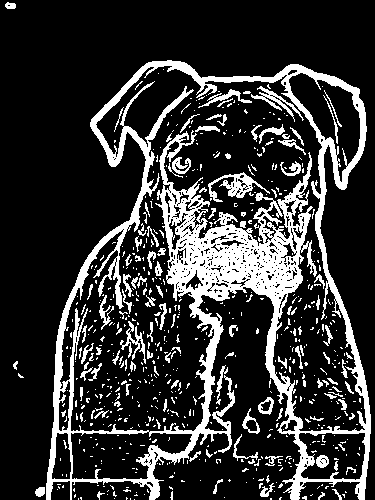

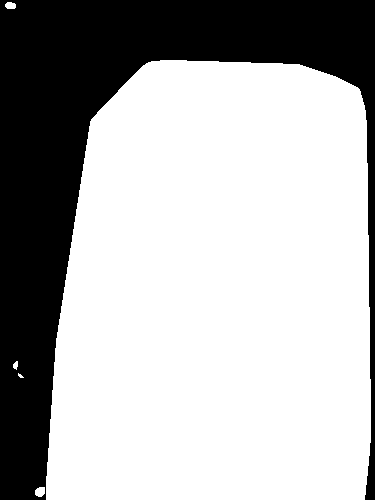

Processing file shiba_inu_140.jpg


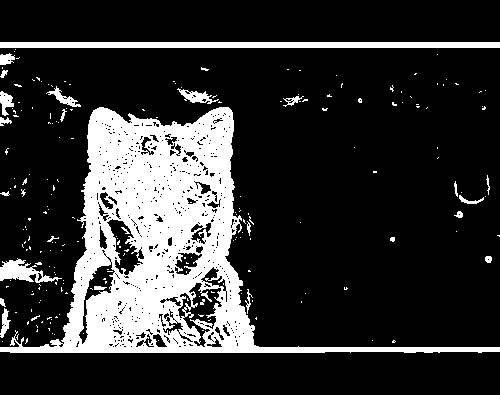

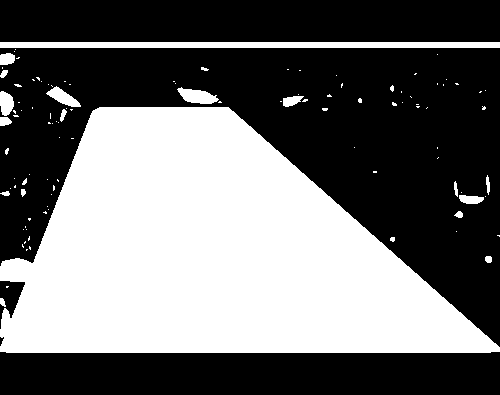

Processing file havanese_84.jpg


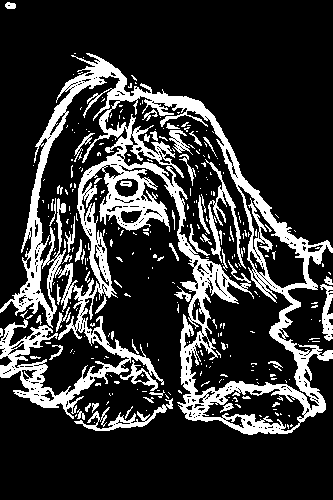

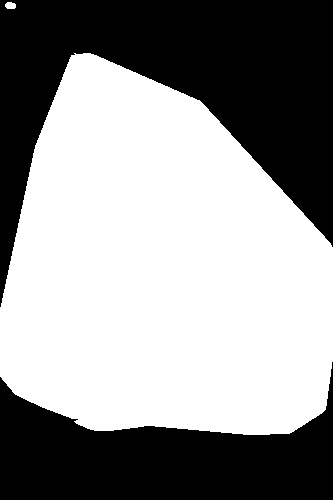

Processing file Russian_Blue_199.jpg


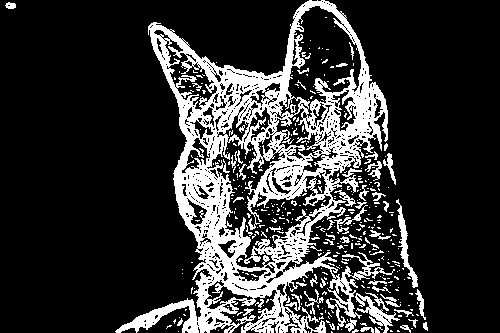

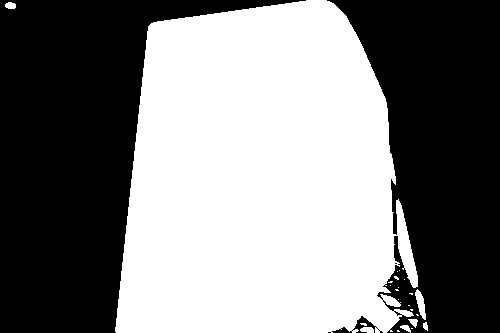

Processing file leonberger_189.jpg


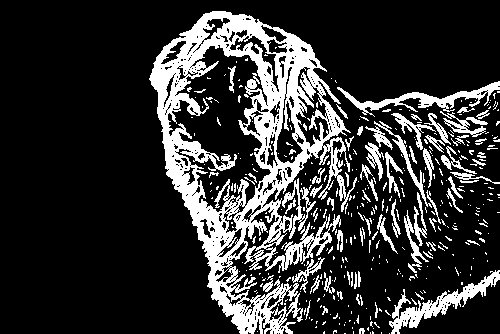

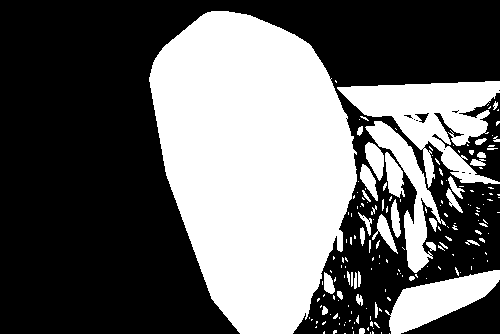

Processing file newfoundland_110.jpg


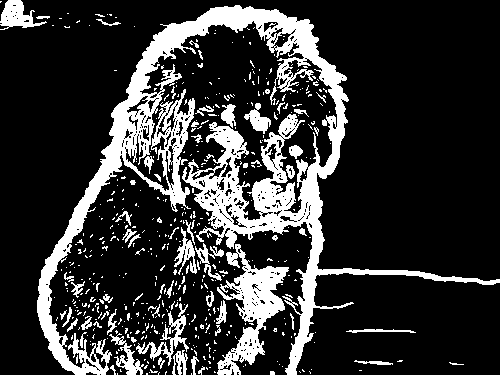

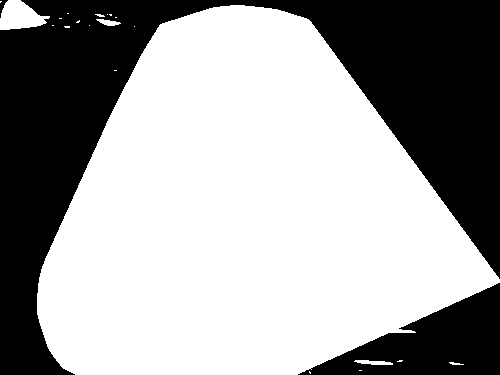

Processing file german_shorthaired_126.jpg


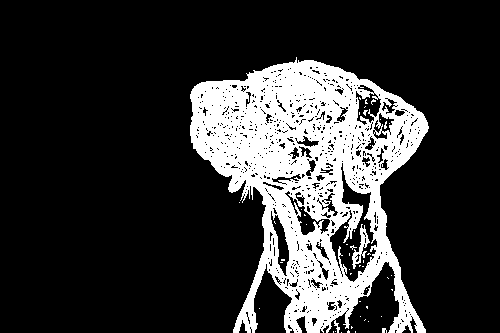

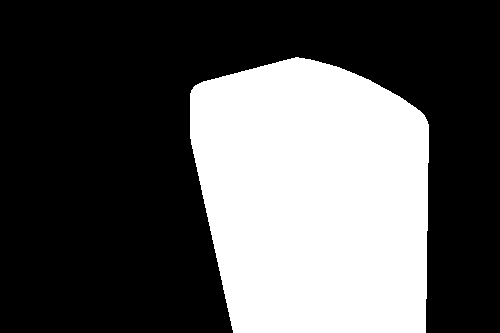

Processing file Sphynx_37.jpg


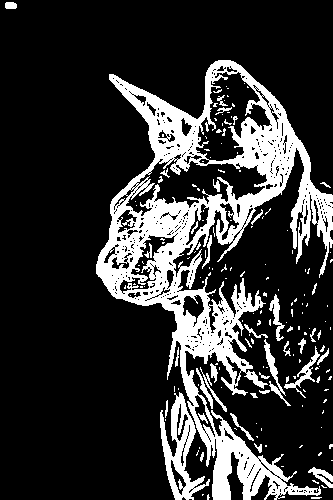

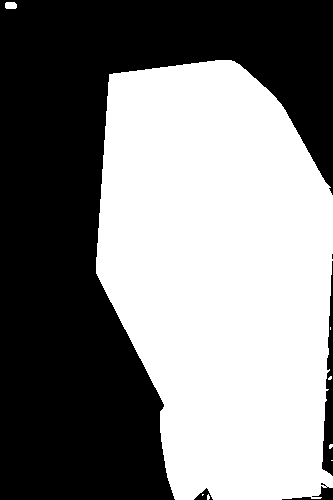

Processing file Sphynx_25.jpg


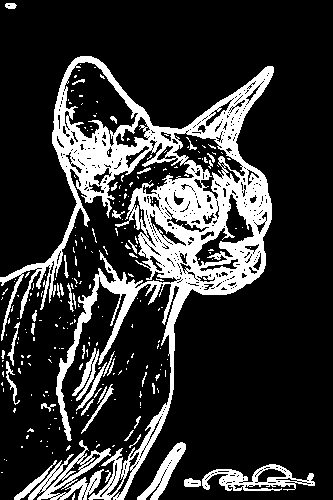

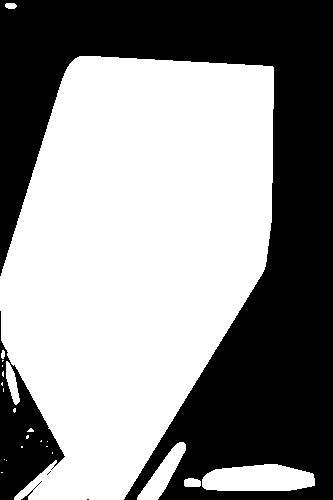

Processing file British_Shorthair_67.jpg


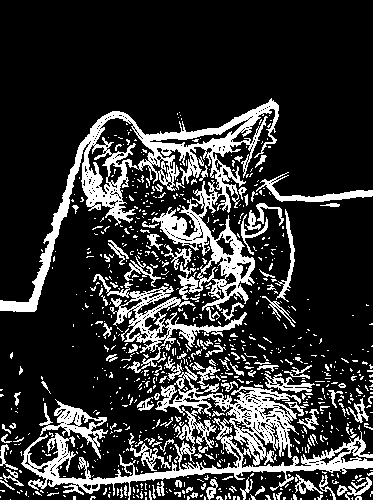

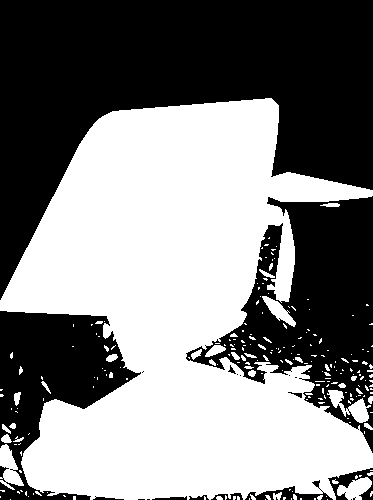

Processing file Abyssinian_31.jpg


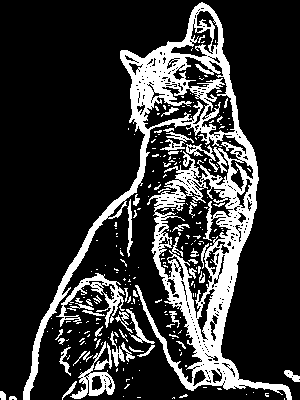

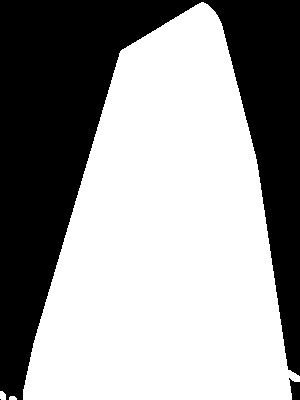

Processing file Persian_221.jpg


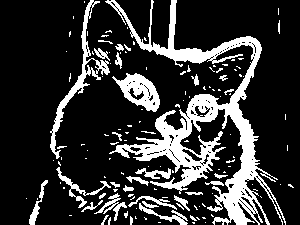

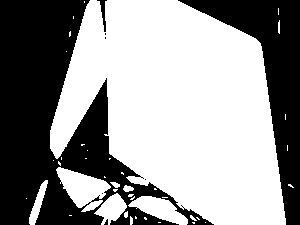

Processing file pug_65.jpg


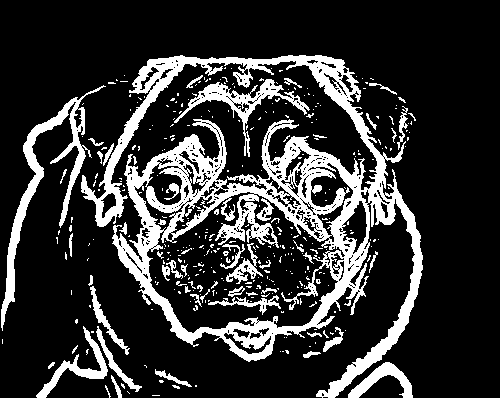

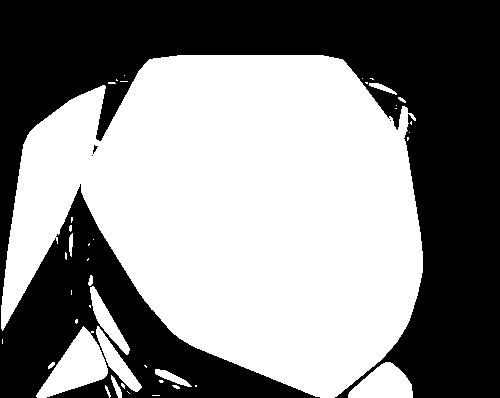

Processing file american_bulldog_95.jpg


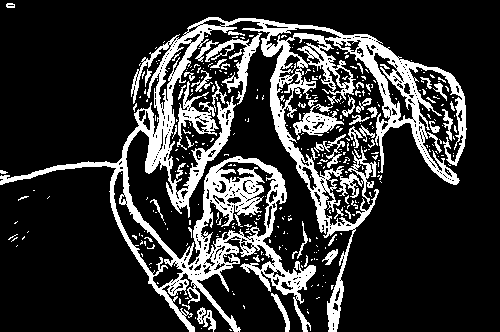

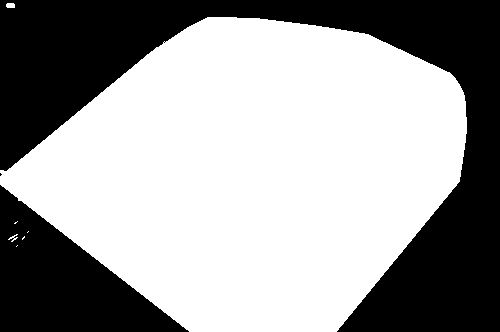

Processing file British_Shorthair_70.jpg


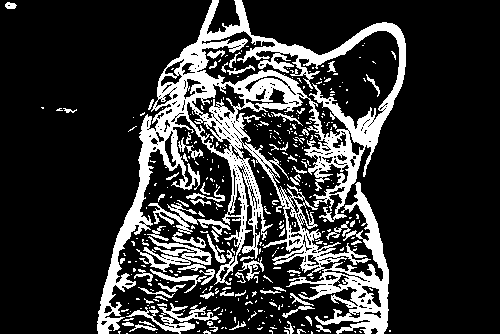

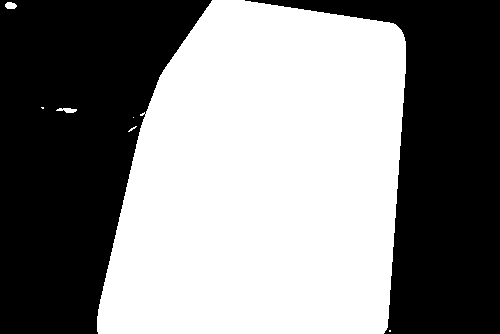

Processing file wheaten_terrier_53.jpg


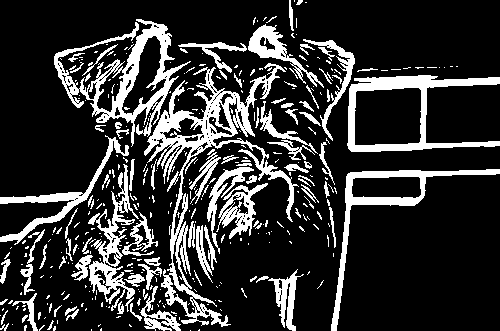

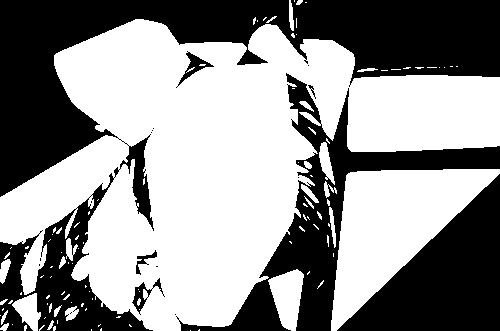

Processing file yorkshire_terrier_75.jpg


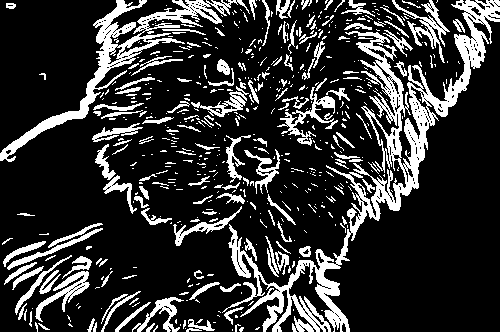

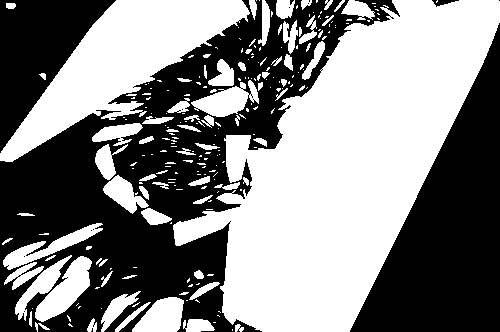

Processing file american_bulldog_140.jpg


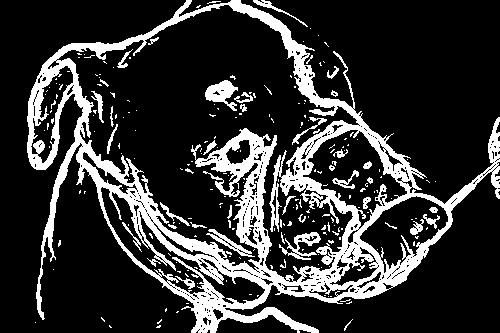

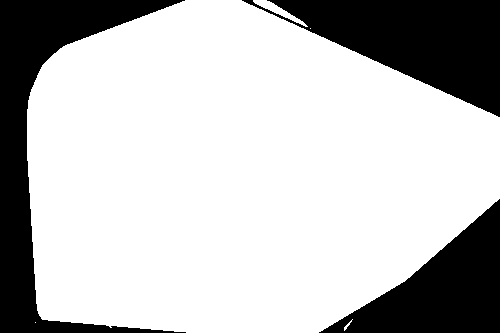

Processing file Abyssinian_122.jpg


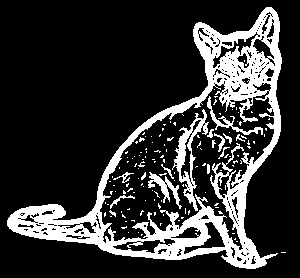

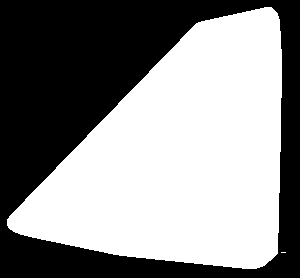

Processing file Bengal_50.jpg


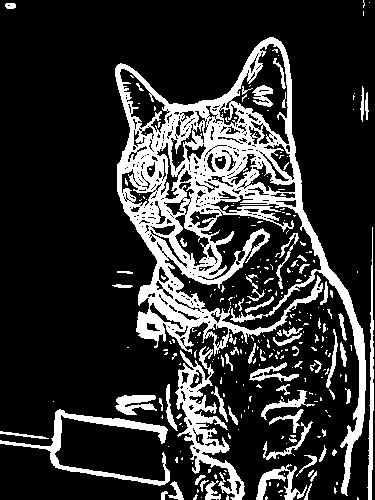

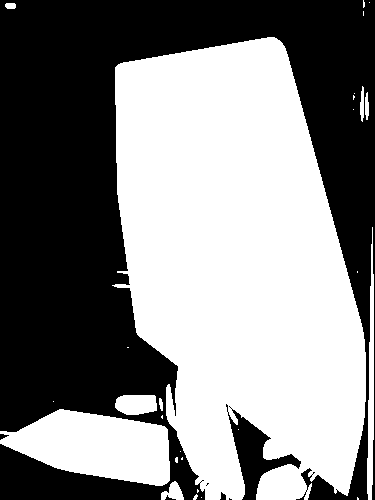

Processing file beagle_1.jpg


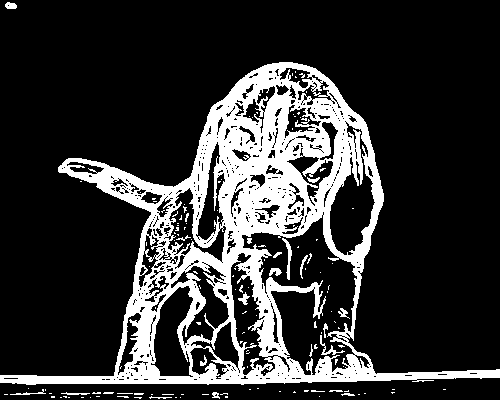

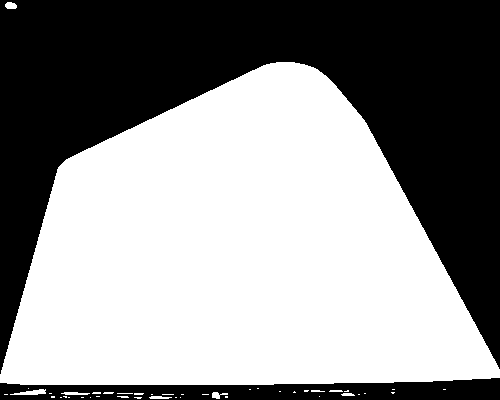

Processing file British_Shorthair_109.jpg


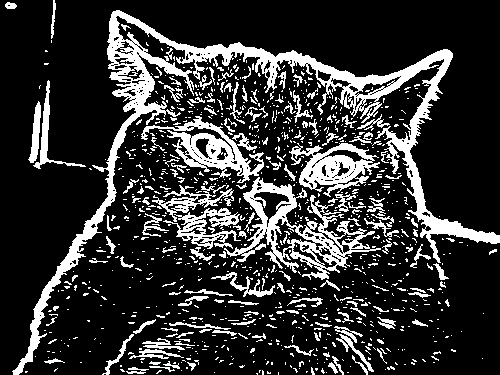

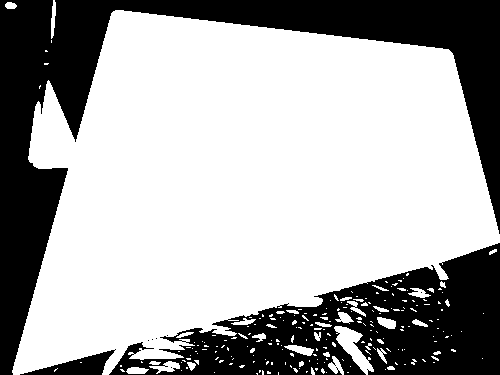

Processing file leonberger_2.jpg


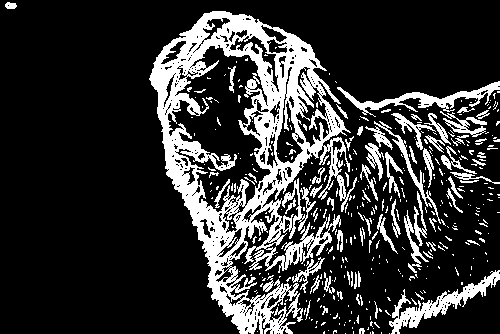

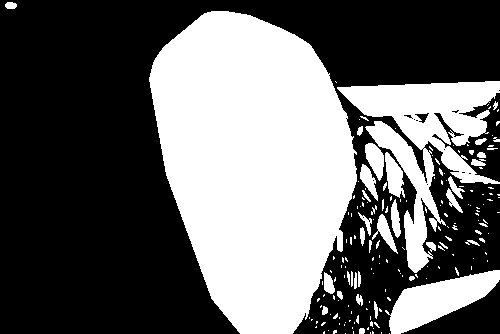

Processing file British_Shorthair_93.jpg


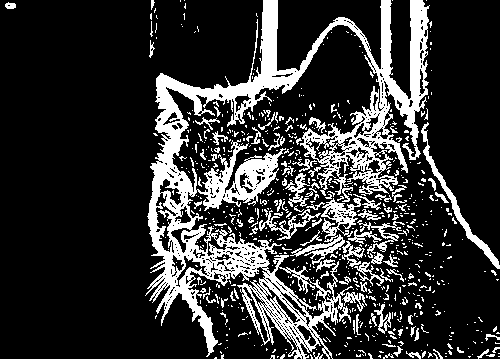

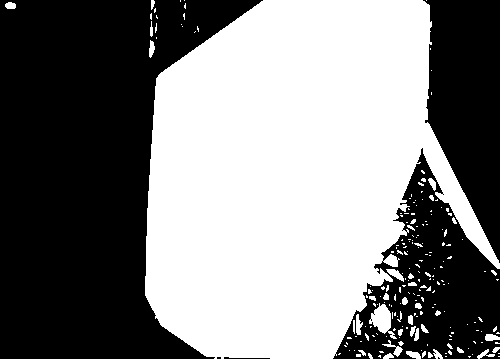

Processing file Ragdoll_125.jpg


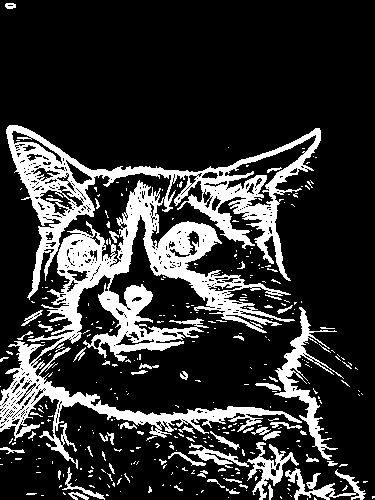

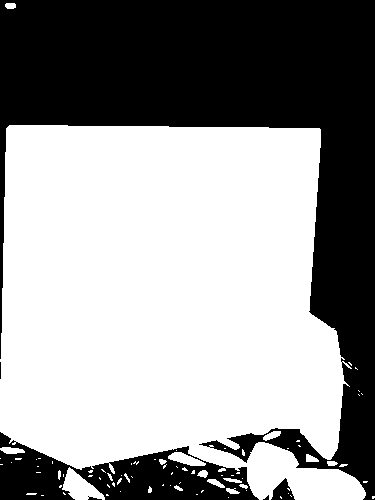

Metric_value 0.7299271219343698


In [39]:
print(f"Metric_value {evaluate_iou(image_dir='./images', anno_dir='./annotations')}")